<center><h1>Bitcoin Price Predictioner</h1></center>

<center><h3>by Lorenzo Carovillano</h3></center>

# 

### The goal of this EDA is to analyze the trend of Bitcoin price over the years, and create a daily prediction model of the average price using only the new dates and the previous days price as input. 

In [281]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit, validation_curve

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error, make_scorer, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (25.0, 10.0)
sns.set()

import warnings
warnings.filterwarnings('ignore')

from utils.plottings import plot_learning_curve

# 

### The 'df_train' will be the default dataset object for analysis, and it will be indexed by dates to perform initial operations
### All other operations of formatting, scaling and shifting will be done on separated objects

In [282]:
df_train = pd.read_csv('dataset.csv', parse_dates=True, index_col='Date')
display(df_train)
display(df_train.info())

Open        High         Low       Close        Volume  \
Date                                                                       
2023-06-13  25910.0400  26300.0800  25760.0400  25910.0300  3.377094e+10   
2023-06-12  25922.8900  26081.6100  25662.9500  25887.5900  3.018877e+10   
2023-06-11  25820.2300  26147.8400  25676.5900  25920.8600  3.299485e+10   
2023-06-10  26481.4700  26500.5000  25491.9100  25842.8400  3.586479e+10   
2023-06-09  26509.3800  26766.2800  26325.9100  26489.4600  2.879870e+10   
...                ...         ...         ...         ...           ...   
2010-07-21      0.0792      0.0792      0.0792      0.0792  0.000000e+00   
2010-07-20      0.0747      0.0747      0.0747      0.0747  0.000000e+00   
2010-07-19      0.0808      0.0808      0.0808      0.0808  0.000000e+00   
2010-07-18      0.0858      0.0858      0.0858      0.0858  0.000000e+00   
2010-07-17      0.0500      0.0500      0.0500      0.0500  0.000000e+00   

              Market Cap  
Date                      
2023-06-13  5.042019e+11  
2023-06-12  5.018320e+11  
2023-06-11  5.011299e+11  
2023-06-10  5.009359e+11  
2023-06-09  5.143227e+11  
...                  ...  
2010-07-21  0.000000e+00  
2010-07-20  0.000000e+00  
2010-07-19  0.000000e+00  
2010-07-18  0.000000e+00  
2010-07-17  0.000000e+00  

[4715 rows x 6 columns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4715 entries, 2023-06-13 to 2010-07-17
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        4715 non-null   float64
 1   High        4715 non-null   float64
 2   Low         4715 non-null   float64
 3   Close       4715 non-null   float64
 4   Volume      4715 non-null   float64
 5   Market Cap  4715 non-null   float64
dtypes: float64(6)
memory usage: 257.9 KB


None

In [283]:
df_train['Price'] = (df_train['High'] + df_train['Low']) / 2
display(df_train)

Open        High         Low       Close        Volume  \
Date                                                                       
2023-06-13  25910.0400  26300.0800  25760.0400  25910.0300  3.377094e+10   
2023-06-12  25922.8900  26081.6100  25662.9500  25887.5900  3.018877e+10   
2023-06-11  25820.2300  26147.8400  25676.5900  25920.8600  3.299485e+10   
2023-06-10  26481.4700  26500.5000  25491.9100  25842.8400  3.586479e+10   
2023-06-09  26509.3800  26766.2800  26325.9100  26489.4600  2.879870e+10   
...                ...         ...         ...         ...           ...   
2010-07-21      0.0792      0.0792      0.0792      0.0792  0.000000e+00   
2010-07-20      0.0747      0.0747      0.0747      0.0747  0.000000e+00   
2010-07-19      0.0808      0.0808      0.0808      0.0808  0.000000e+00   
2010-07-18      0.0858      0.0858      0.0858      0.0858  0.000000e+00   
2010-07-17      0.0500      0.0500      0.0500      0.0500  0.000000e+00   

              Market Cap       Price  
Date                                  
2023-06-13  5.042019e+11  26030.0600  
2023-06-12  5.018320e+11  25872.2800  
2023-06-11  5.011299e+11  25912.2150  
2023-06-10  5.009359e+11  25996.2050  
2023-06-09  5.143227e+11  26546.0950  
...                  ...         ...  
2010-07-21  0.000000e+00      0.0792  
2010-07-20  0.000000e+00      0.0747  
2010-07-19  0.000000e+00      0.0808  
2010-07-18  0.000000e+00      0.0858  
2010-07-17  0.000000e+00      0.0500  

[4715 rows x 7 columns]

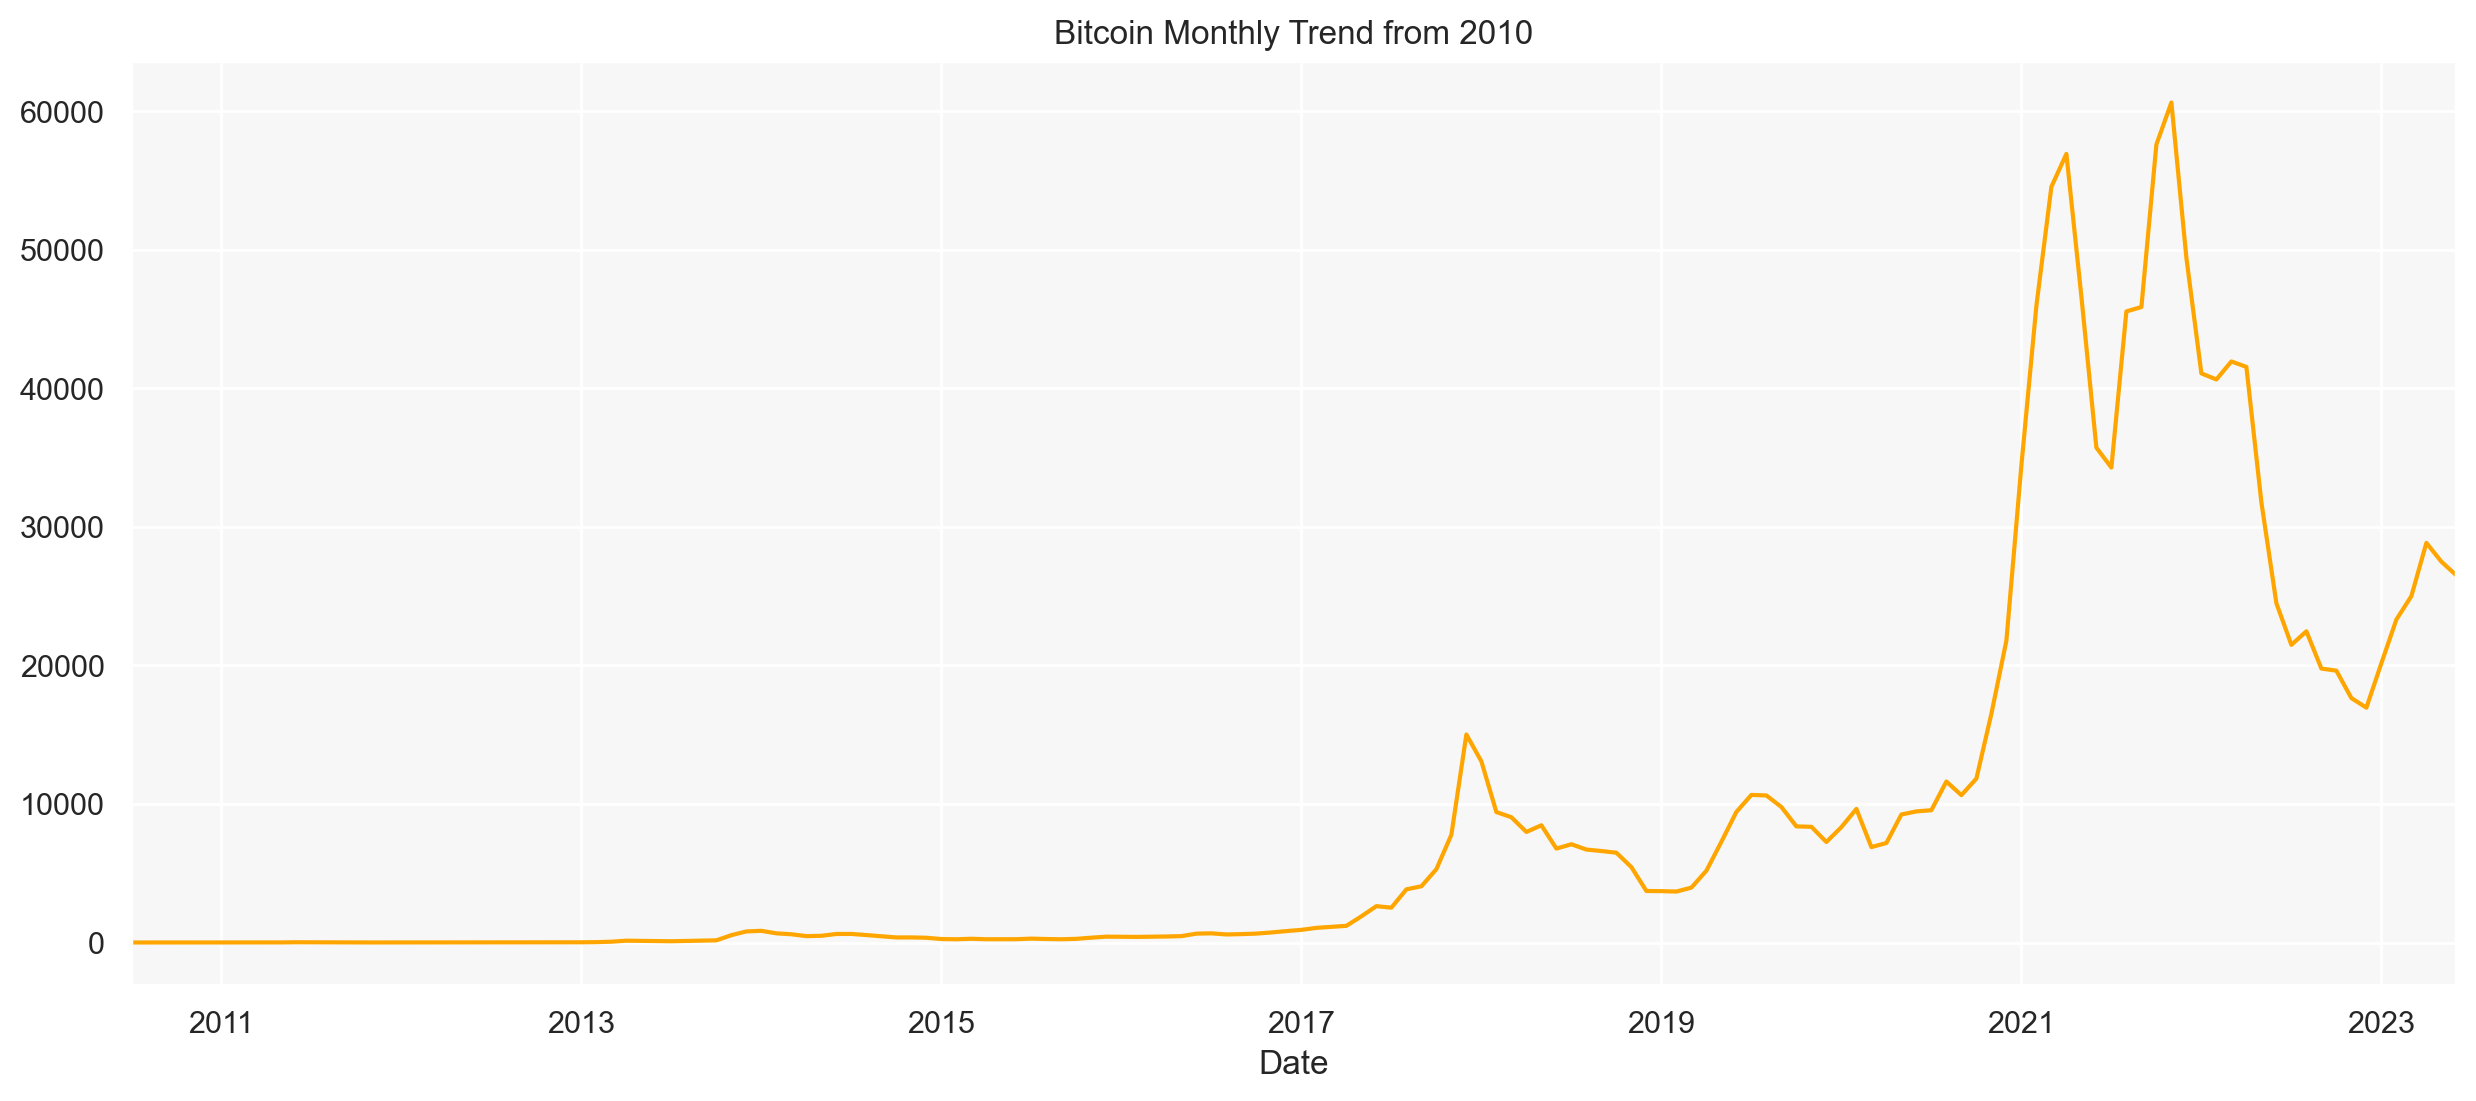

In [284]:
data_df_M = df_train['Price'].resample('M').mean()
ax = data_df_M.plot(figsize=(15, 6), title='Bitcoin Monthly Trend from 2010', linestyle='-', color='orange')
ax.set_facecolor("#F7F7F7")

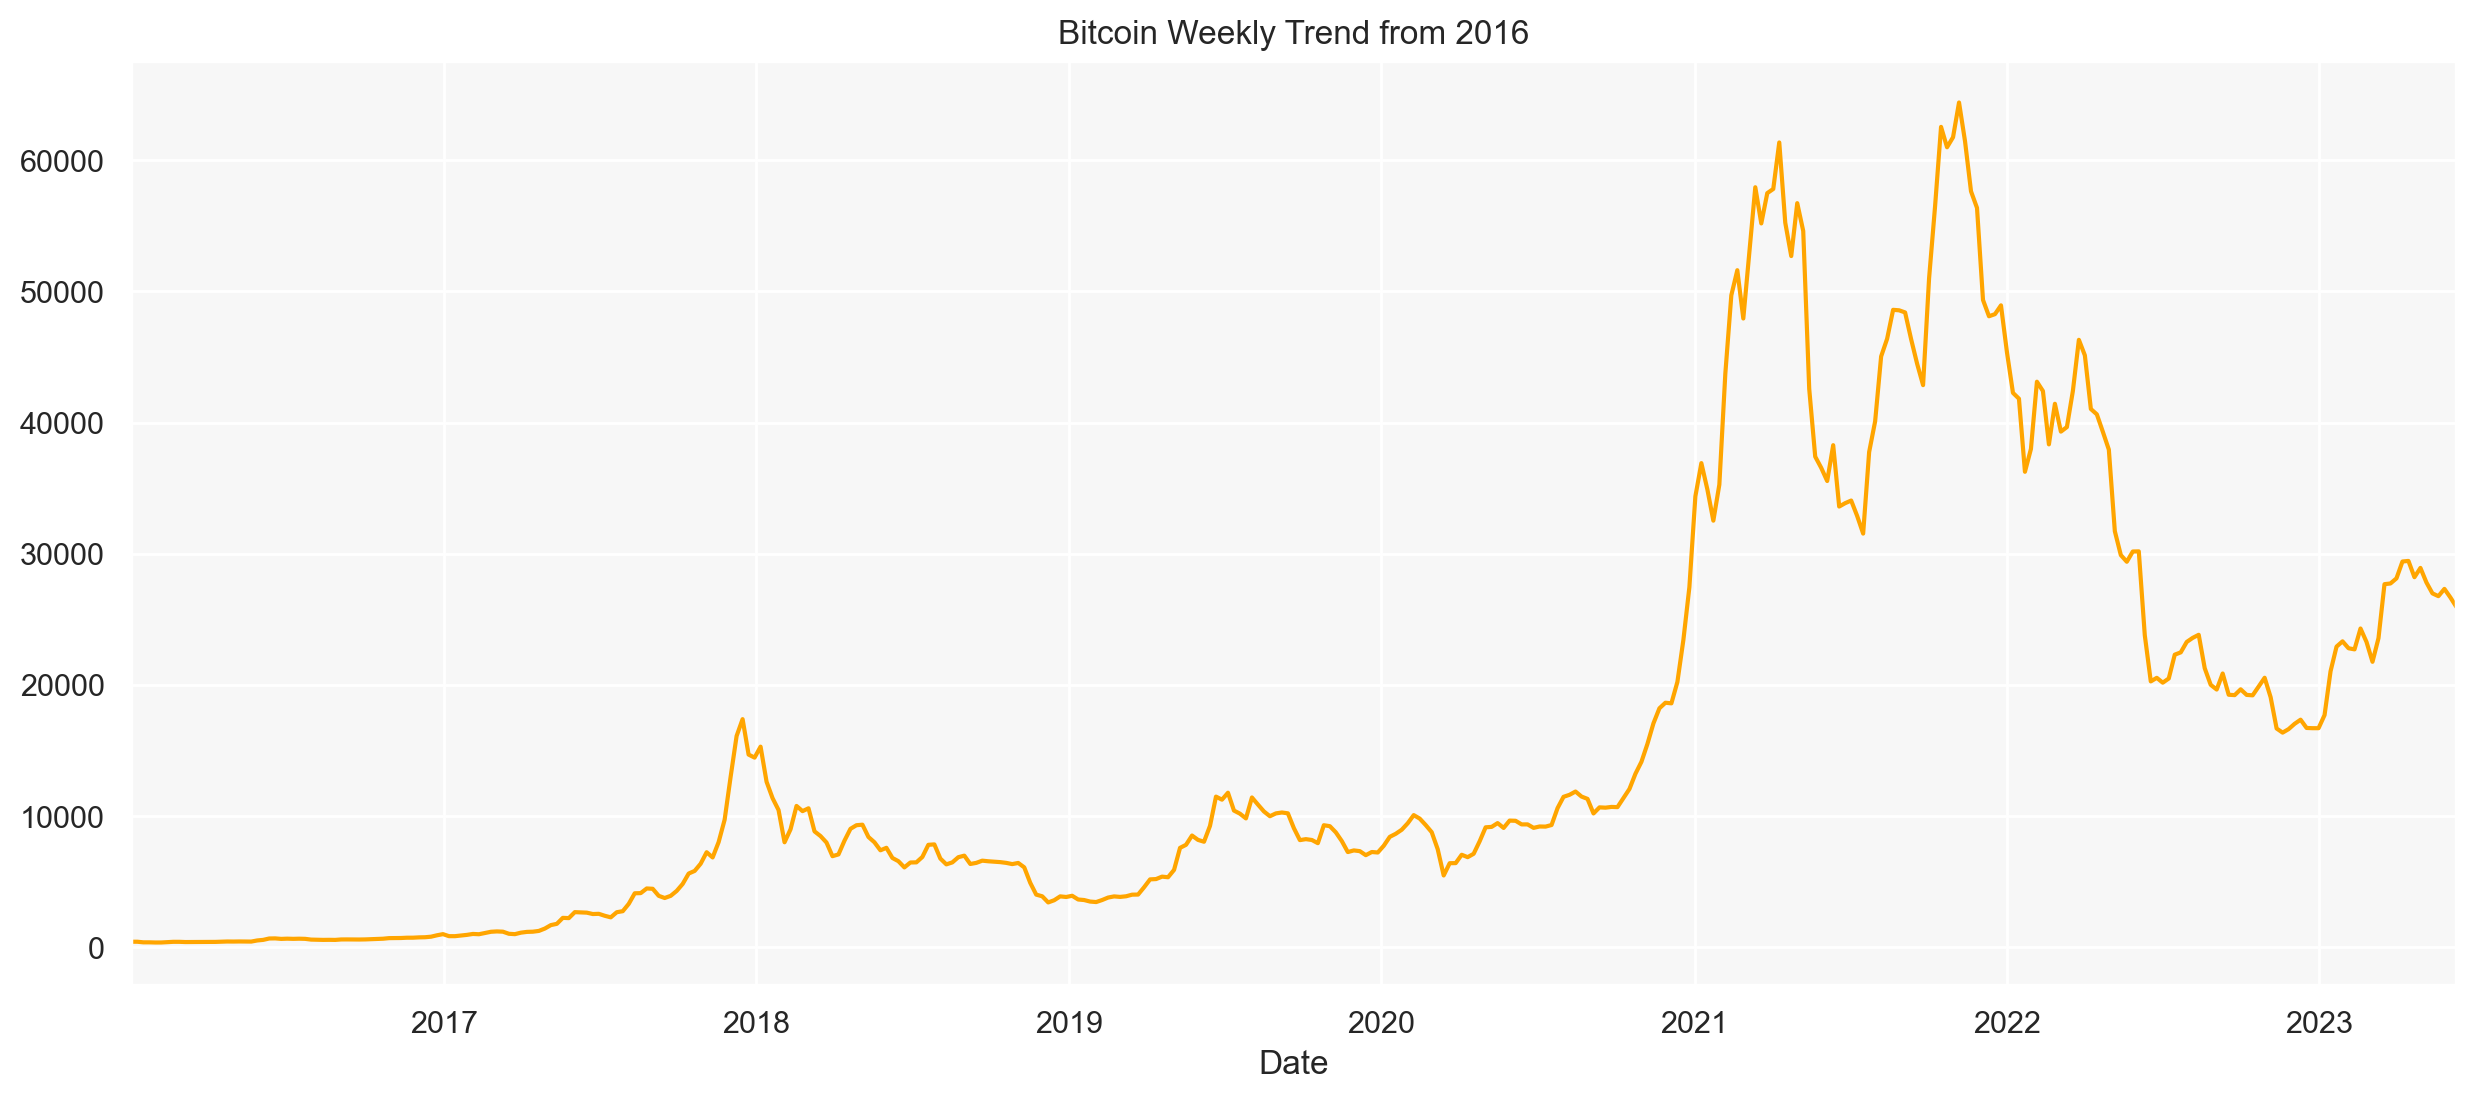

In [285]:
data_df_W = df_train['Price'].resample('7D').mean()
ax = data_df_W['2016':].plot(figsize=(15, 6), title='Bitcoin Weekly Trend from 2016', linestyle='-', color='orange')
ax.set_facecolor("#F7F7F7")

<Axes: >

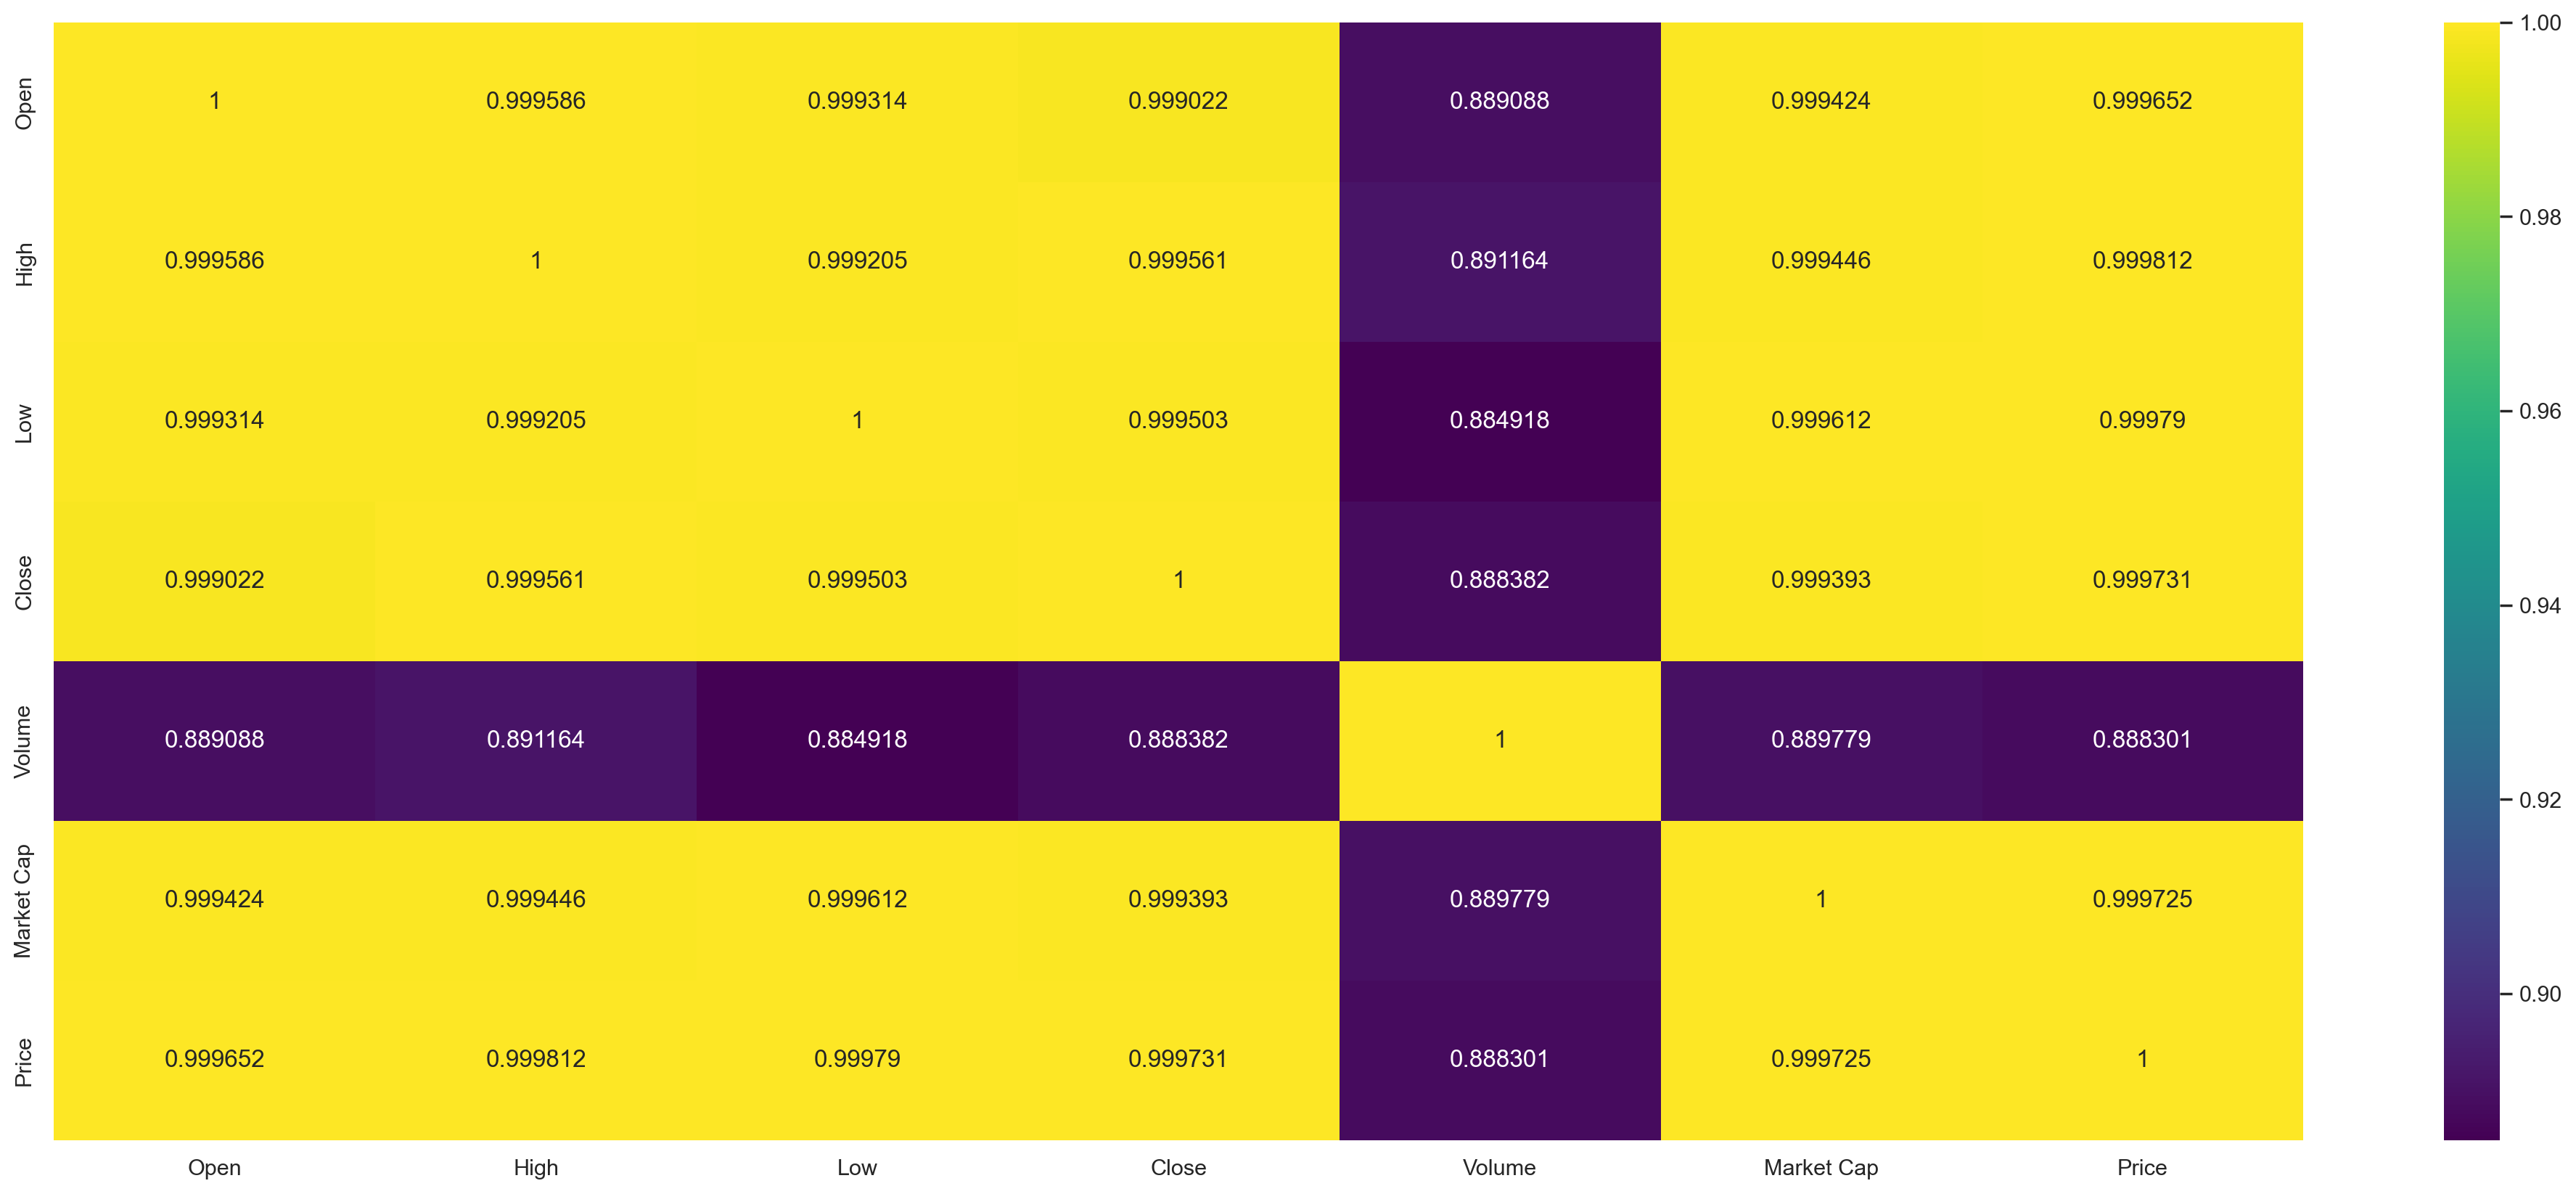

In [286]:
sns.heatmap(df_train.corr(), annot=True, fmt='g', cmap='viridis')

# 

### Removing all features that are not predictables - Keep only target feature and work with index Date as a new float feature to test various models 

In [7]:
# Transform datetime to float value
def _dt64_to_float(dt64):
    
    year = dt64.astype('M8[Y]')
    days = (dt64 - year).astype('timedelta64[D]')
    year_next = year + np.timedelta64(1, 'Y')
    days_of_year = (year_next.astype('M8[D]') - year.astype('M8[D]')).astype('timedelta64[D]')
    dt_float = 1970 + year.astype(float) + days / (days_of_year)
    return dt_float

In [8]:
def _make_formatted_dataset(df, columns):
    
    df = df.reset_index()
    
    # Transform 'Date' feature string values to datetime
    df['Date'] = pd.to_datetime(df.Date)
    
    # Get float value of datetime 'Date' feature
    df['Date_float'] = _dt64_to_float(df['Date'].to_numpy())
    
    # Create 'Price' feature (target) from average of 'High' and 'Low' prices
    # this is already created at start of this EDA # df['Price'] = (df['High'] + df['Low']) / 2
    
    # Remove all old columns because we will not have them for future predictions
    df = df.drop(columns, axis=1)
    
    # Invert order to have oldest record as first
    df = df[::-1]
    
    # Show actual dataset
    display(df)
    return df

In [9]:
df_formatted = _make_formatted_dataset(df_train, ['Date','Open','High','Low','Close','Volume','Market Cap'])

Price   Date_float
4714      0.0500  2010.539726
4713      0.0858  2010.542466
4712      0.0808  2010.545205
4711      0.0747  2010.547945
4710      0.0792  2010.550685
...          ...          ...
4     26546.0950  2023.435616
3     25996.2050  2023.438356
2     25912.2150  2023.441096
1     25872.2800  2023.443836
0     26030.0600  2023.446575

[4715 rows x 2 columns]

### Try various model to evaluate the initial scores

In [10]:
# Spot Check Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

neg_mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

def _models_score(df):
    models = []
    models.append(('DecisionTreeRegressor', DecisionTreeRegressor()))
    models.append(('LinearRegression', LinearRegression()))
    models.append(('GradientBoostingRegressor', GradientBoostingRegressor()))
    models.append(('MLPRegressor', MLPRegressor(hidden_layer_sizes=(32, 8), solver = 'adam', max_iter=2000)))  #neural network
    models.append(('KNeighborsRegressor', KNeighborsRegressor())) 
    models.append(('RandomForestRegressor', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
    models.append(('SVR', SVR(gamma='auto'))) # kernel = linear

    # This cell may take some time to be executed
    X_train = df.drop('Price', axis=1)
    y_train = df.Price

    # Evaluate each model in turn
    results = []
    names = []
    for name, model in models:
        # TimeSeries Cross validation
        tscv = TimeSeriesSplit(n_splits=10)

        cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring=neg_mape)
        results.append(cv_results)
        names.append(name)
        model.fit(X_train, y_train)
        print('%s: NEG_MAPE=%f (STD=%f) (R2=%f)' % (name, cv_results.mean(), cv_results.std(), model.score(X_train, y_train)))
        plot_learning_curve(model, name, X_train, y_train, cv=tscv)
        plt.show()

    # Compare Algorithms
    plt.boxplot(results, labels=names)
    plt.title('Algorithm Comparison')
    plt.show()


DecisionTreeRegressor: NEG_MAPE=-0.514125 (STD=0.270933) (R2=1.000000)


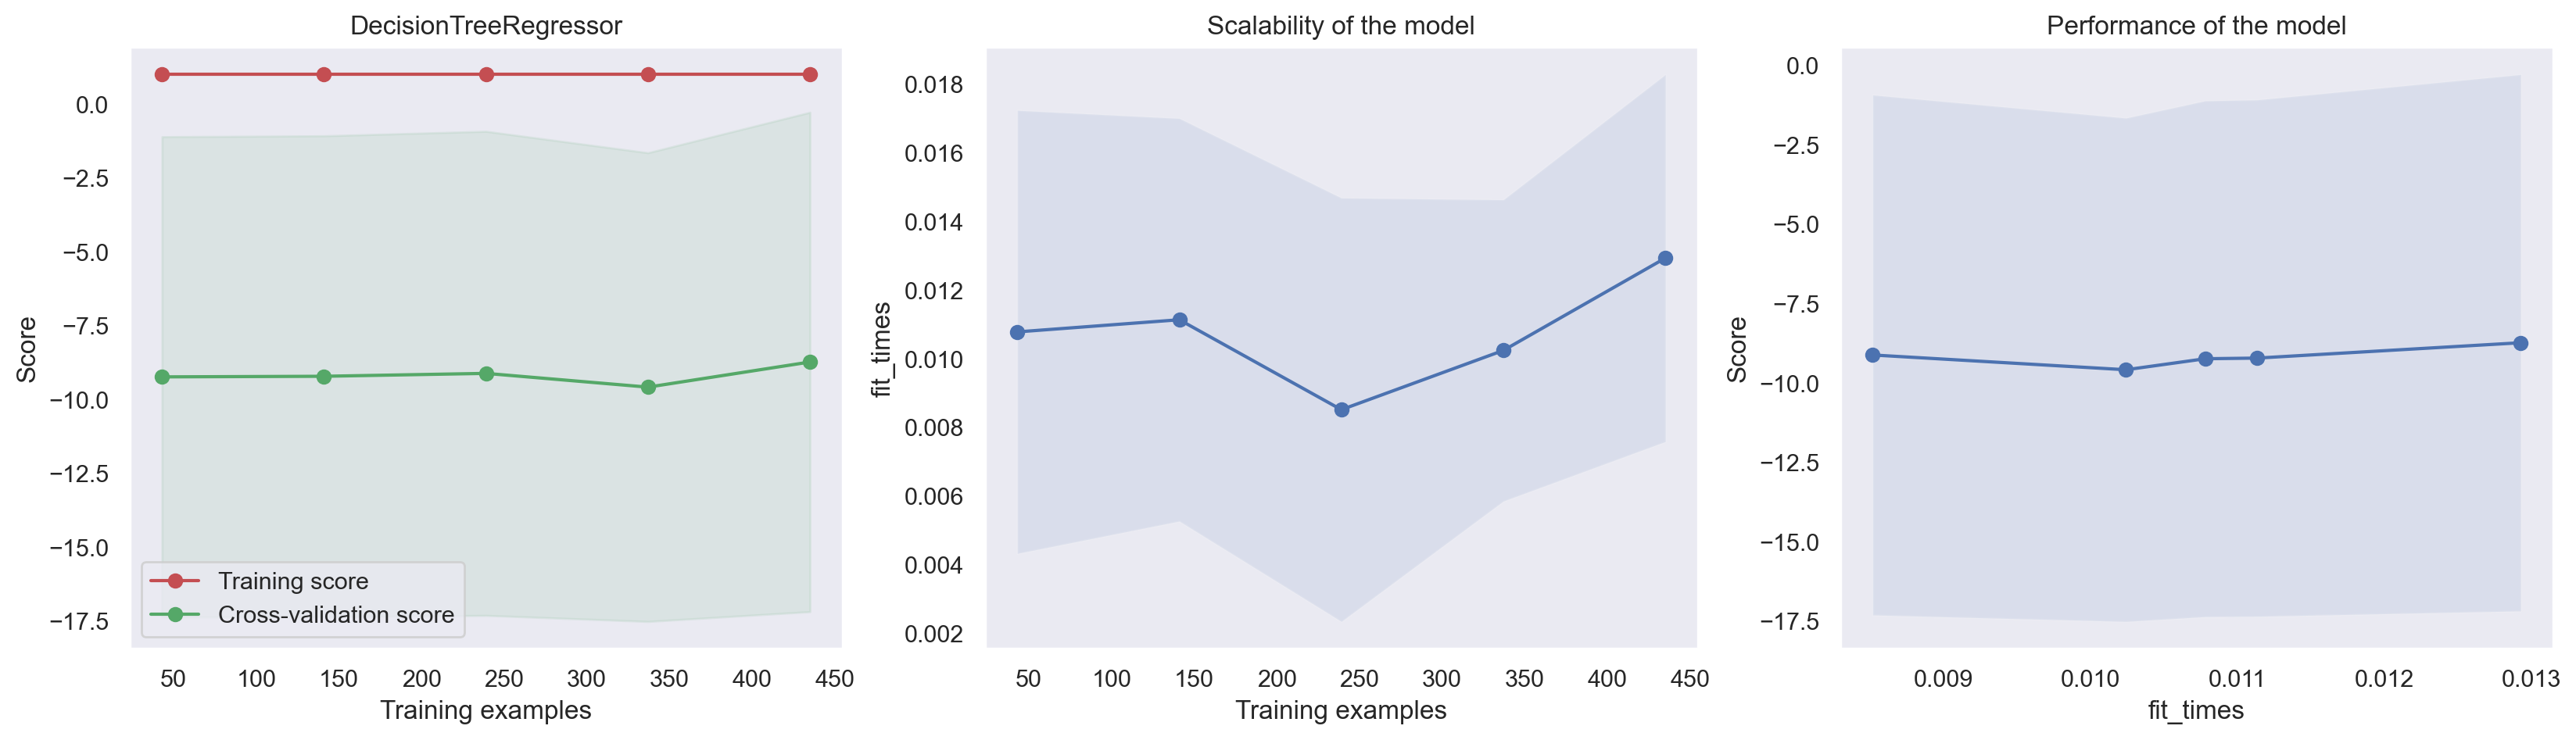

LinearRegression: NEG_MAPE=-0.693986 (STD=0.516385) (R2=0.524188)


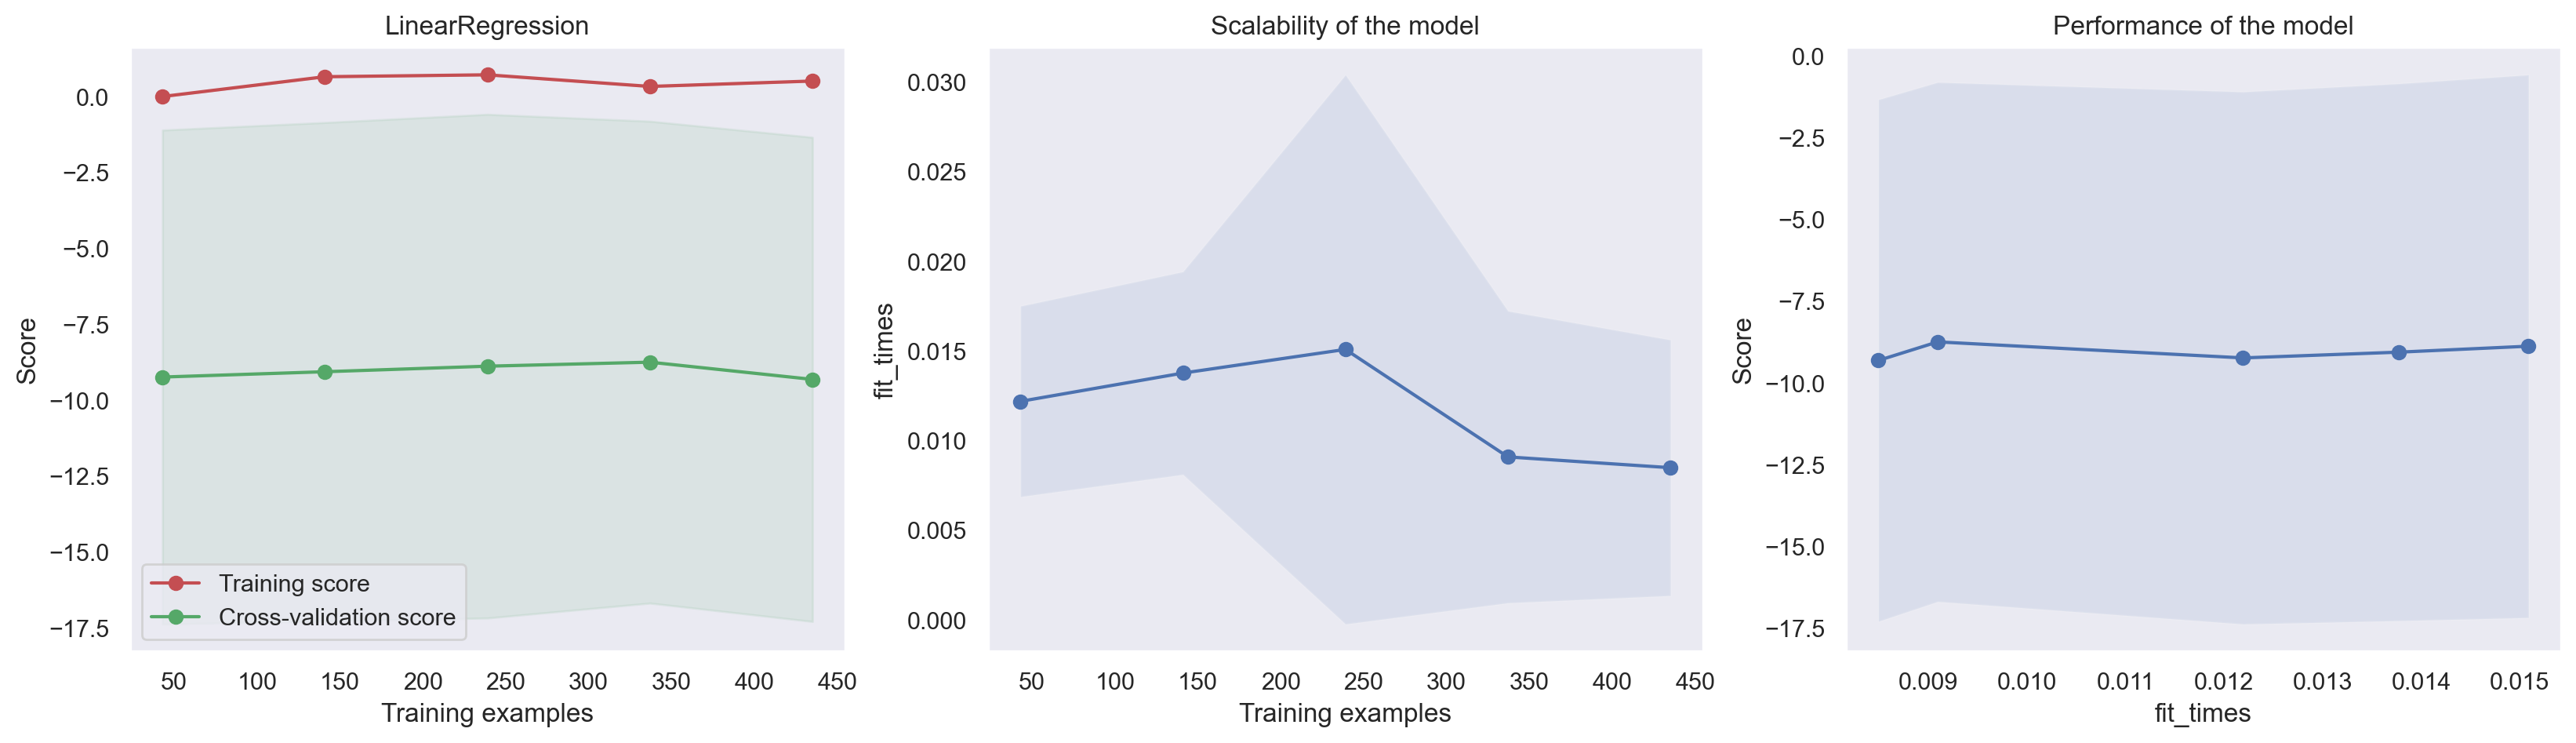

GradientBoostingRegressor: NEG_MAPE=-0.521537 (STD=0.278434) (R2=0.997289)


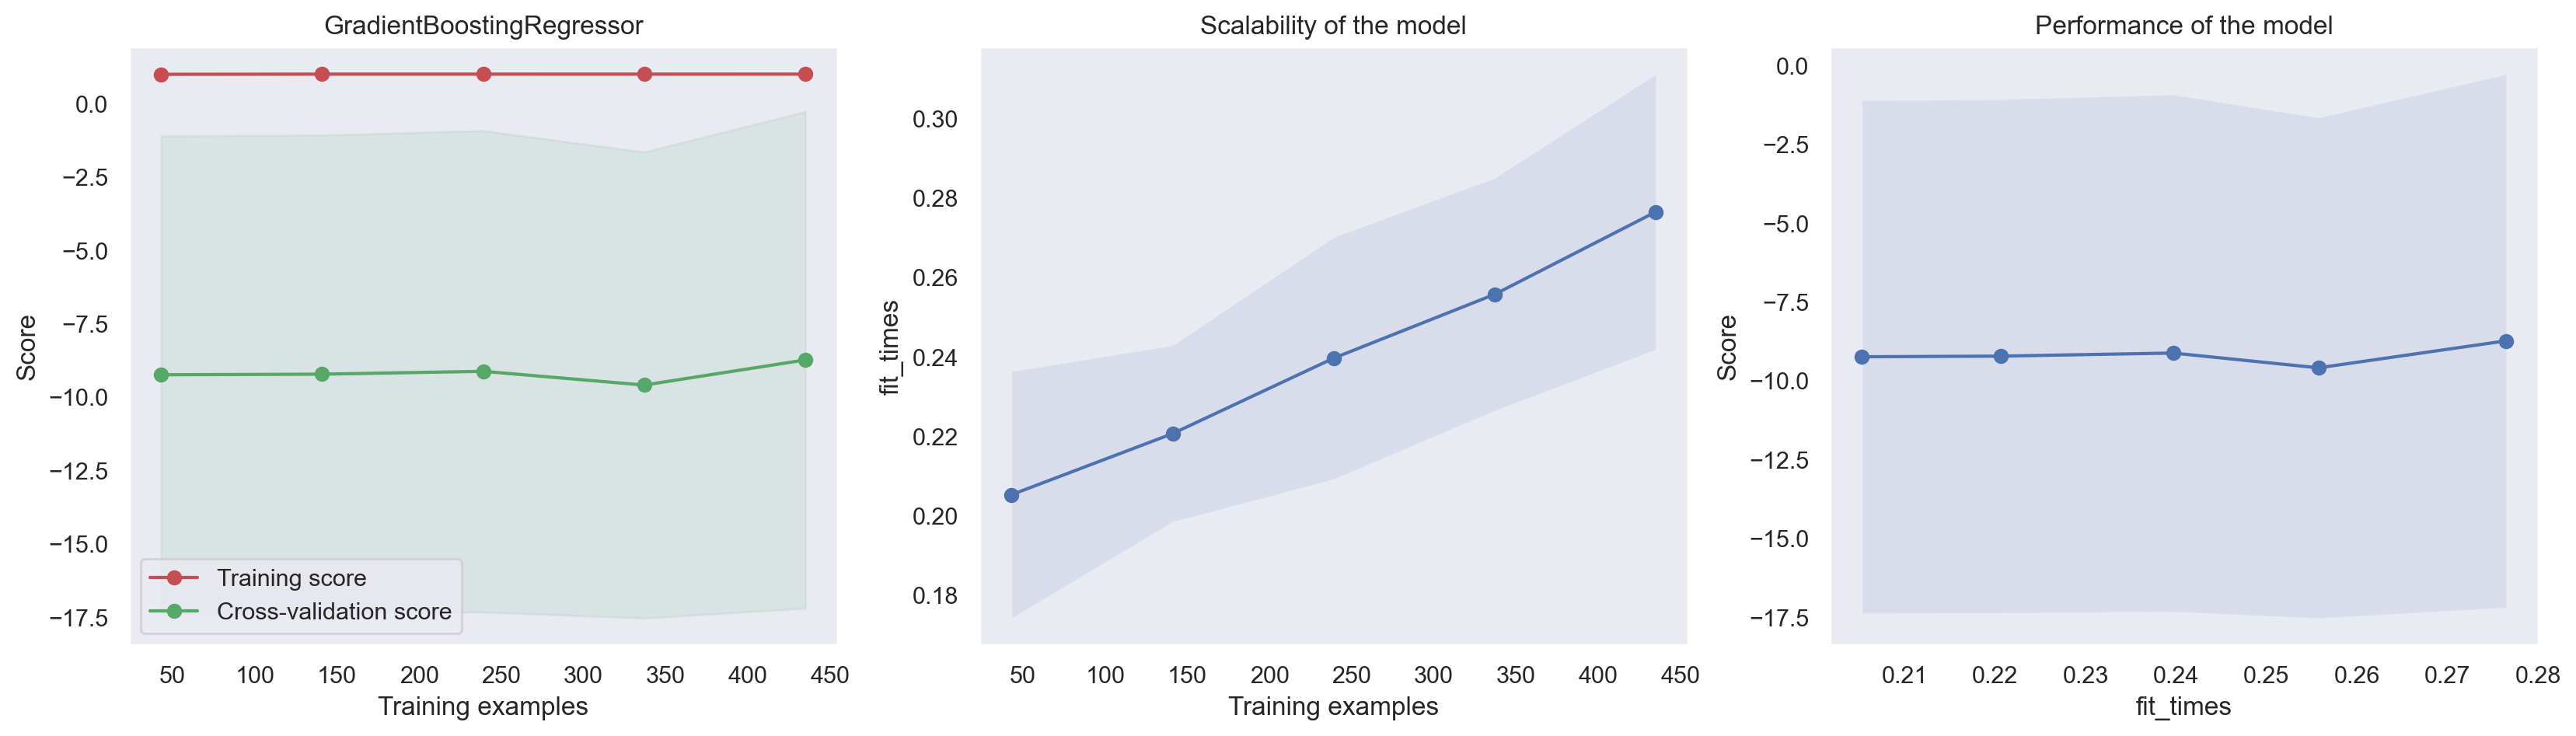

MLPRegressor: NEG_MAPE=-0.738887 (STD=0.180626) (R2=-0.392661)


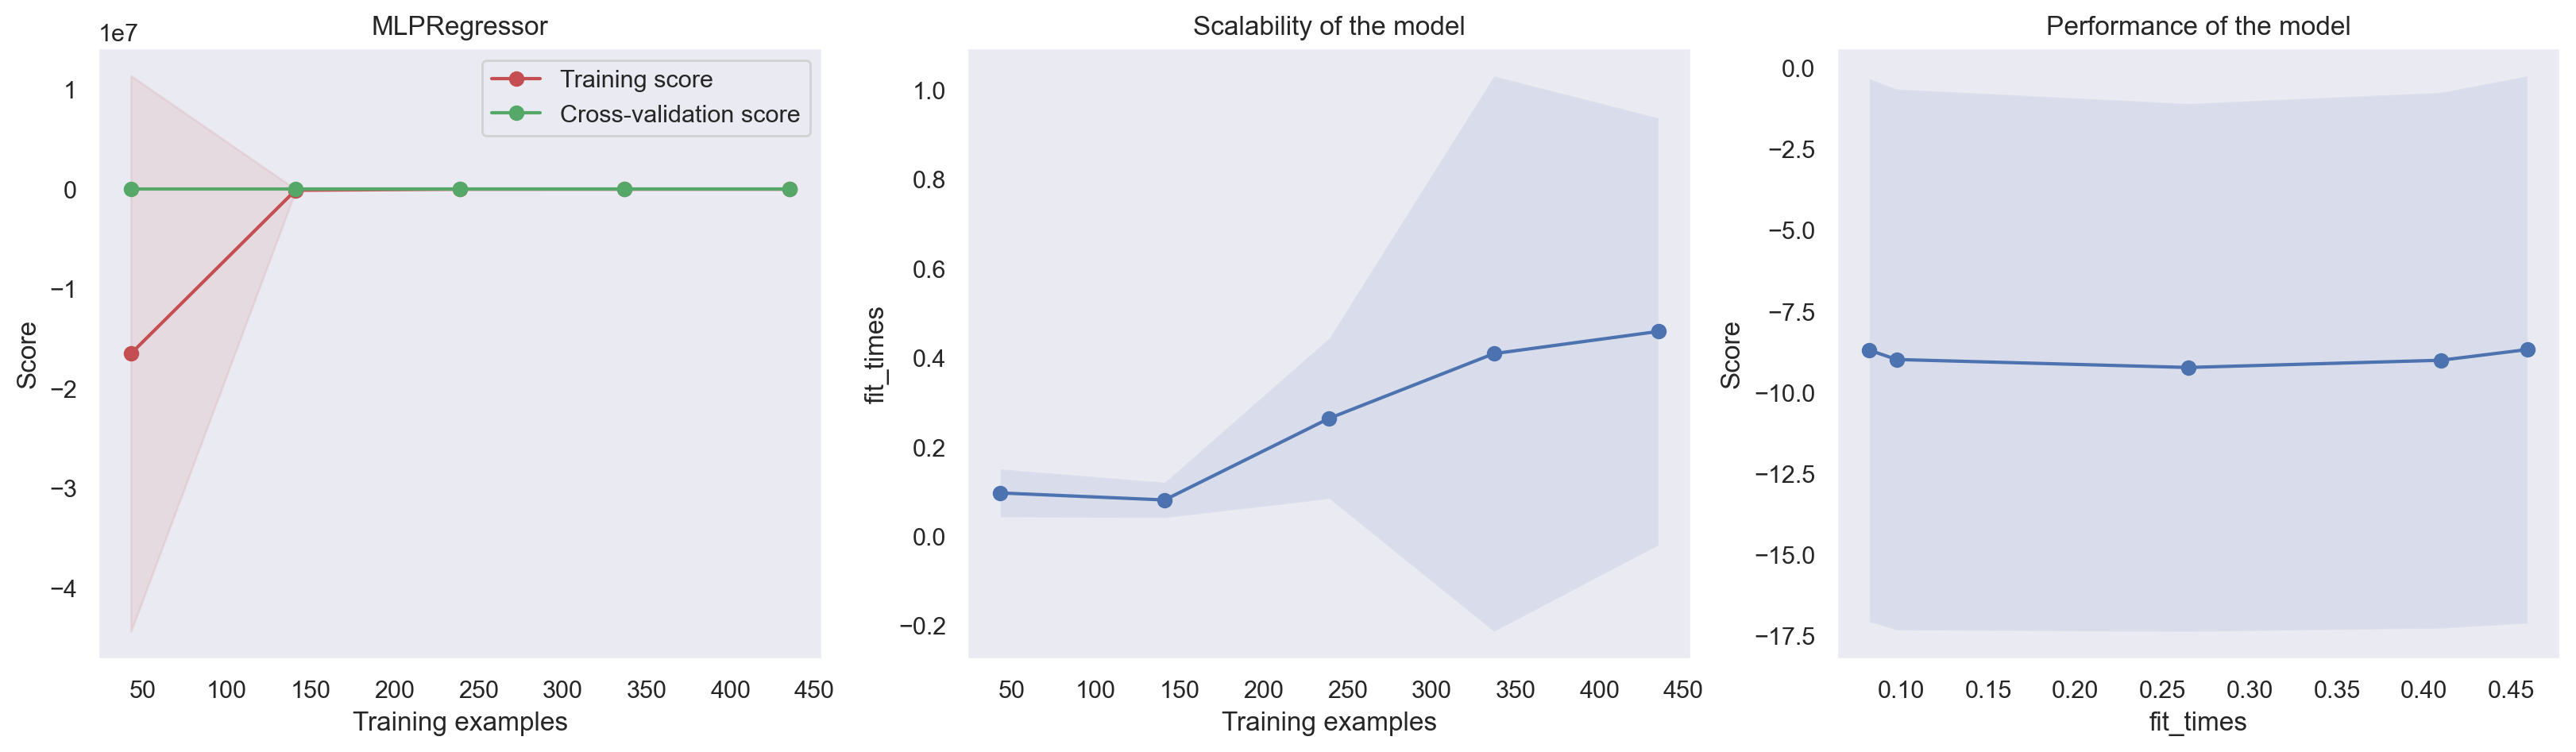

KNeighborsRegressor: NEG_MAPE=-0.526376 (STD=0.281038) (R2=0.999479)


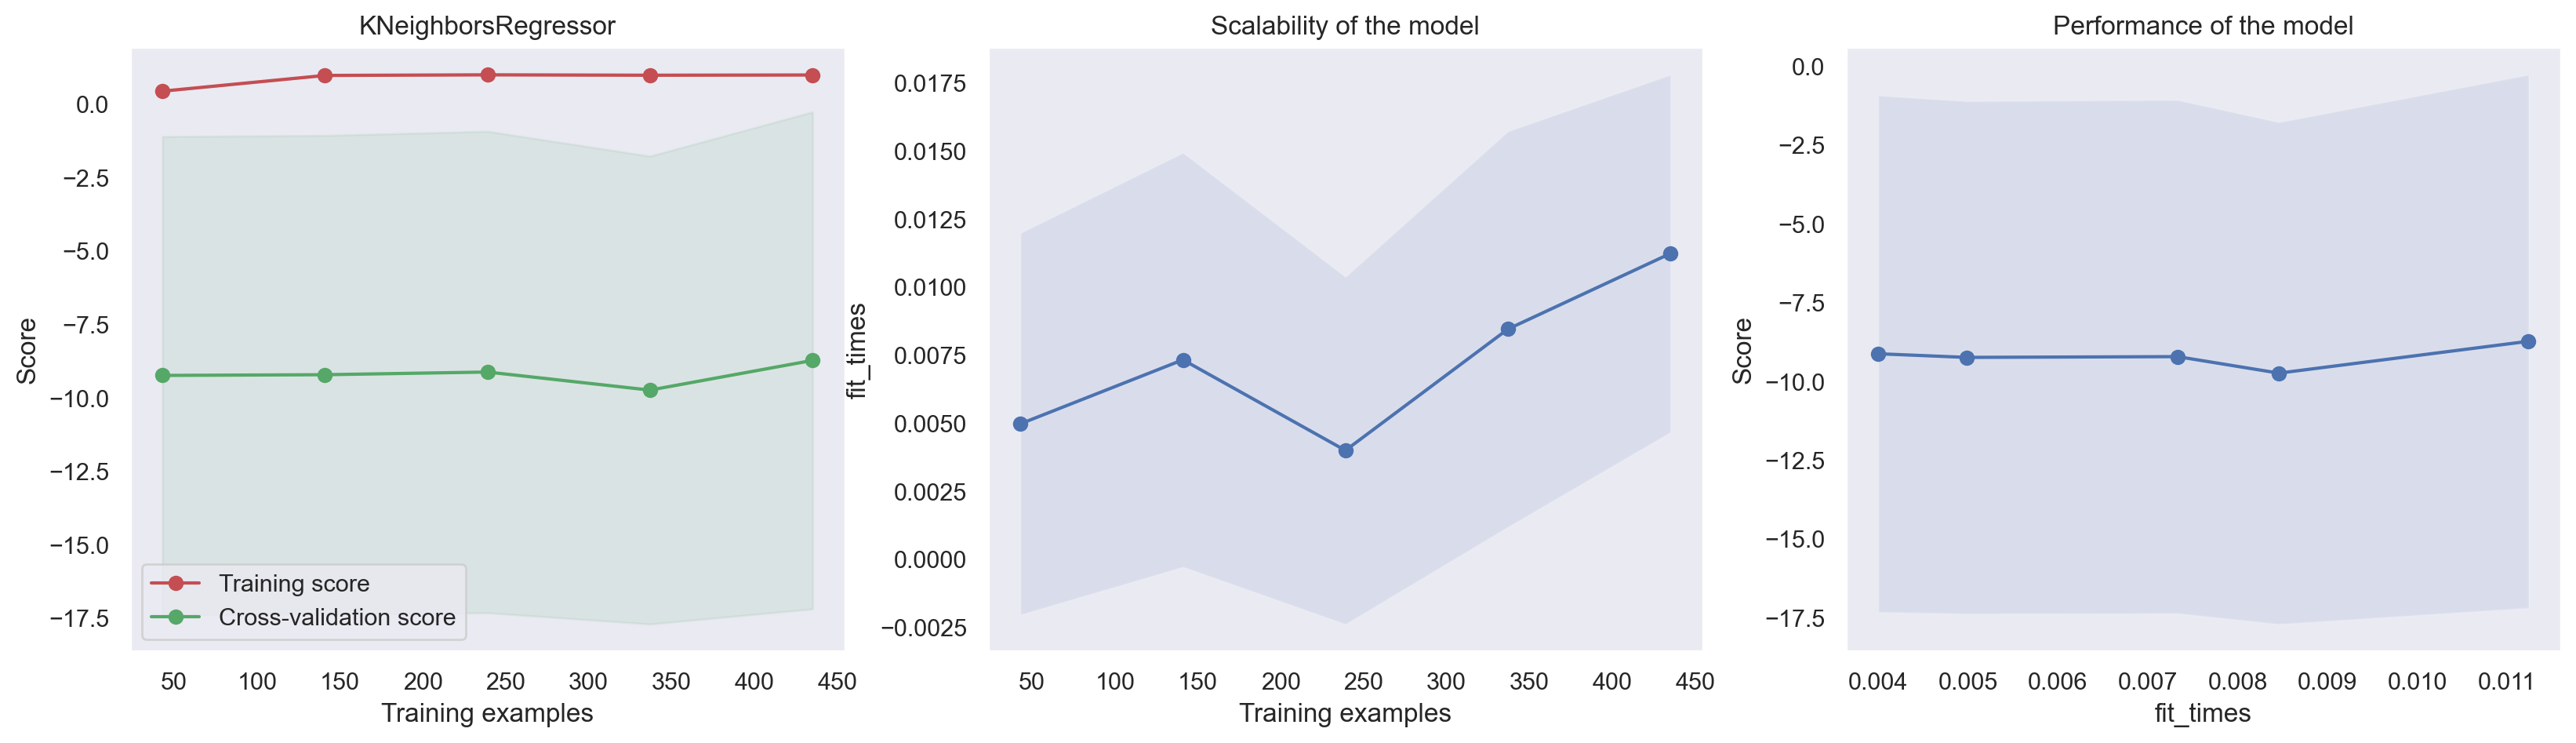

RandomForestRegressor: NEG_MAPE=-0.518616 (STD=0.275555) (R2=0.999858)


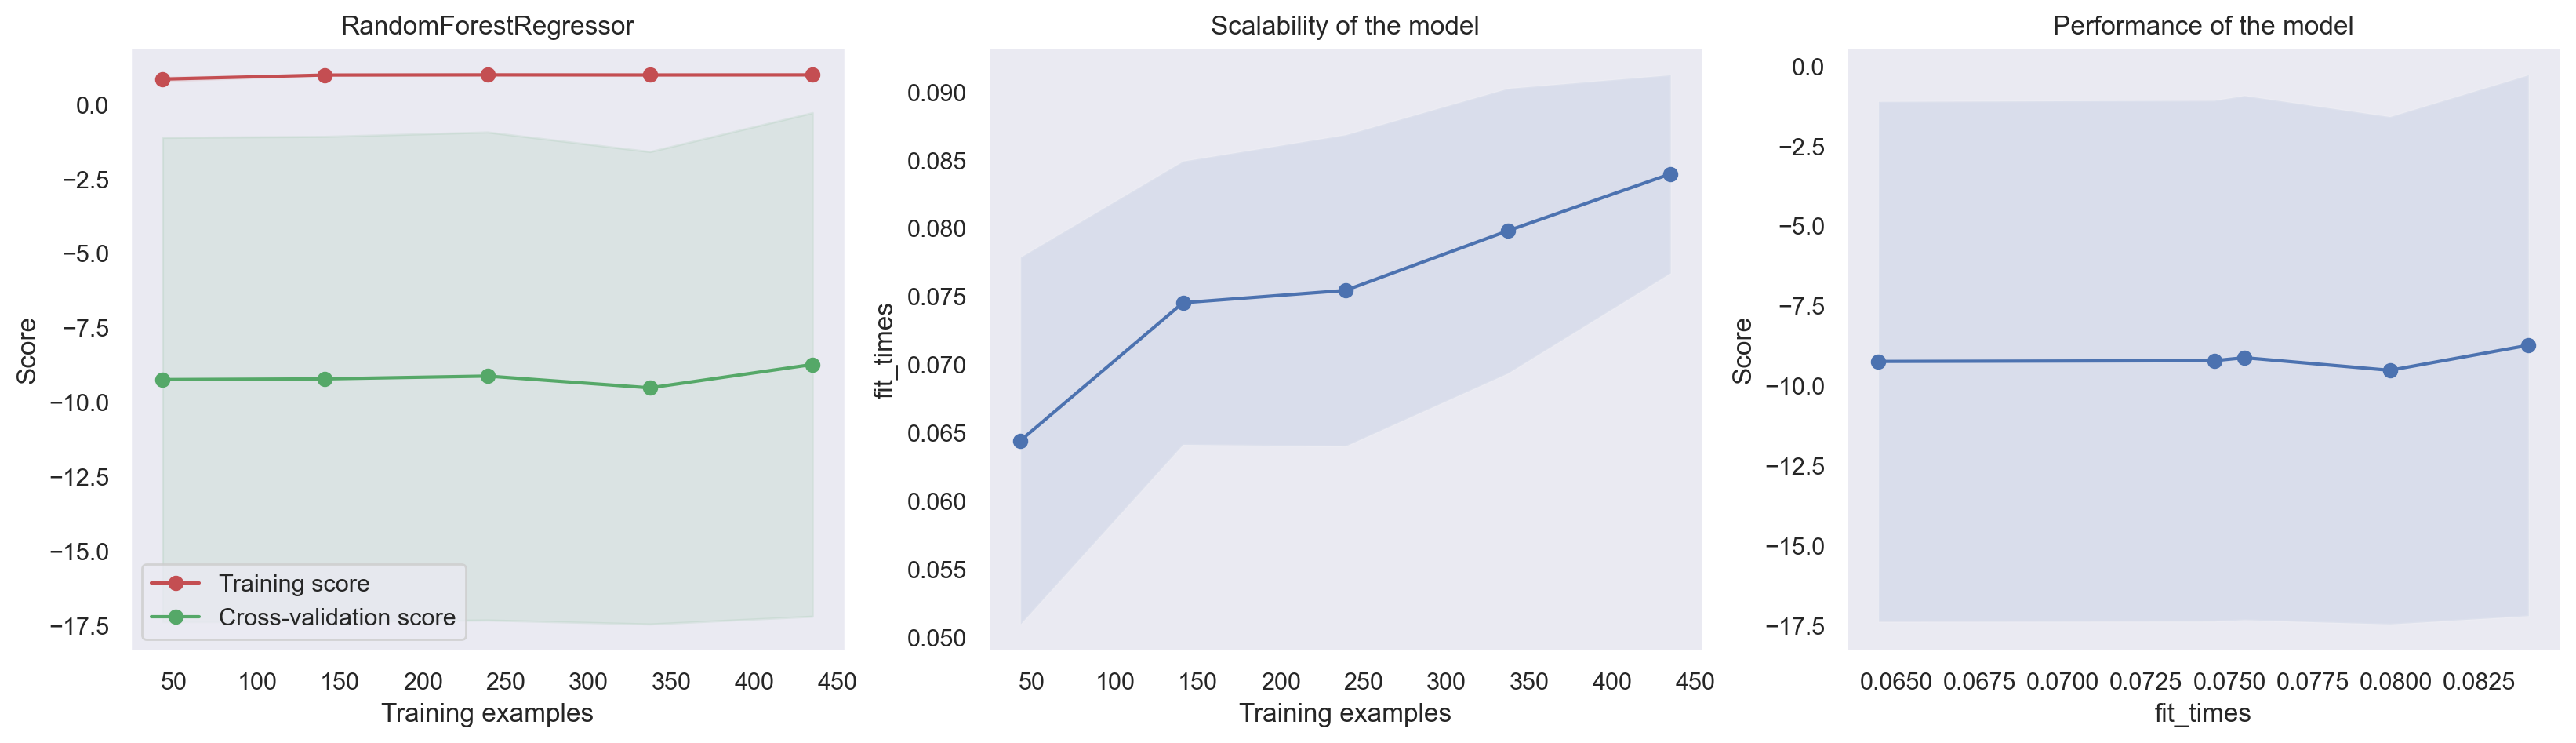

SVR: NEG_MAPE=-0.855316 (STD=0.196122) (R2=-0.253818)


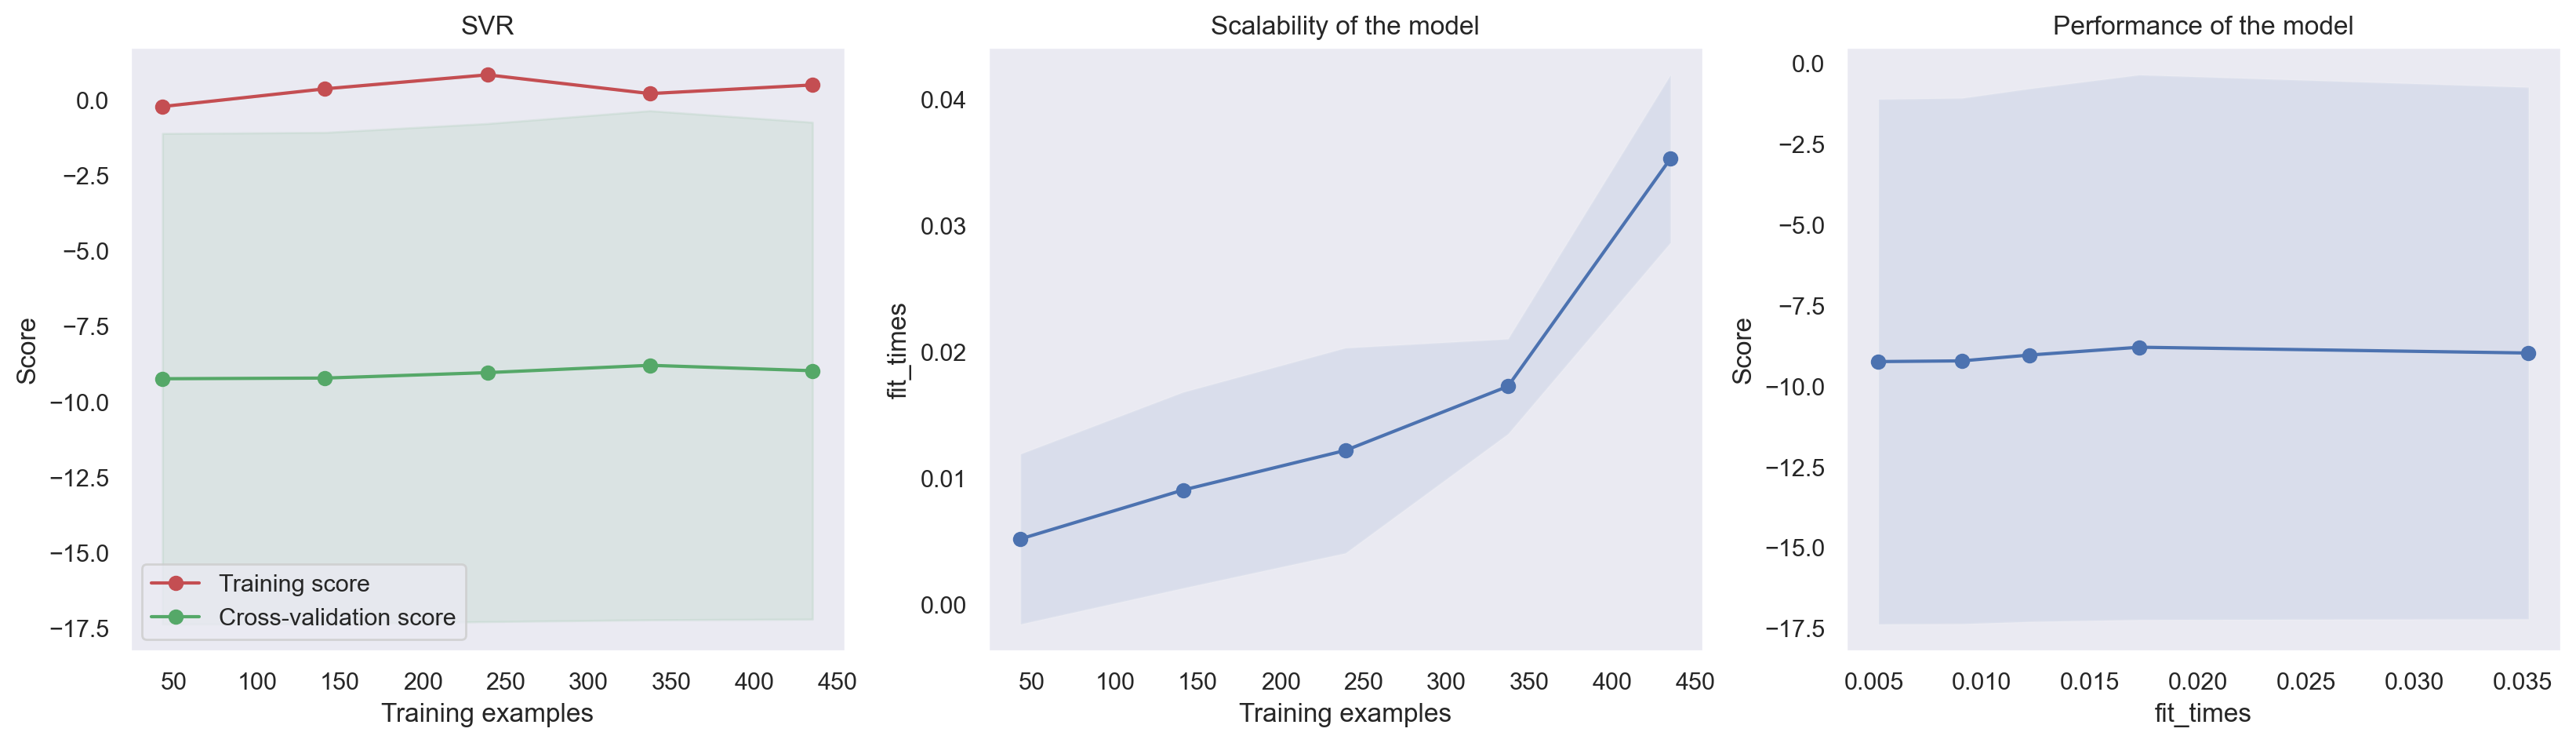

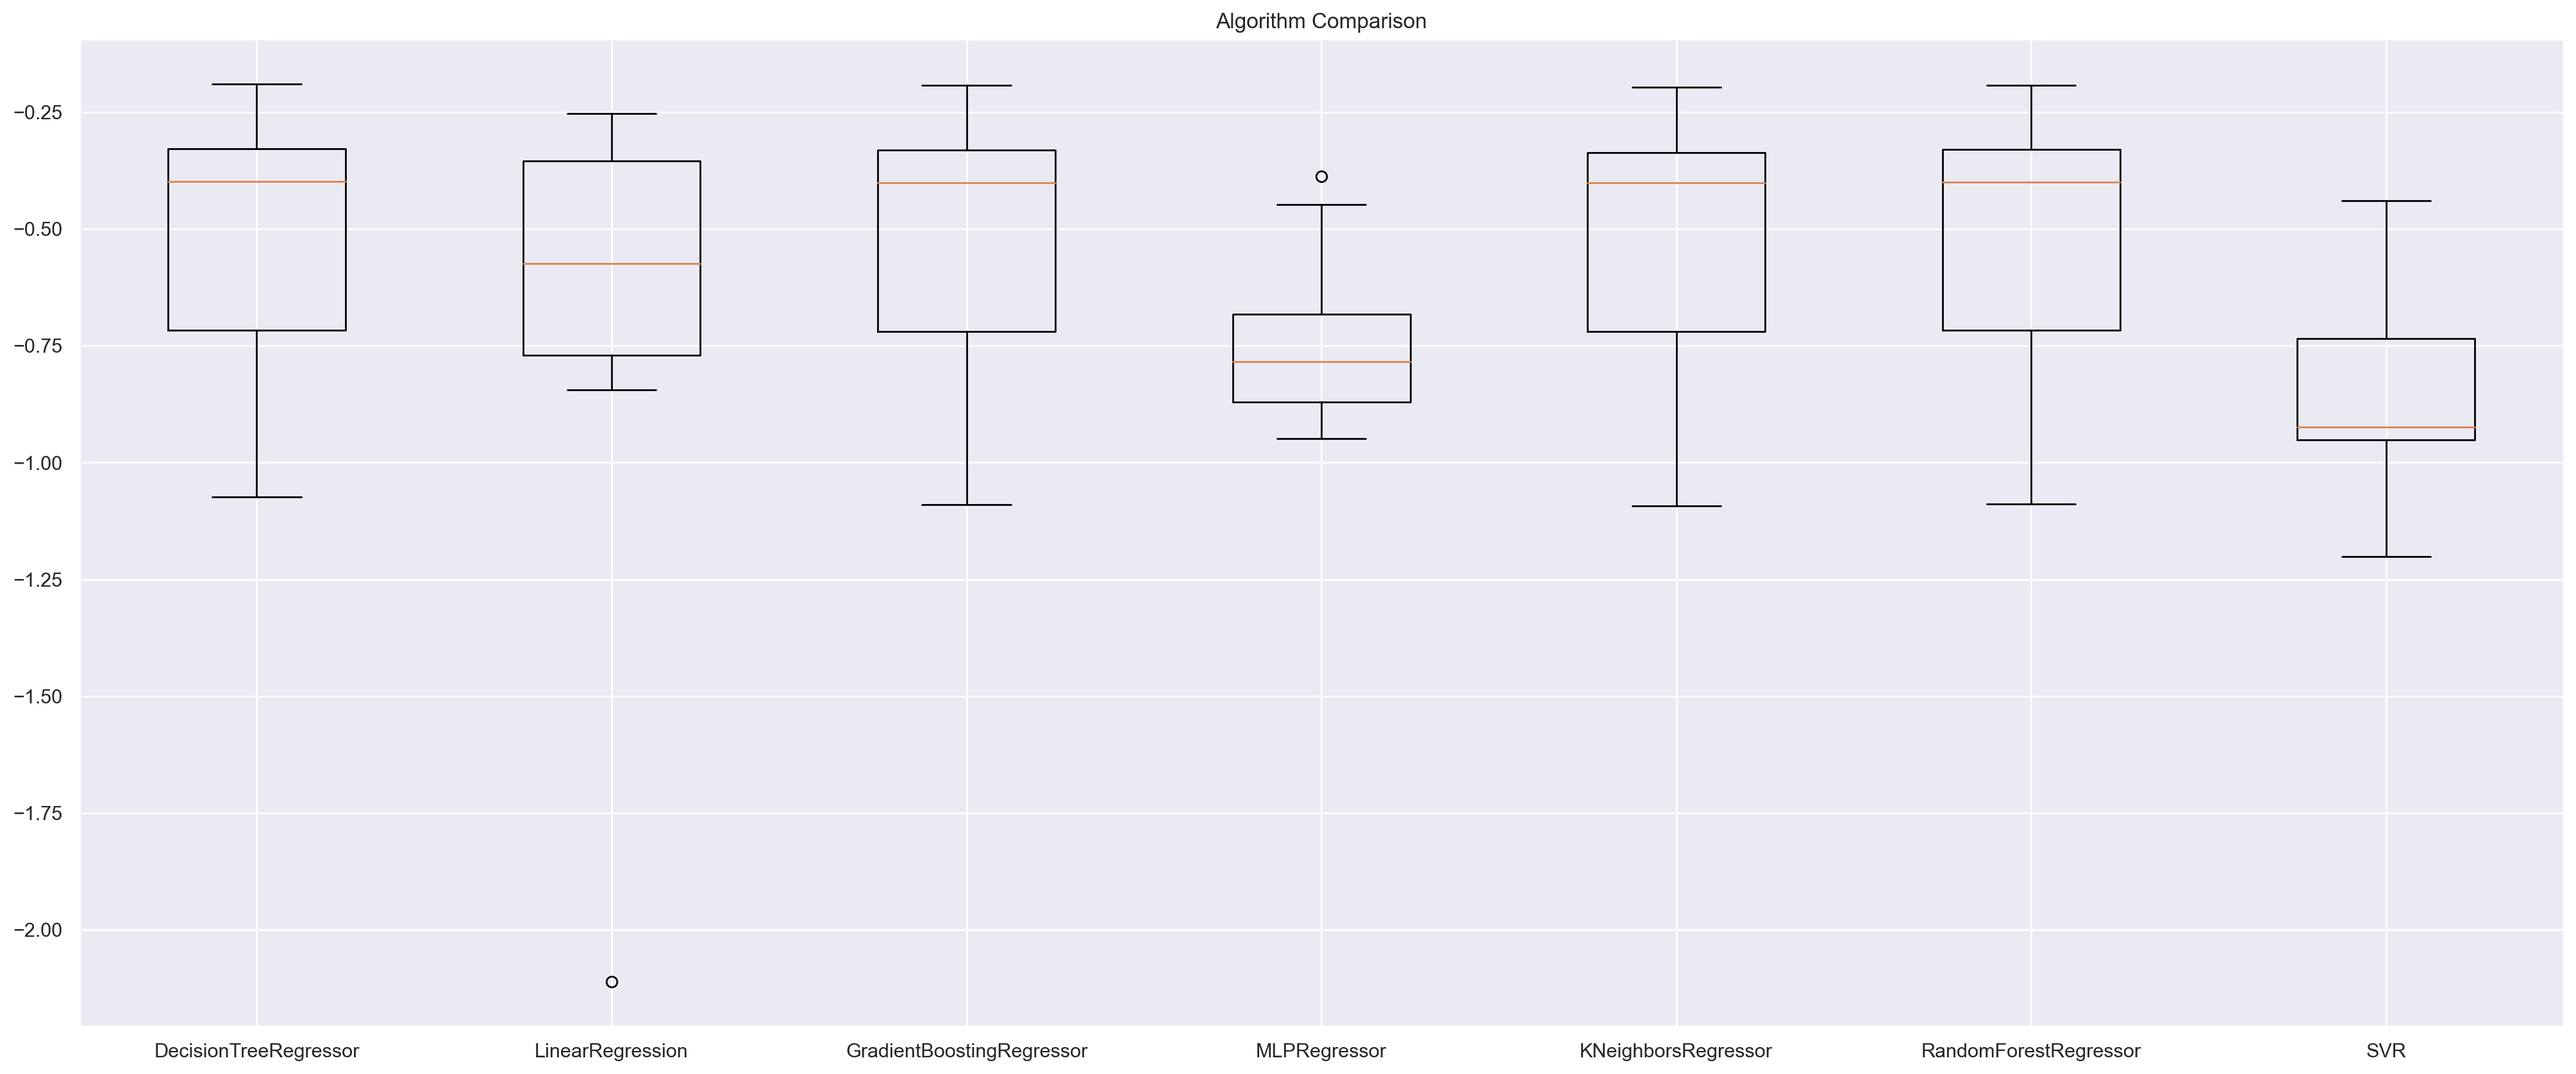

In [11]:
_models_score(df_formatted)

### Previous results are not good enough and the learning curves of the model suggest us there is a overfit.
### Next steps will be:
    1) study the seasonal trends and in case create new features for "lucky" periods (times with grow up and times with top price before a new price down)
    2) create new features shifting the Price 
    3) scaling features 
    4) resample dataset into weekly data to have weekly previsions

#

# 1) Decomposition

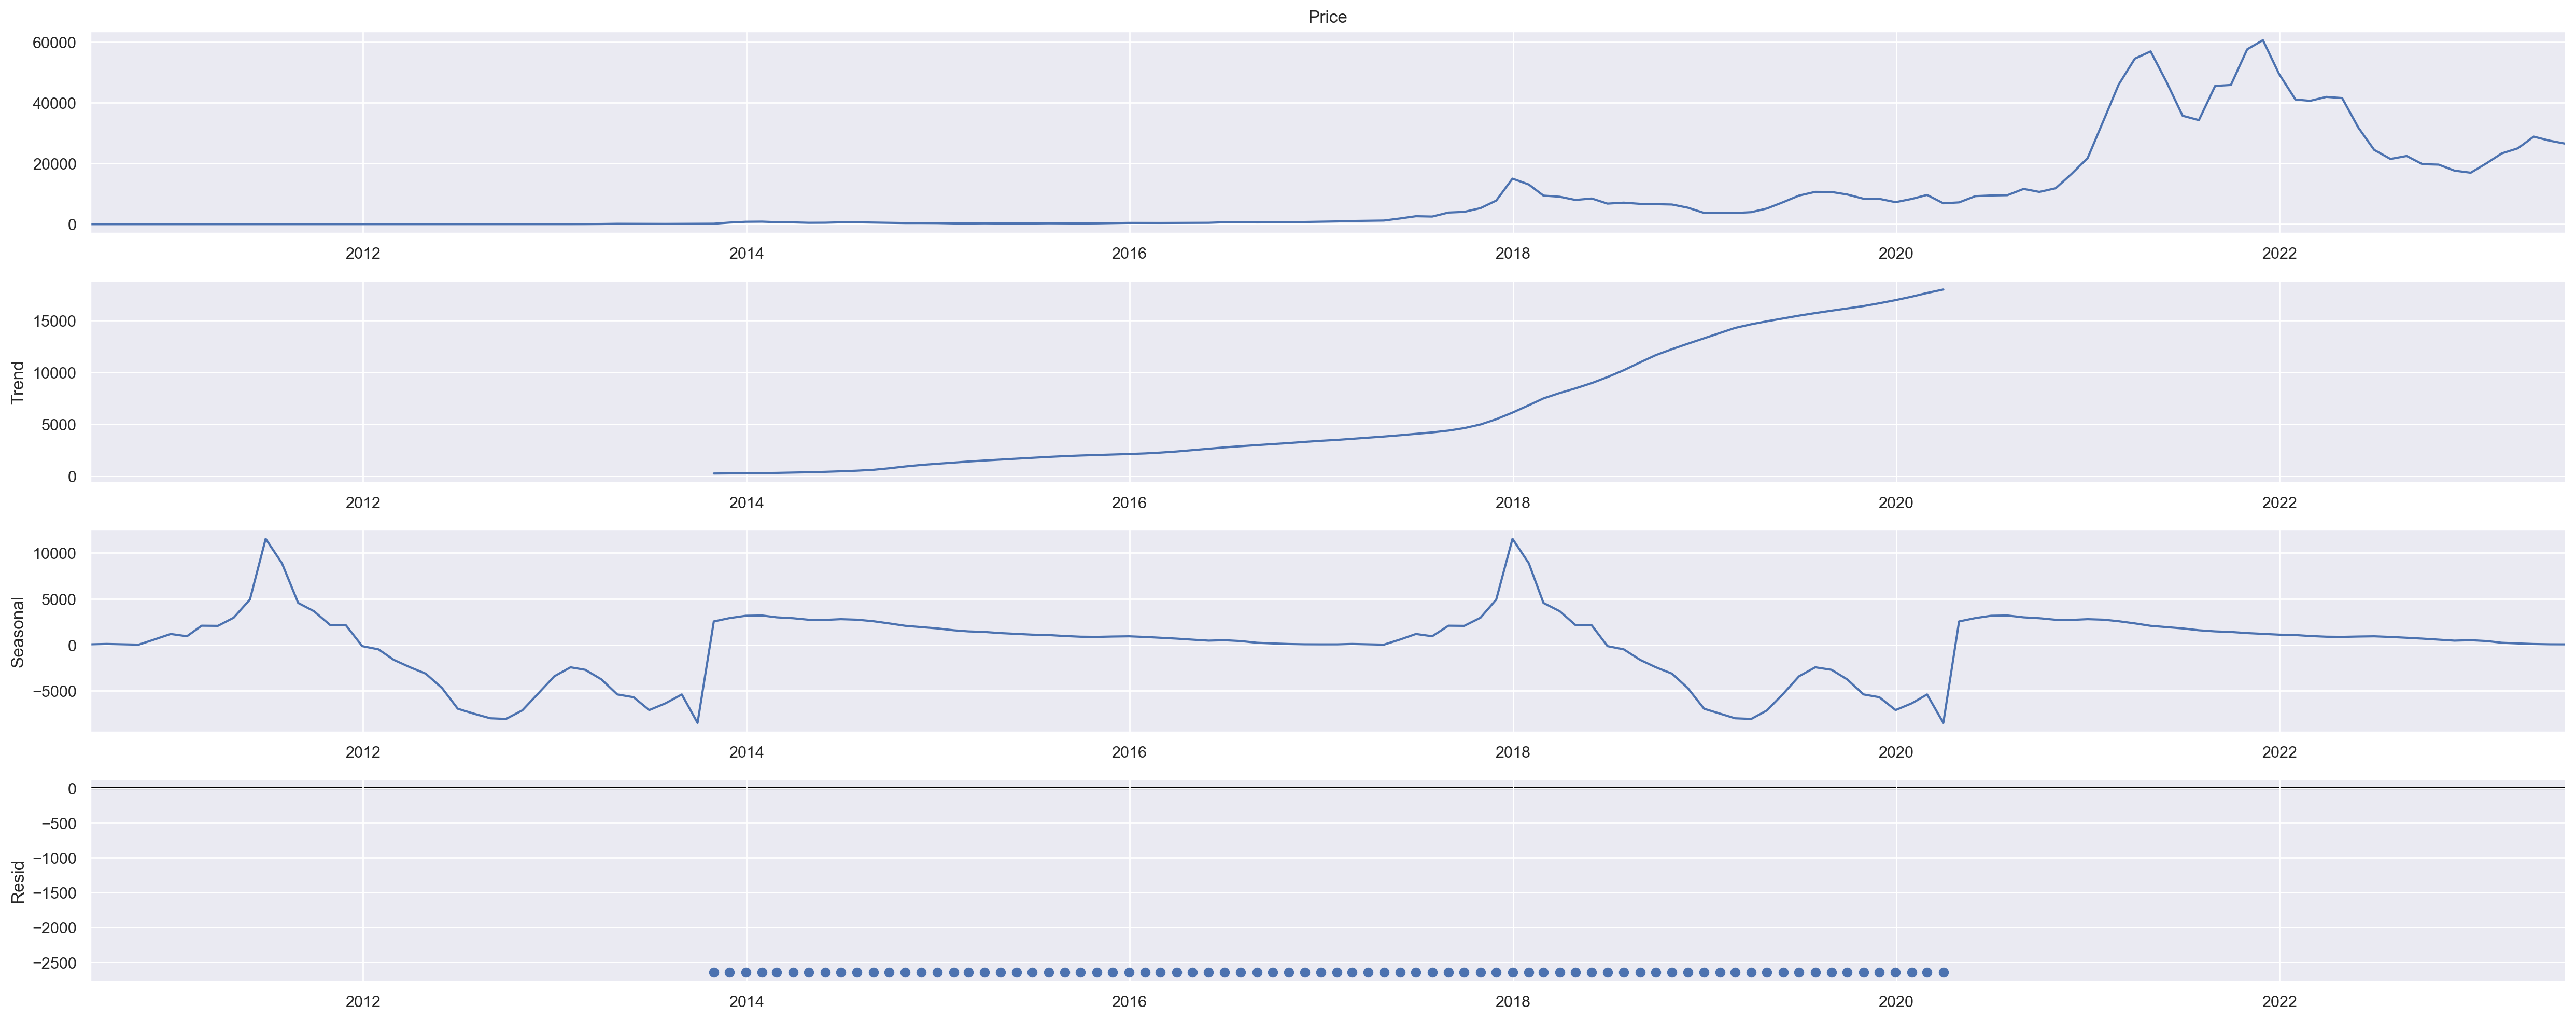

In [12]:
# Find decomposition using original dataset
df_train = df_train.sort_index()

decomposition = seasonal_decompose(df_train['Price'].resample('M').mean().fillna(method='ffill'), period=78)

plot = decomposition.plot()

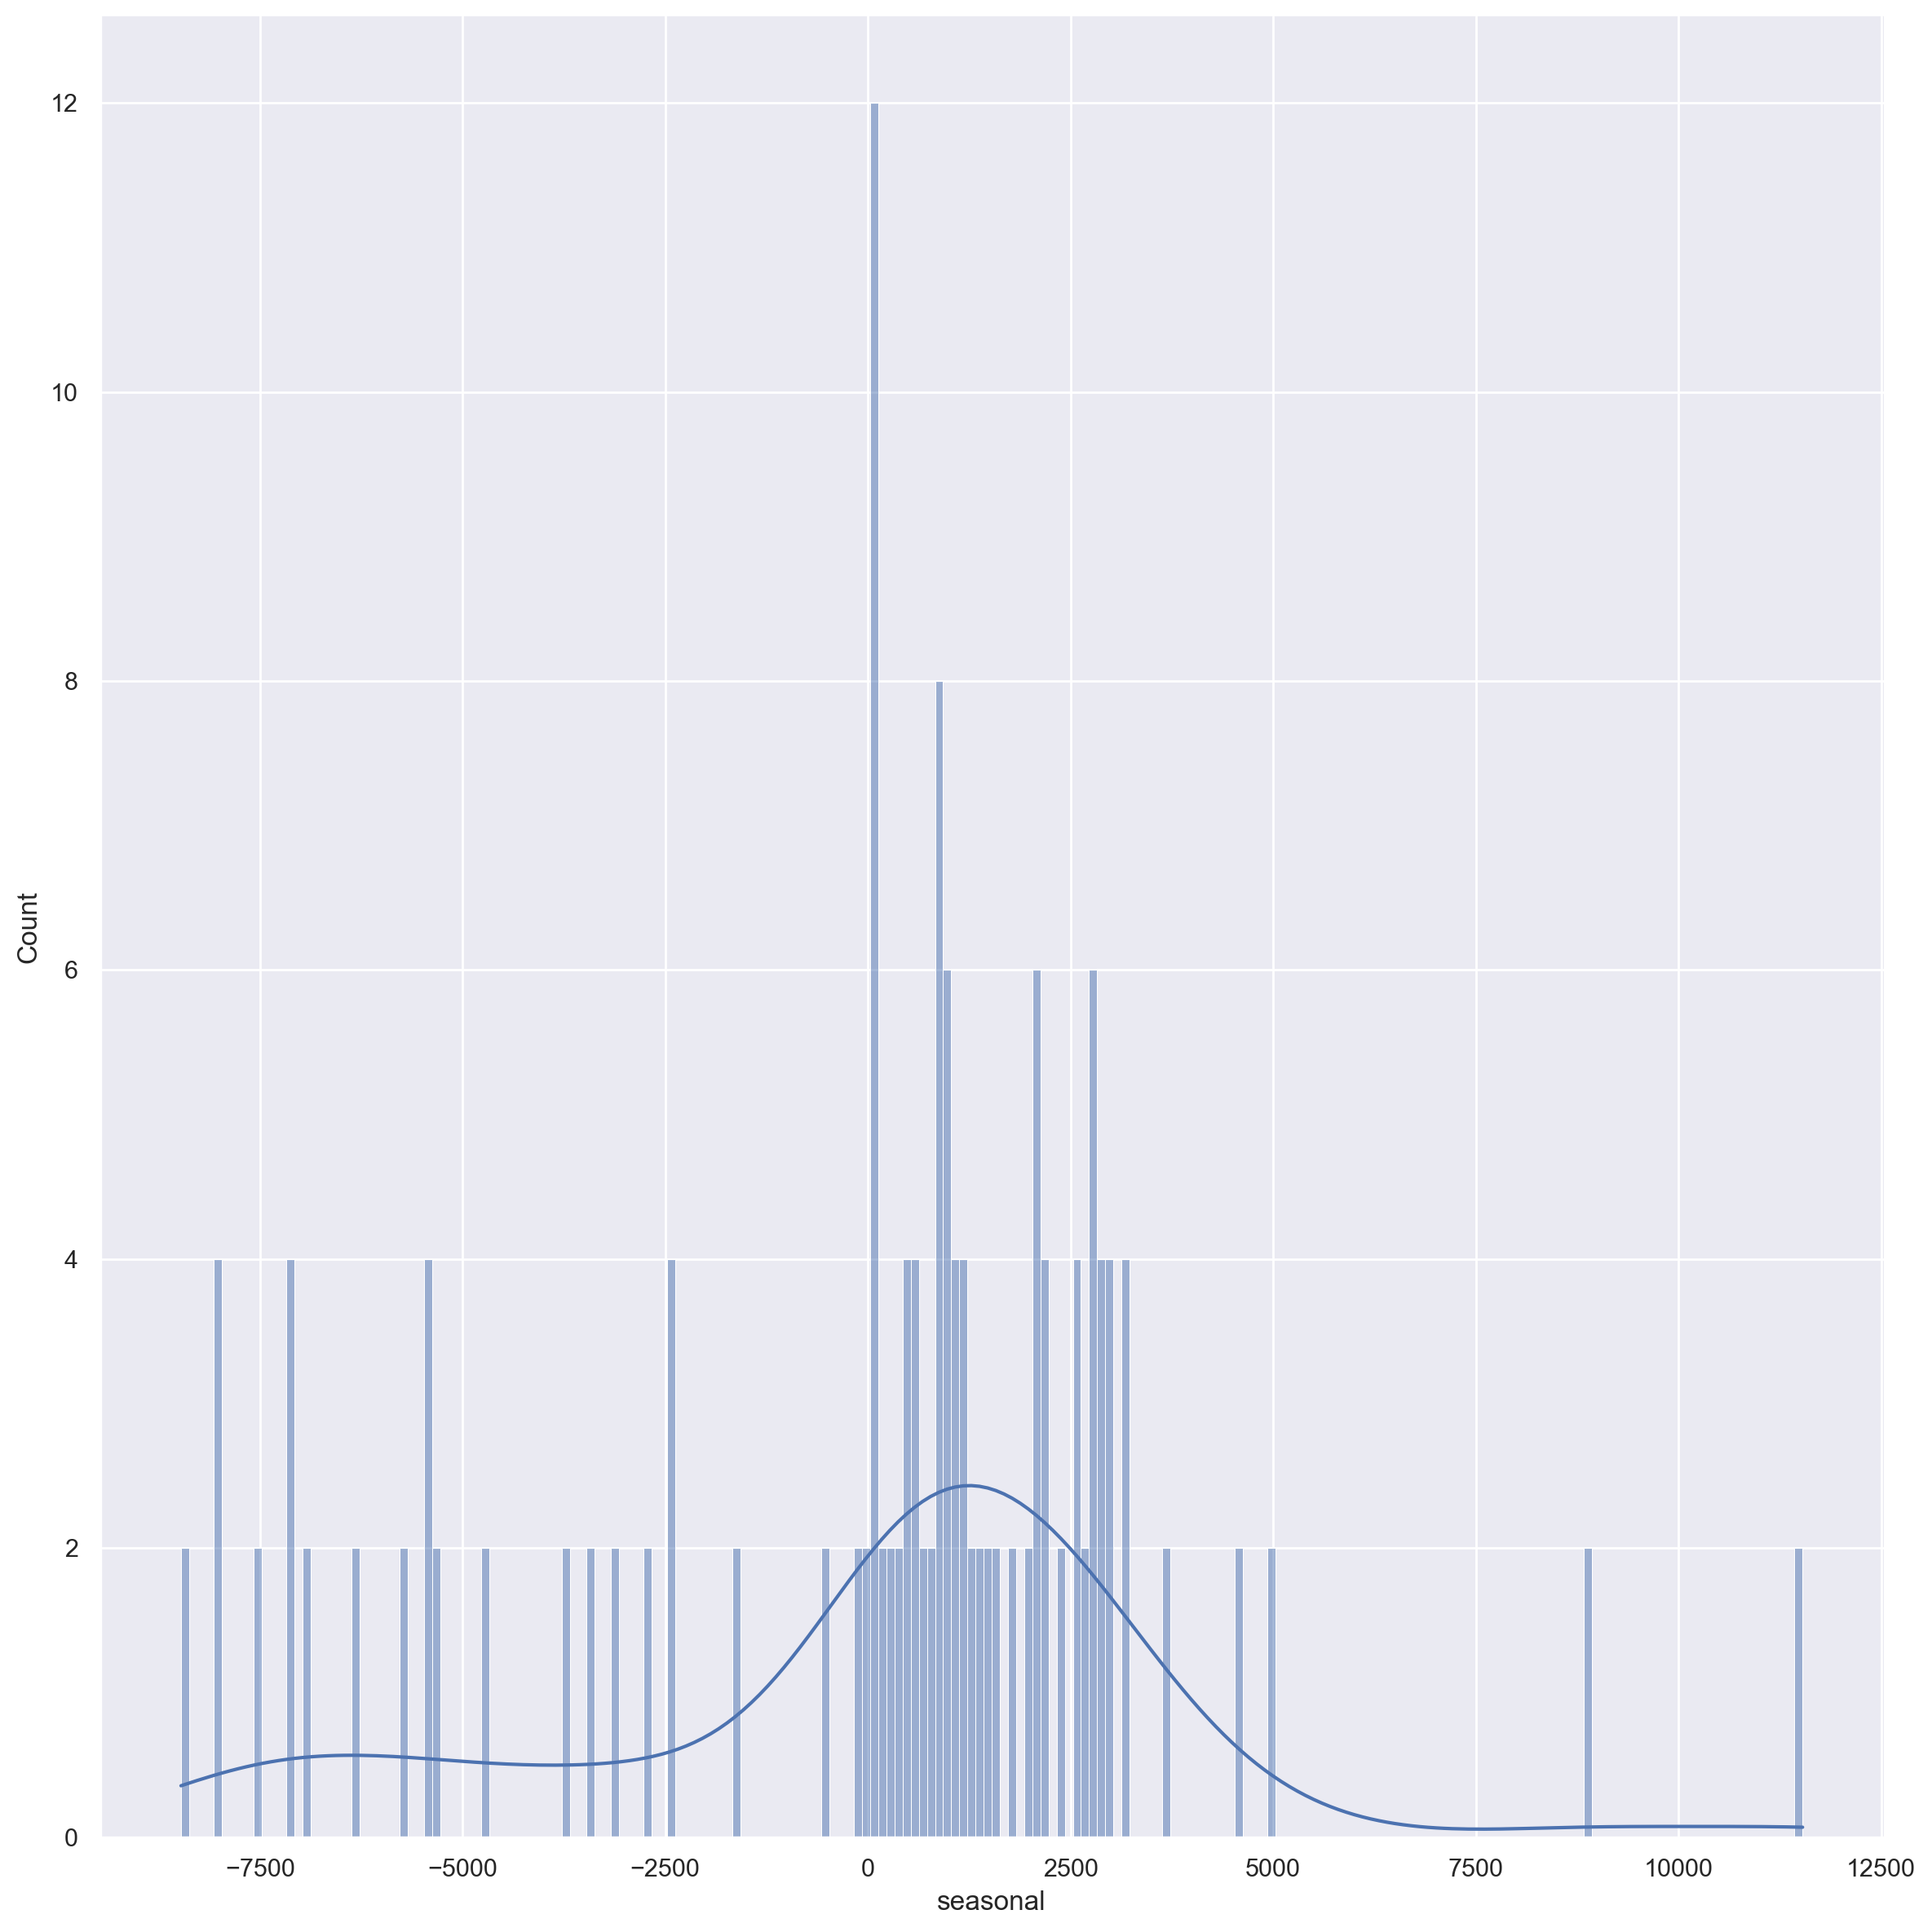

In [13]:
# Seasonal distribution

sns.displot(decomposition.seasonal, bins=200, kde=True, height=12);

### The seasonality suggest us that about every 6 years the price go up : at the end of 2013, and in the start of 2020
### BTW, every 4 years and some months from the previous grow, there is the top point price. For example after the price increment of the end of 2013, we have the top price at start of 2018, before it goes down another time. So we can expect that calculating from the 2020 increment, we will have the start of 2024 as the time of top price, before it will goes down another time.

In [14]:
#TODO CREATE NEW FEATURES FOR TOP_PRICE PERIODS & PRICE_DOWN PERIODS

#

# 2) Shifting

In [15]:
def _get_shifted_dataset(df):
    
    # Shift actual price of 1 day to track yesterday price for each date
    df['Yesterday_Price'] = df['Price'].shift()
    # Calculate the difference between actual price and yesterday price to track the change
    df['Yesterday_Diff'] = df['Yesterday_Price'].diff()
    # Fill NaN with 0 because the NaN values refer to days before Bitcoin was launched 
    df = df.fillna(0)
    # Show actual dataset
    display(df)
    return df

In [16]:
df_formatted = _get_shifted_dataset(df_formatted)

Price   Date_float  Yesterday_Price  Yesterday_Diff
4714      0.0500  2010.539726           0.0000          0.0000
4713      0.0858  2010.542466           0.0500          0.0000
4712      0.0808  2010.545205           0.0858          0.0358
4711      0.0747  2010.547945           0.0808         -0.0050
4710      0.0792  2010.550685           0.0747         -0.0061
...          ...          ...              ...             ...
4     26546.0950  2023.435616       26498.9450       -229.9850
3     25996.2050  2023.438356       26546.0950         47.1500
2     25912.2150  2023.441096       25996.2050       -549.8900
1     25872.2800  2023.443836       25912.2150        -83.9900
0     26030.0600  2023.446575       25872.2800        -39.9350

[4715 rows x 4 columns]

DecisionTreeRegressor: NEG_MAPE=-0.293548 (STD=0.252296) (R2=1.000000)


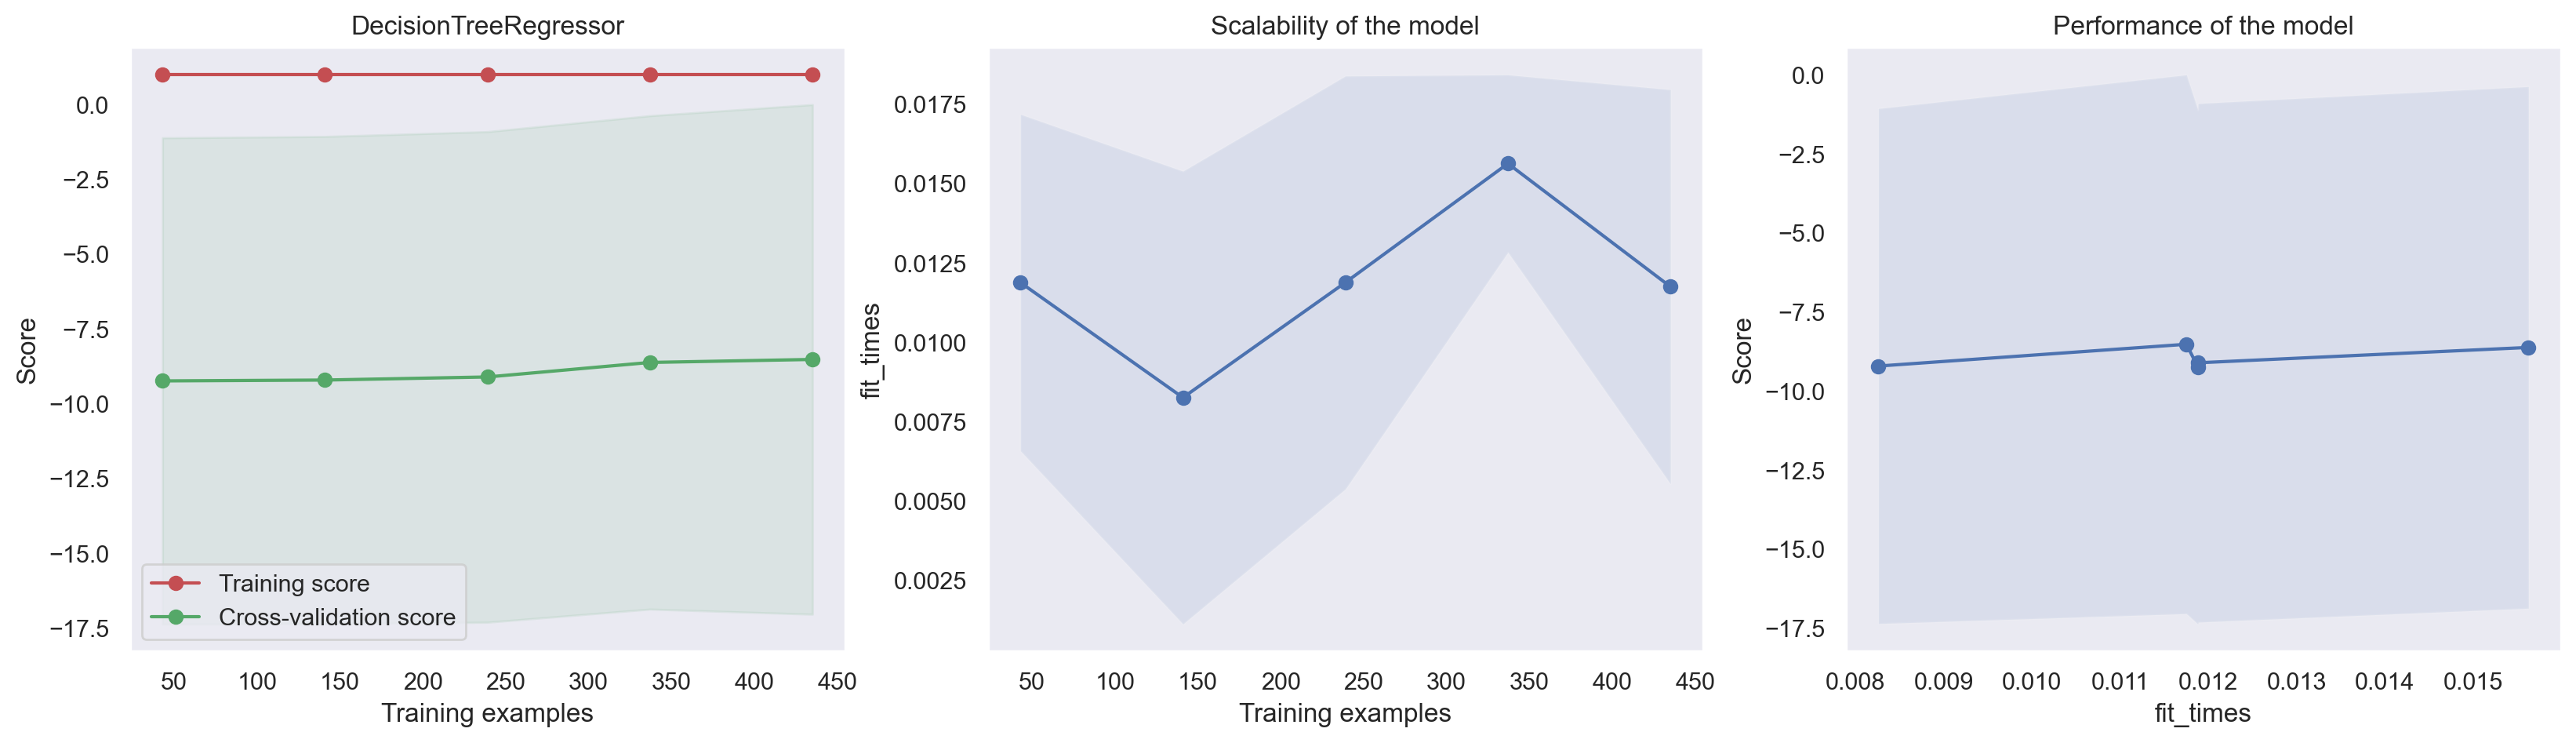

LinearRegression: NEG_MAPE=-0.026137 (STD=0.012836) (R2=0.998797)


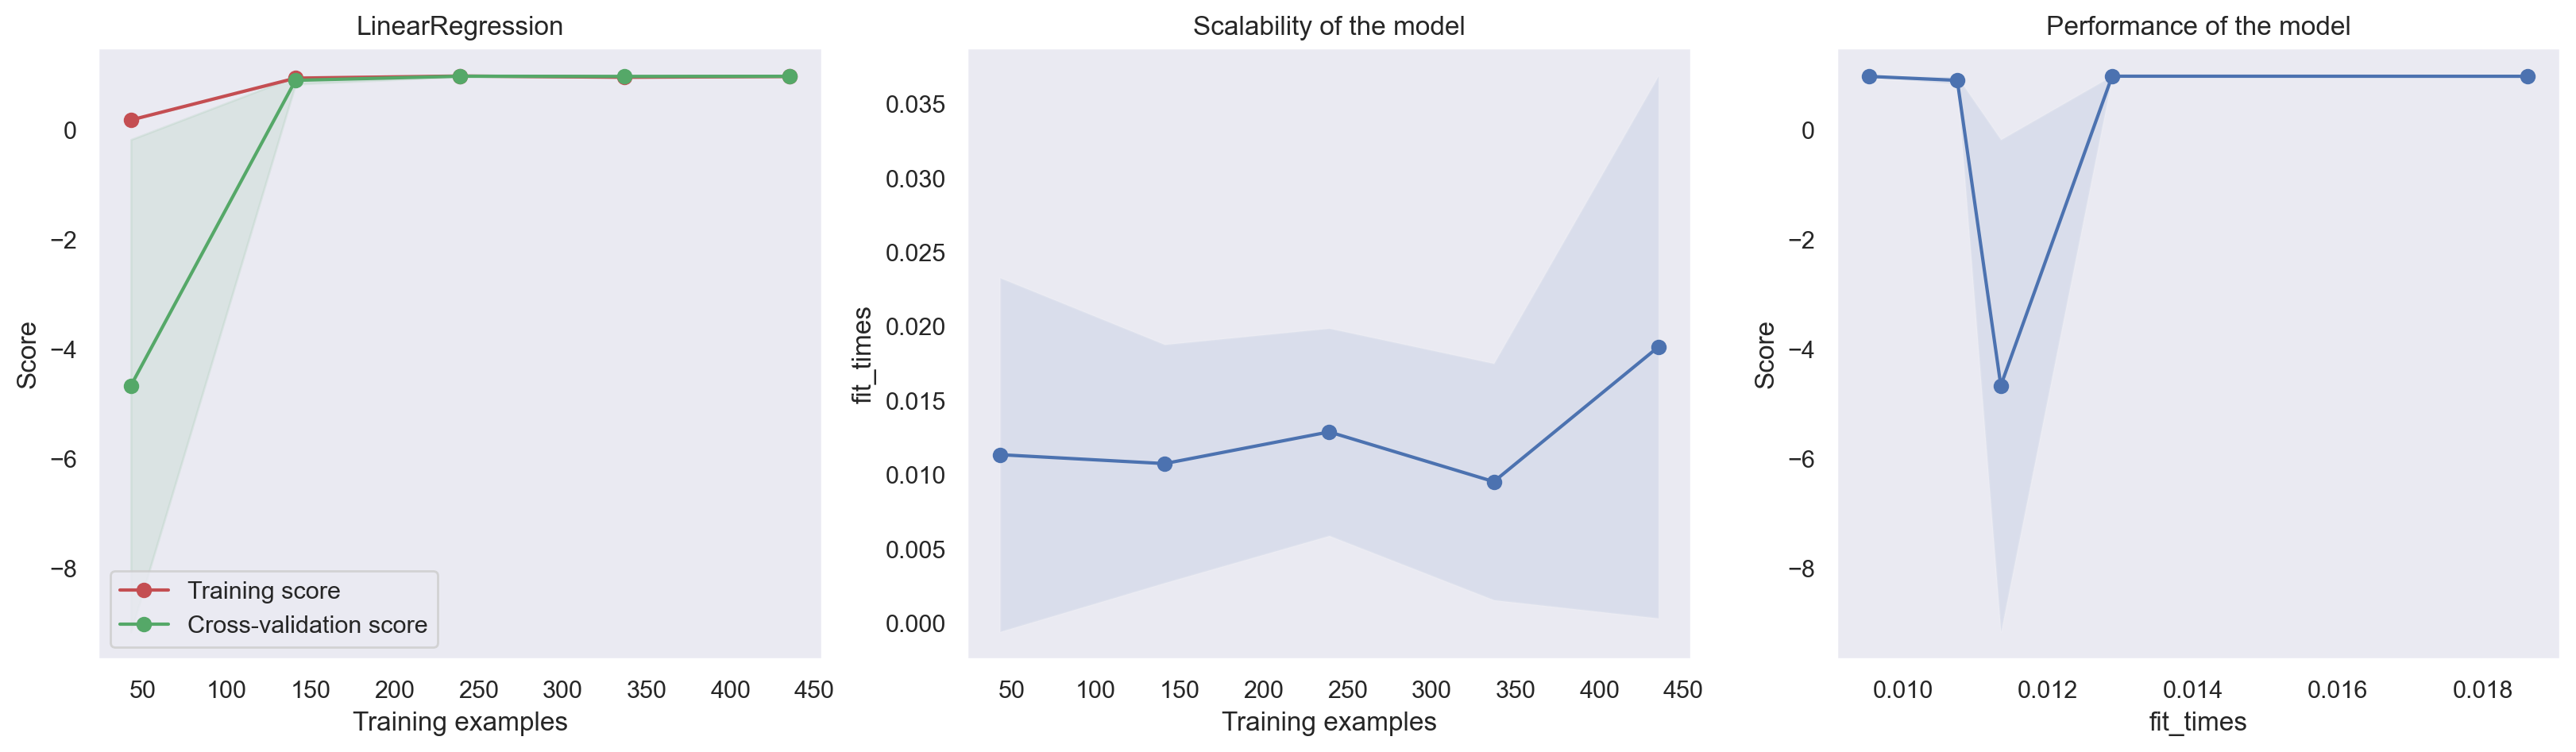

GradientBoostingRegressor: NEG_MAPE=-0.271470 (STD=0.212312) (R2=0.999286)


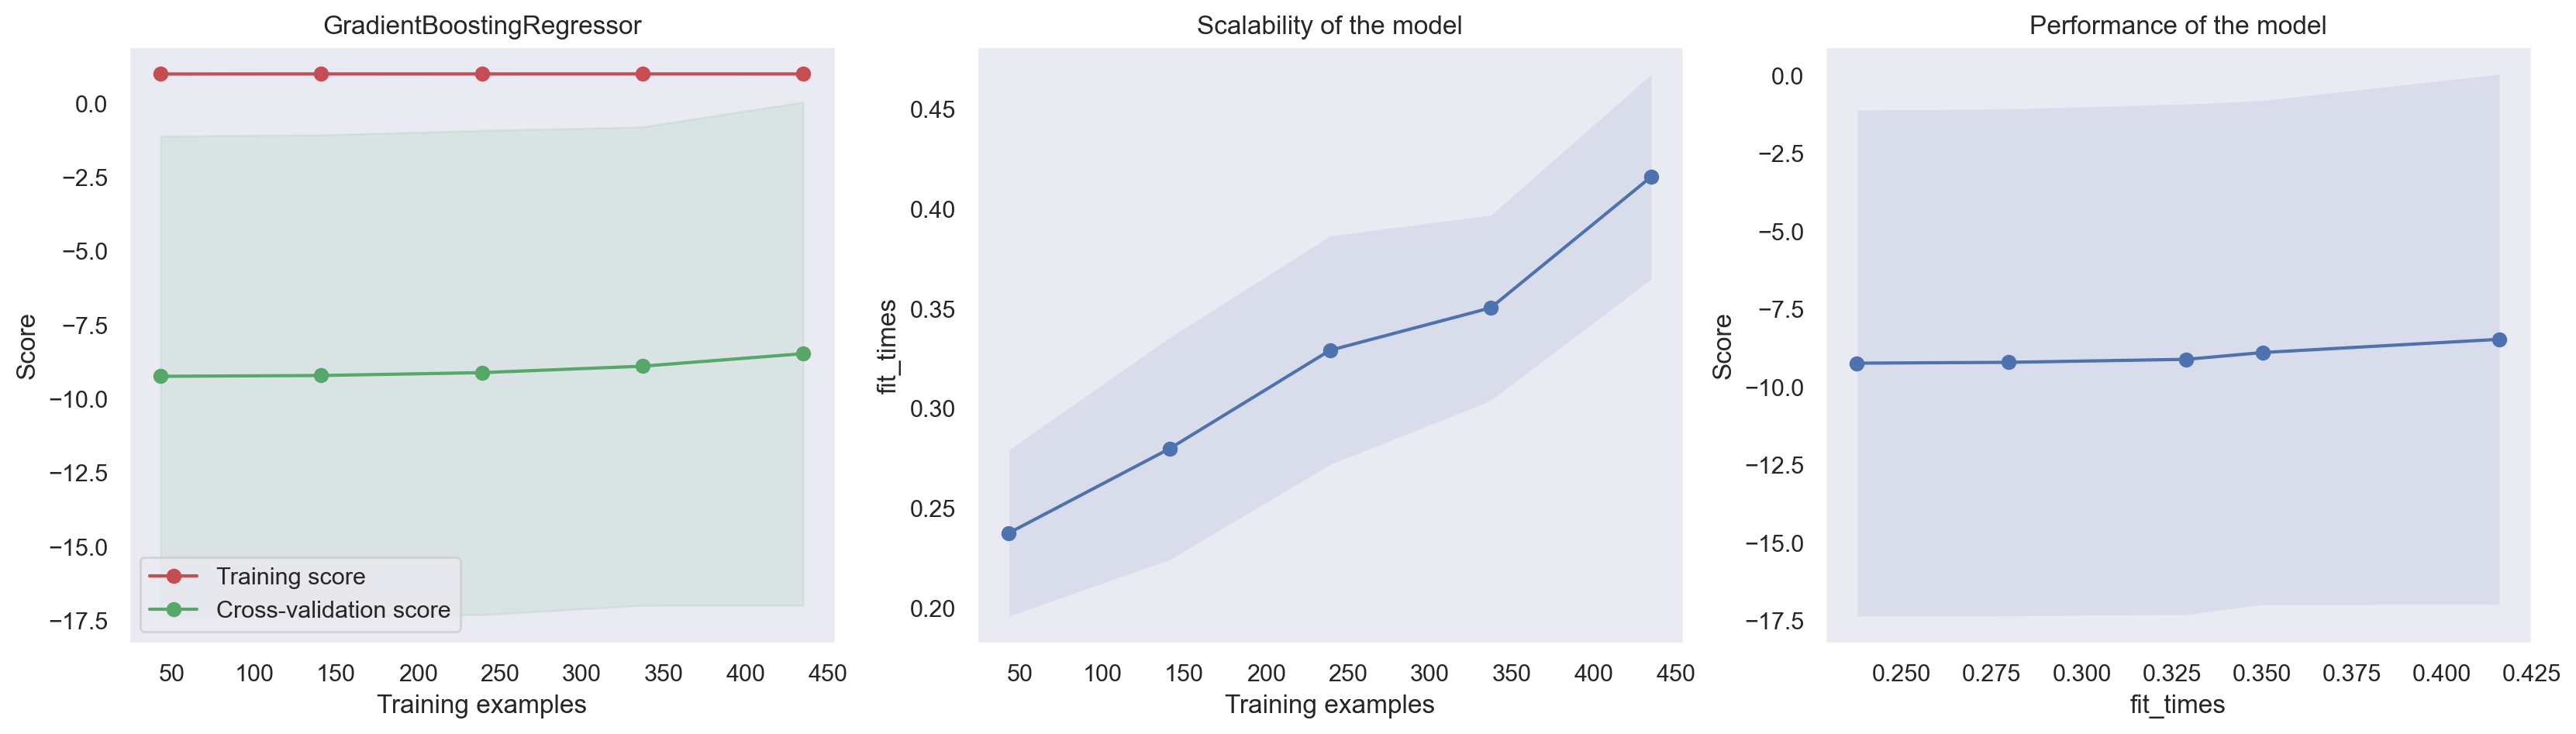

MLPRegressor: NEG_MAPE=-0.037208 (STD=0.023210) (R2=0.998782)


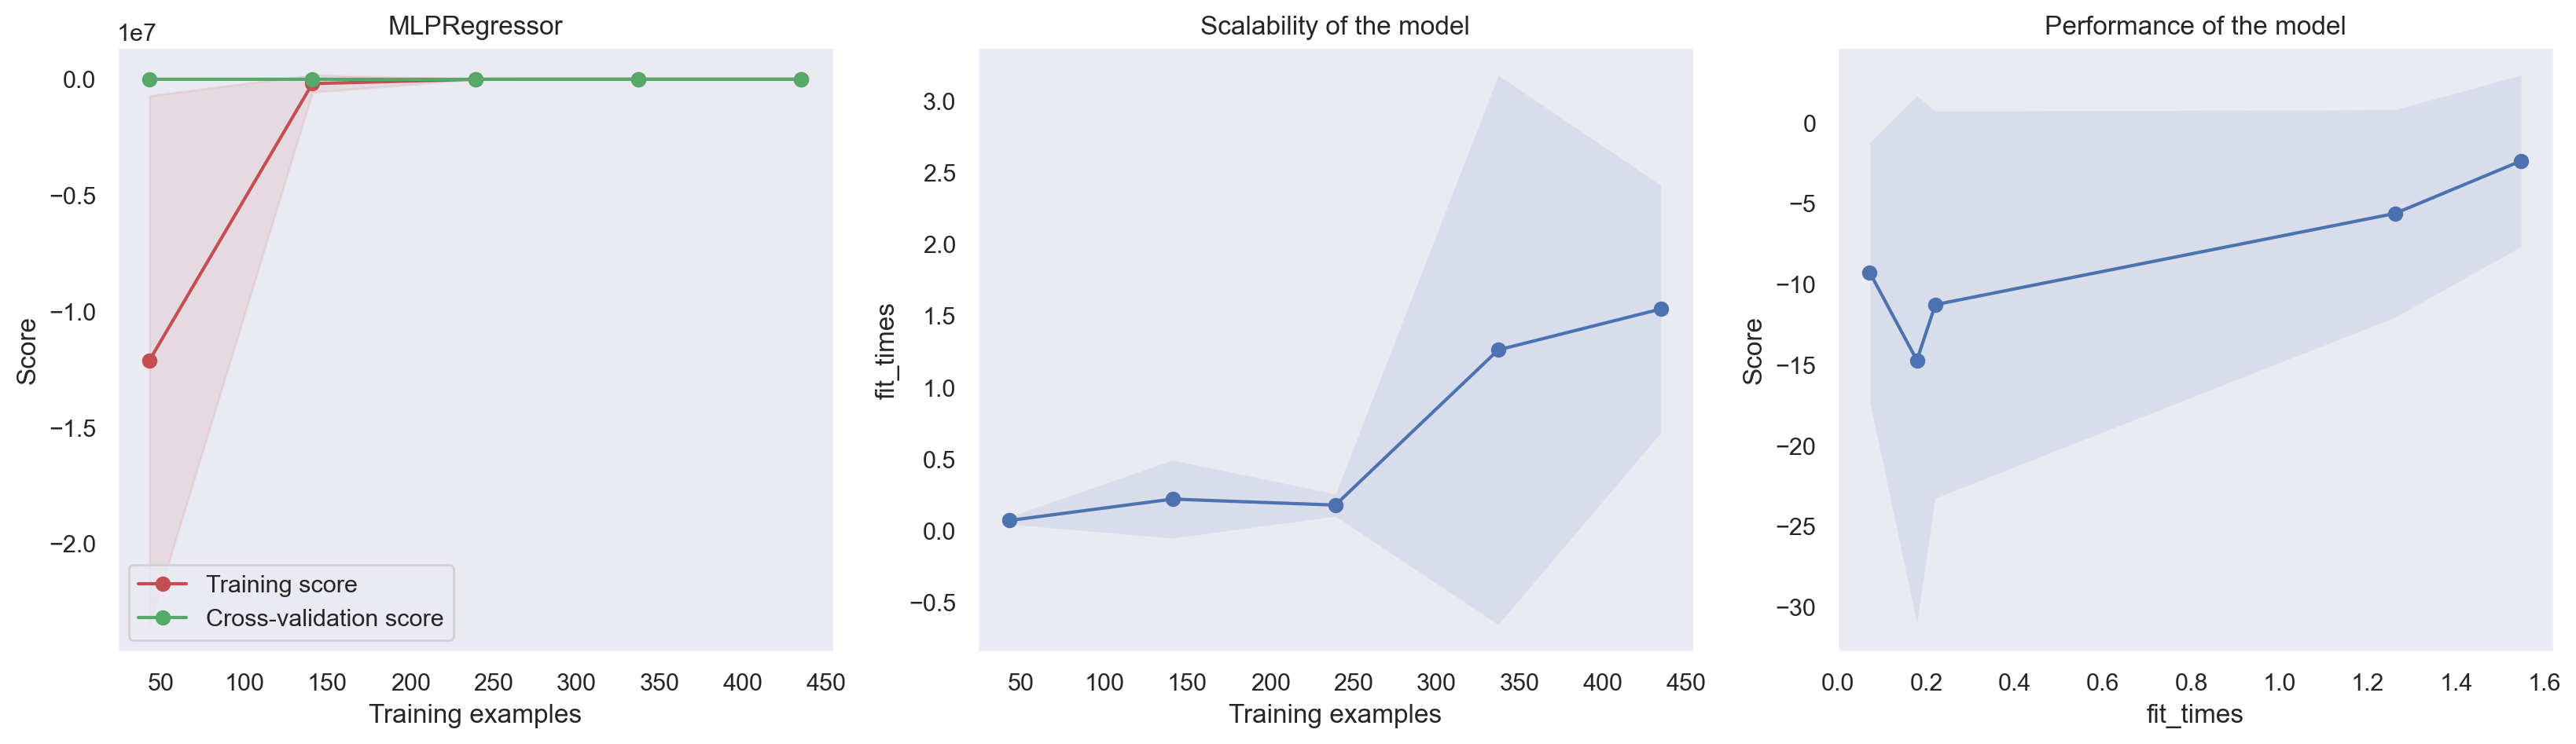

KNeighborsRegressor: NEG_MAPE=-0.187187 (STD=0.225383) (R2=0.999018)


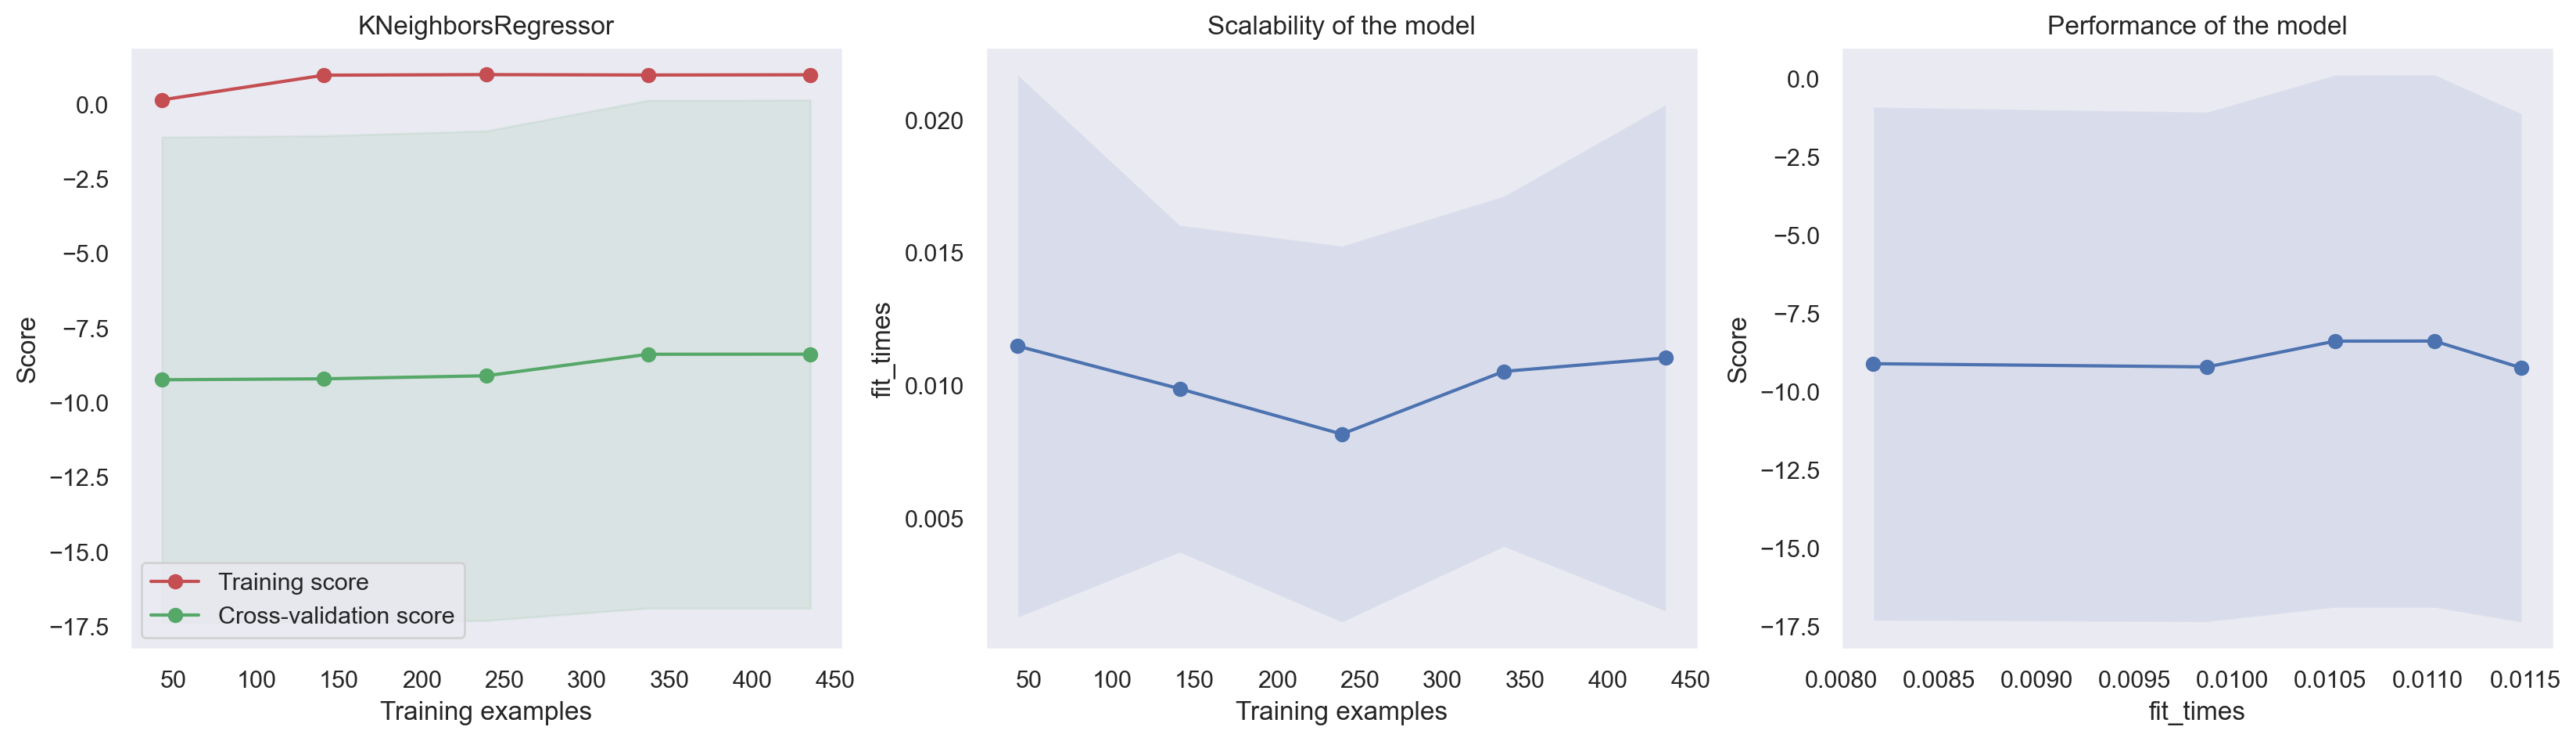

RandomForestRegressor: NEG_MAPE=-0.279313 (STD=0.216221) (R2=0.999694)


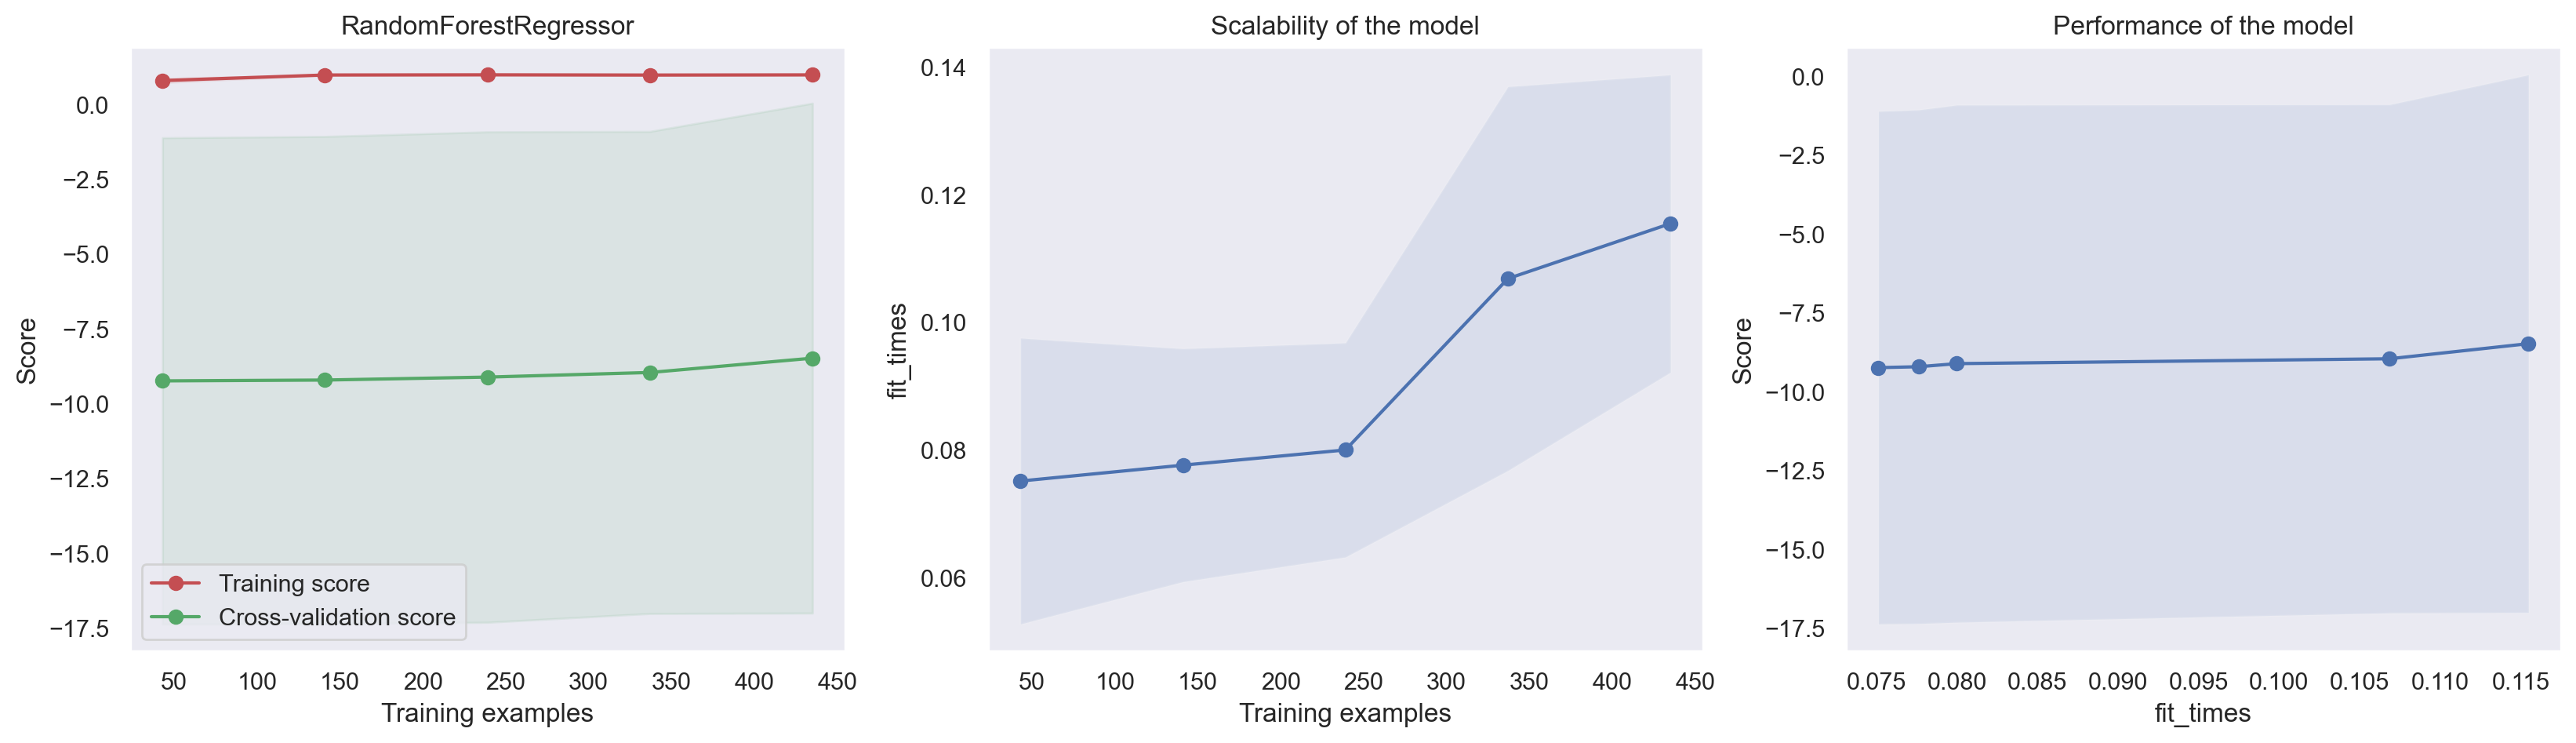

SVR: NEG_MAPE=-0.814937 (STD=0.246123) (R2=-0.321505)


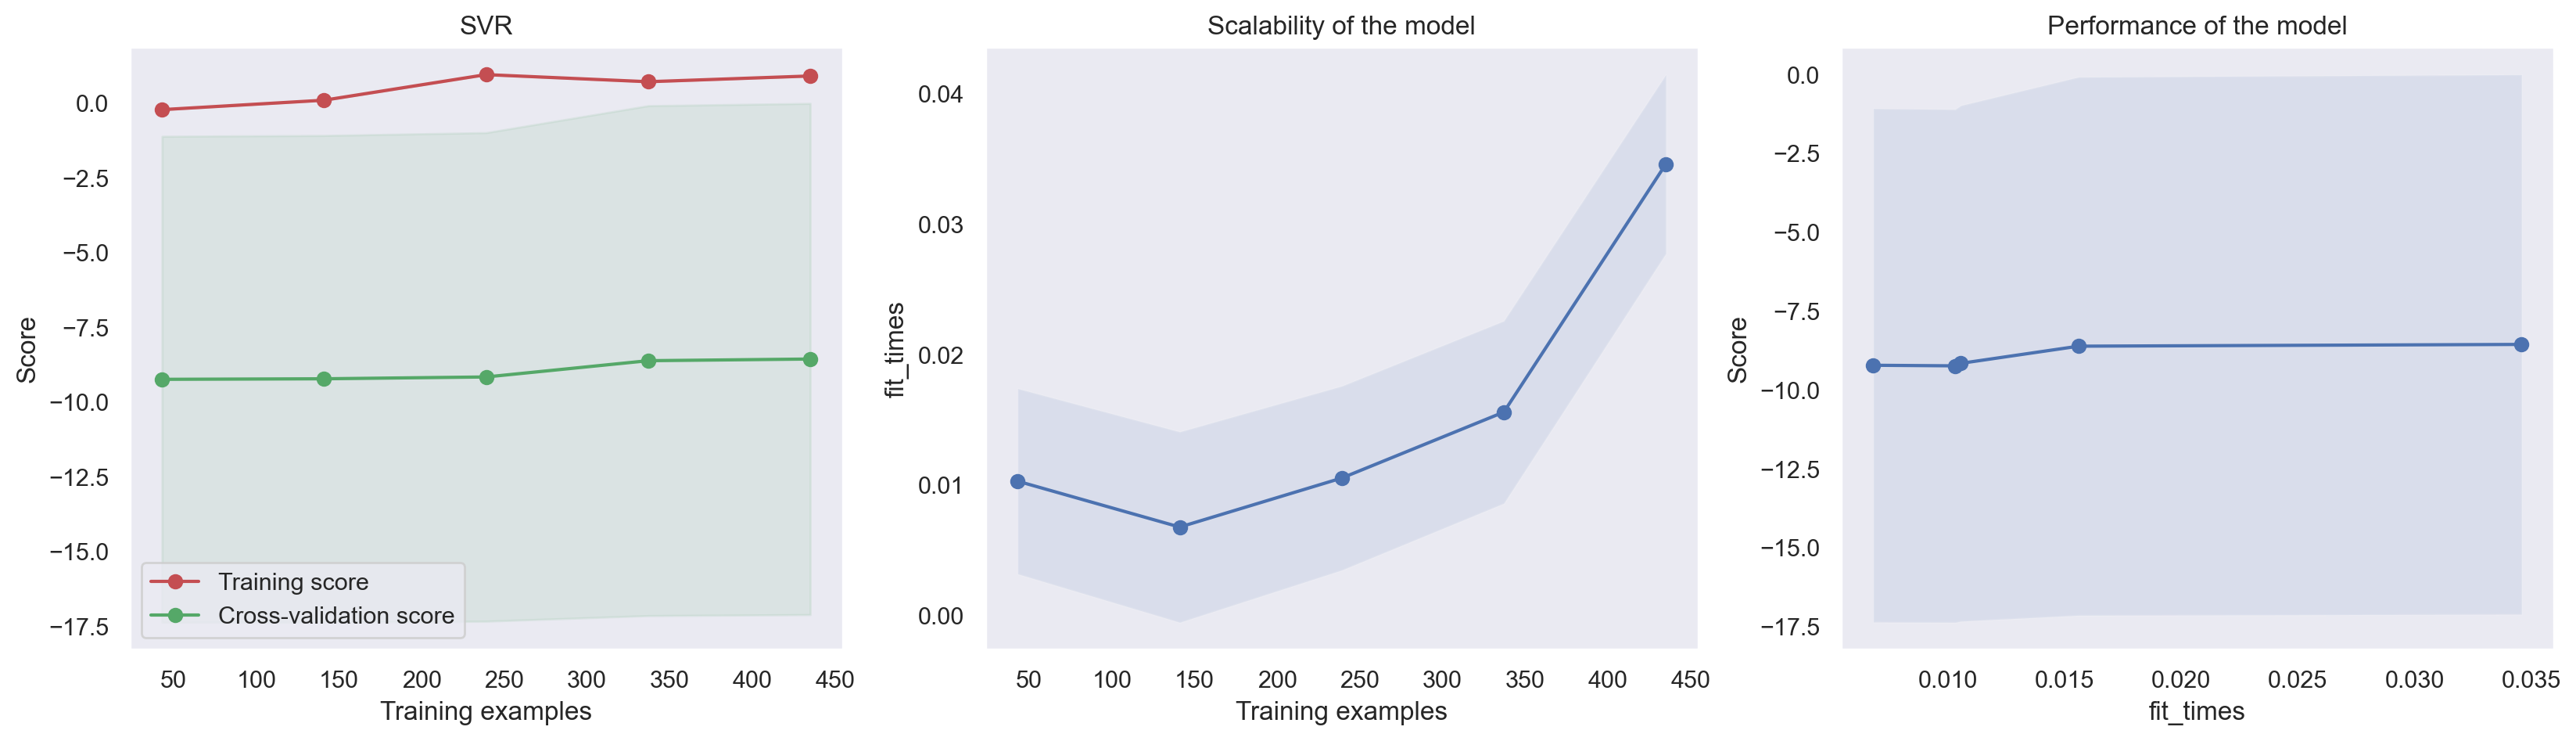

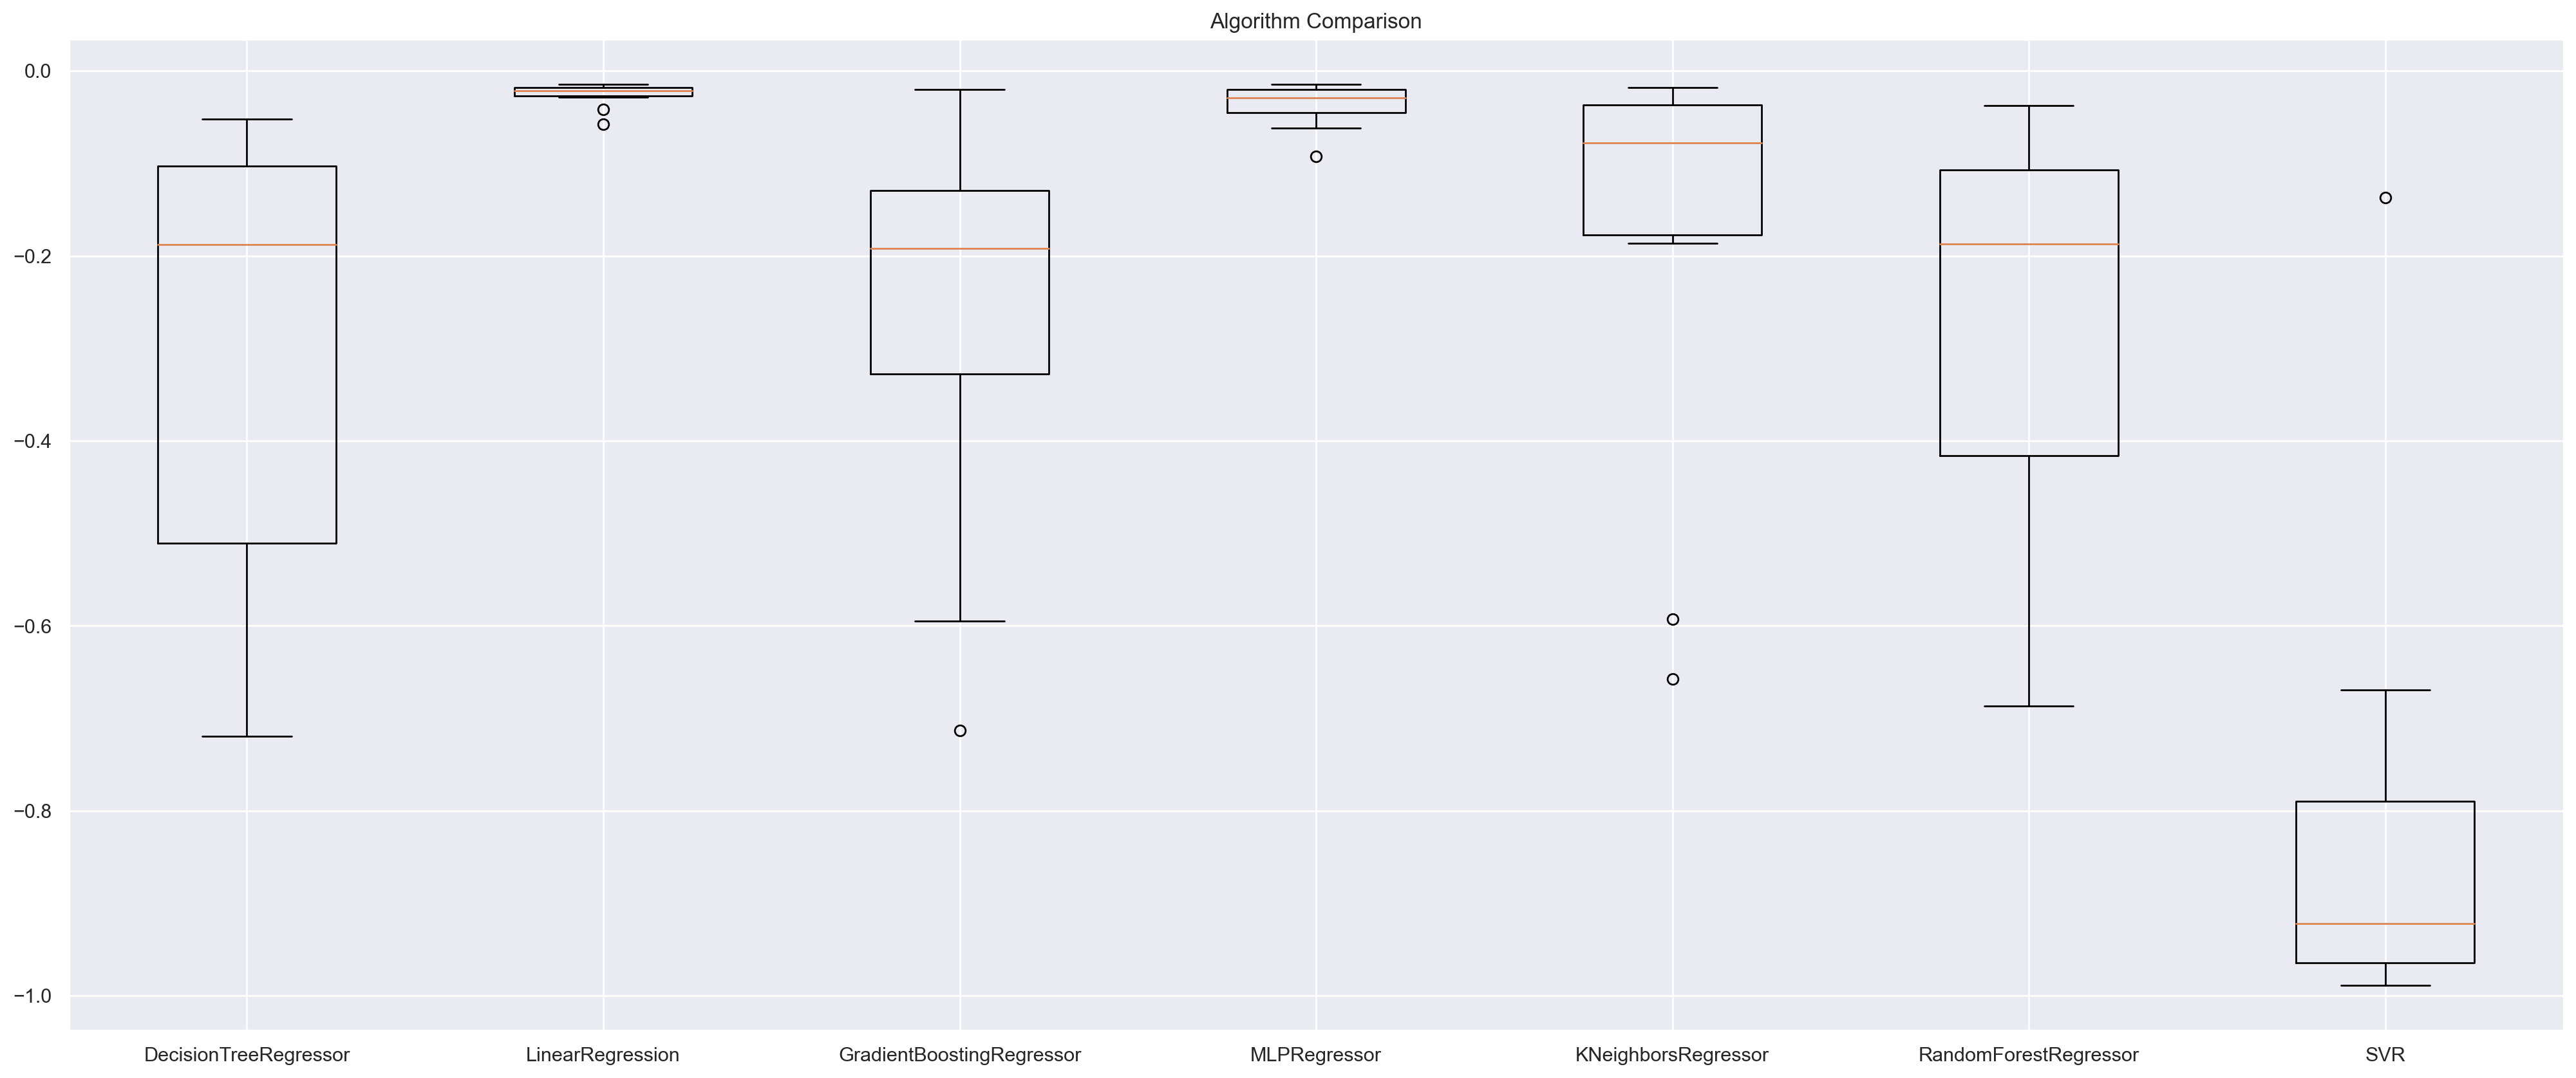

In [17]:
_models_score(df_formatted)

# 

# 3) Scaling

In [18]:
def _get_scaled_dataset(df):
    
    # Define columns to be scaled
    columns = ['Price', 'Yesterday_Price', 'Yesterday_Diff']
    # Scale columns using a MinMaxScaler
    df[columns] = StandardScaler().fit_transform(df[columns])
    # Format columns as float to return a new dataset
    df[columns] = df[columns].astype(float)
    # Display actual dataset
    display(df)
    return df

In [19]:
df_formatted = _get_scaled_dataset(df_formatted)

Price   Date_float  Yesterday_Price  Yesterday_Diff
4714 -0.629902  2010.539726        -0.629589       -0.010497
4713 -0.629899  2010.542466        -0.629586       -0.010497
4712 -0.629900  2010.545205        -0.629583       -0.010428
4711 -0.629900  2010.547945        -0.629583       -0.010506
4710 -0.629900  2010.550685        -0.629584       -0.010508
...        ...          ...              ...             ...
4     1.195448  2023.435616         1.192705       -0.450437
3     1.157636  2023.438356         1.195948        0.079697
2     1.151861  2023.441096         1.158133       -1.062385
1     1.149115  2023.443836         1.152357       -0.171162
0     1.159964  2023.446575         1.149610       -0.086889

[4715 rows x 4 columns]

DecisionTreeRegressor: NEG_MAPE=-2.624896 (STD=4.754149) (R2=1.000000)


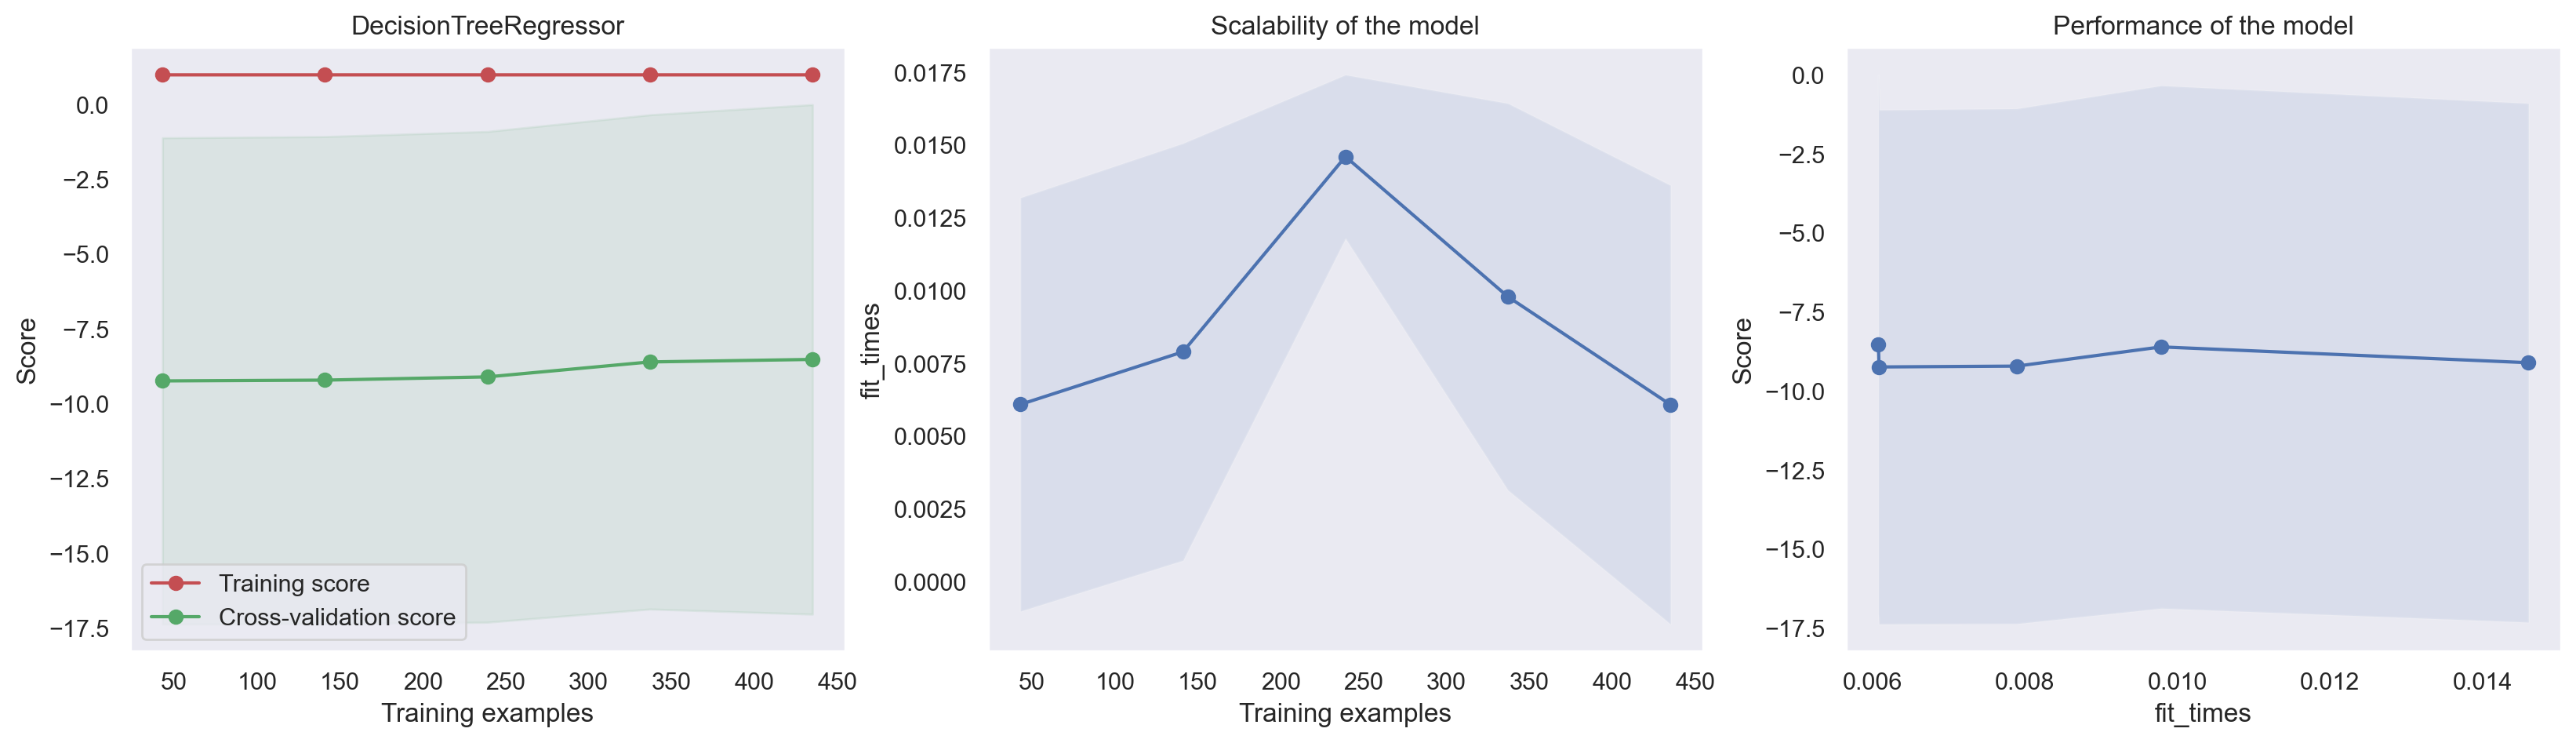

LinearRegression: NEG_MAPE=-0.184197 (STD=0.296467) (R2=0.998797)


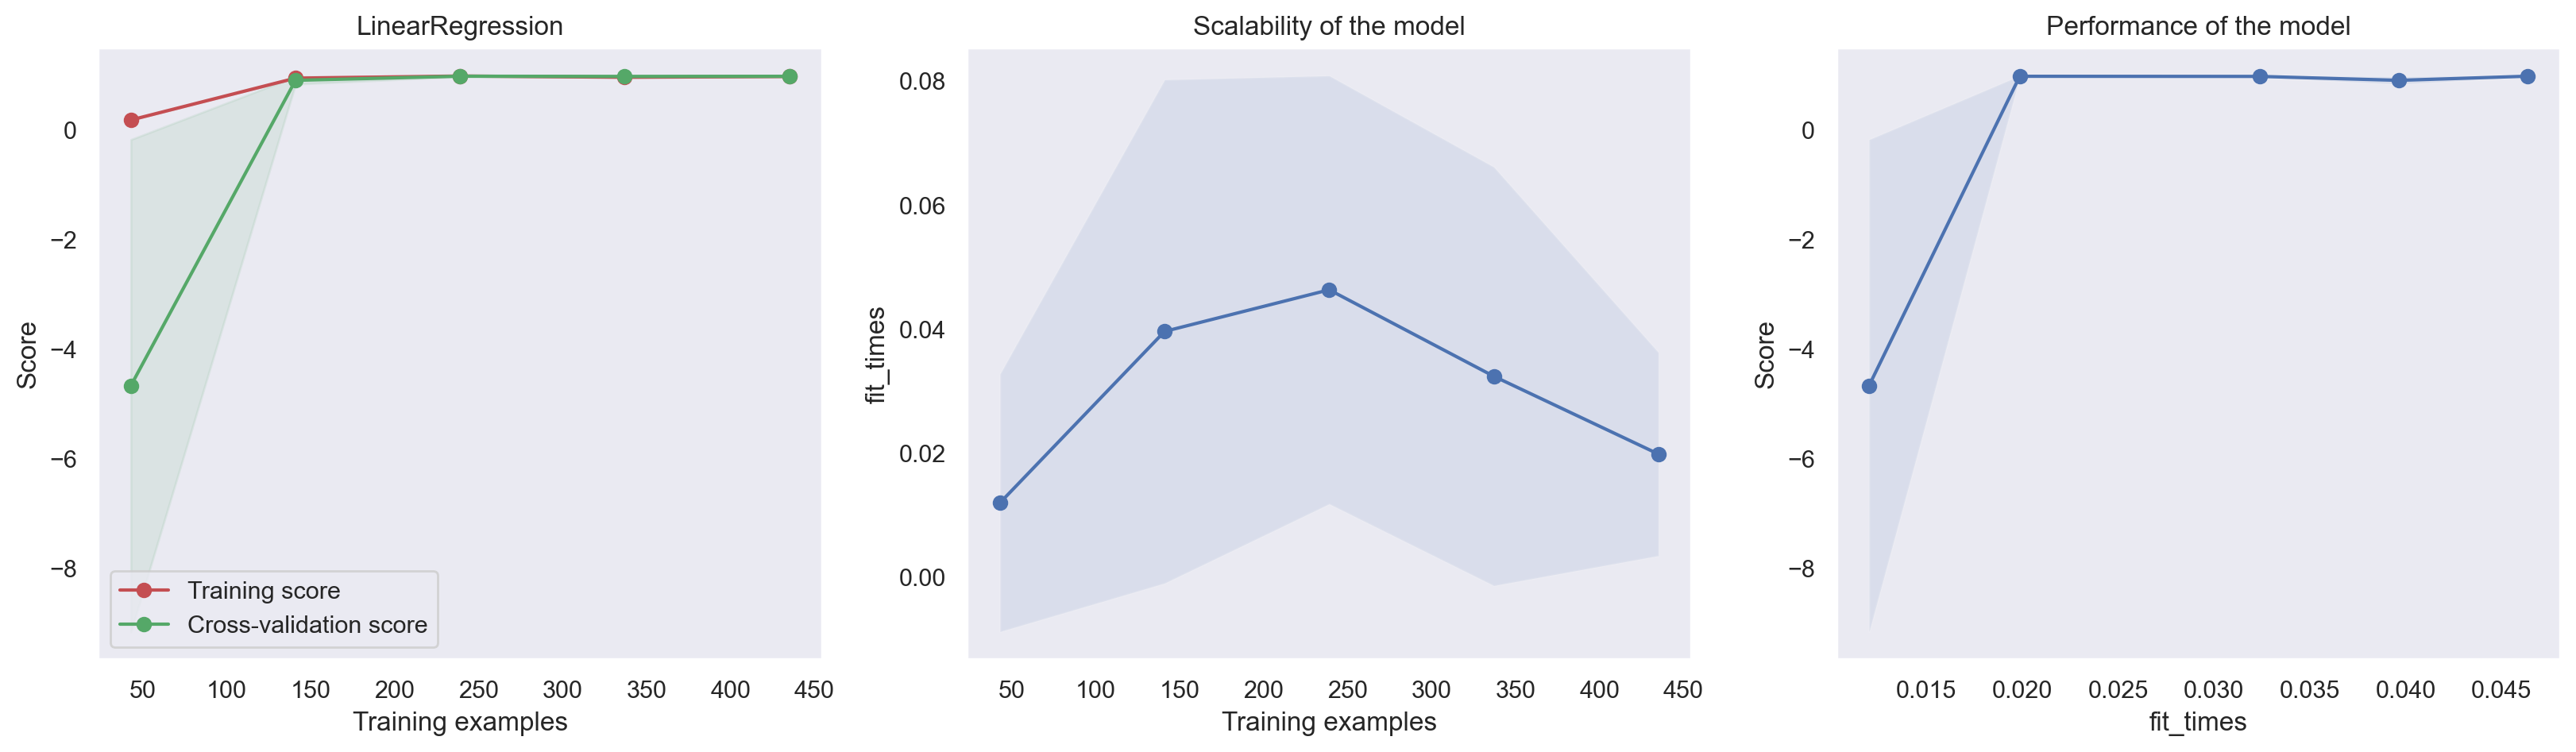

GradientBoostingRegressor: NEG_MAPE=-1.700191 (STD=3.909446) (R2=0.999286)


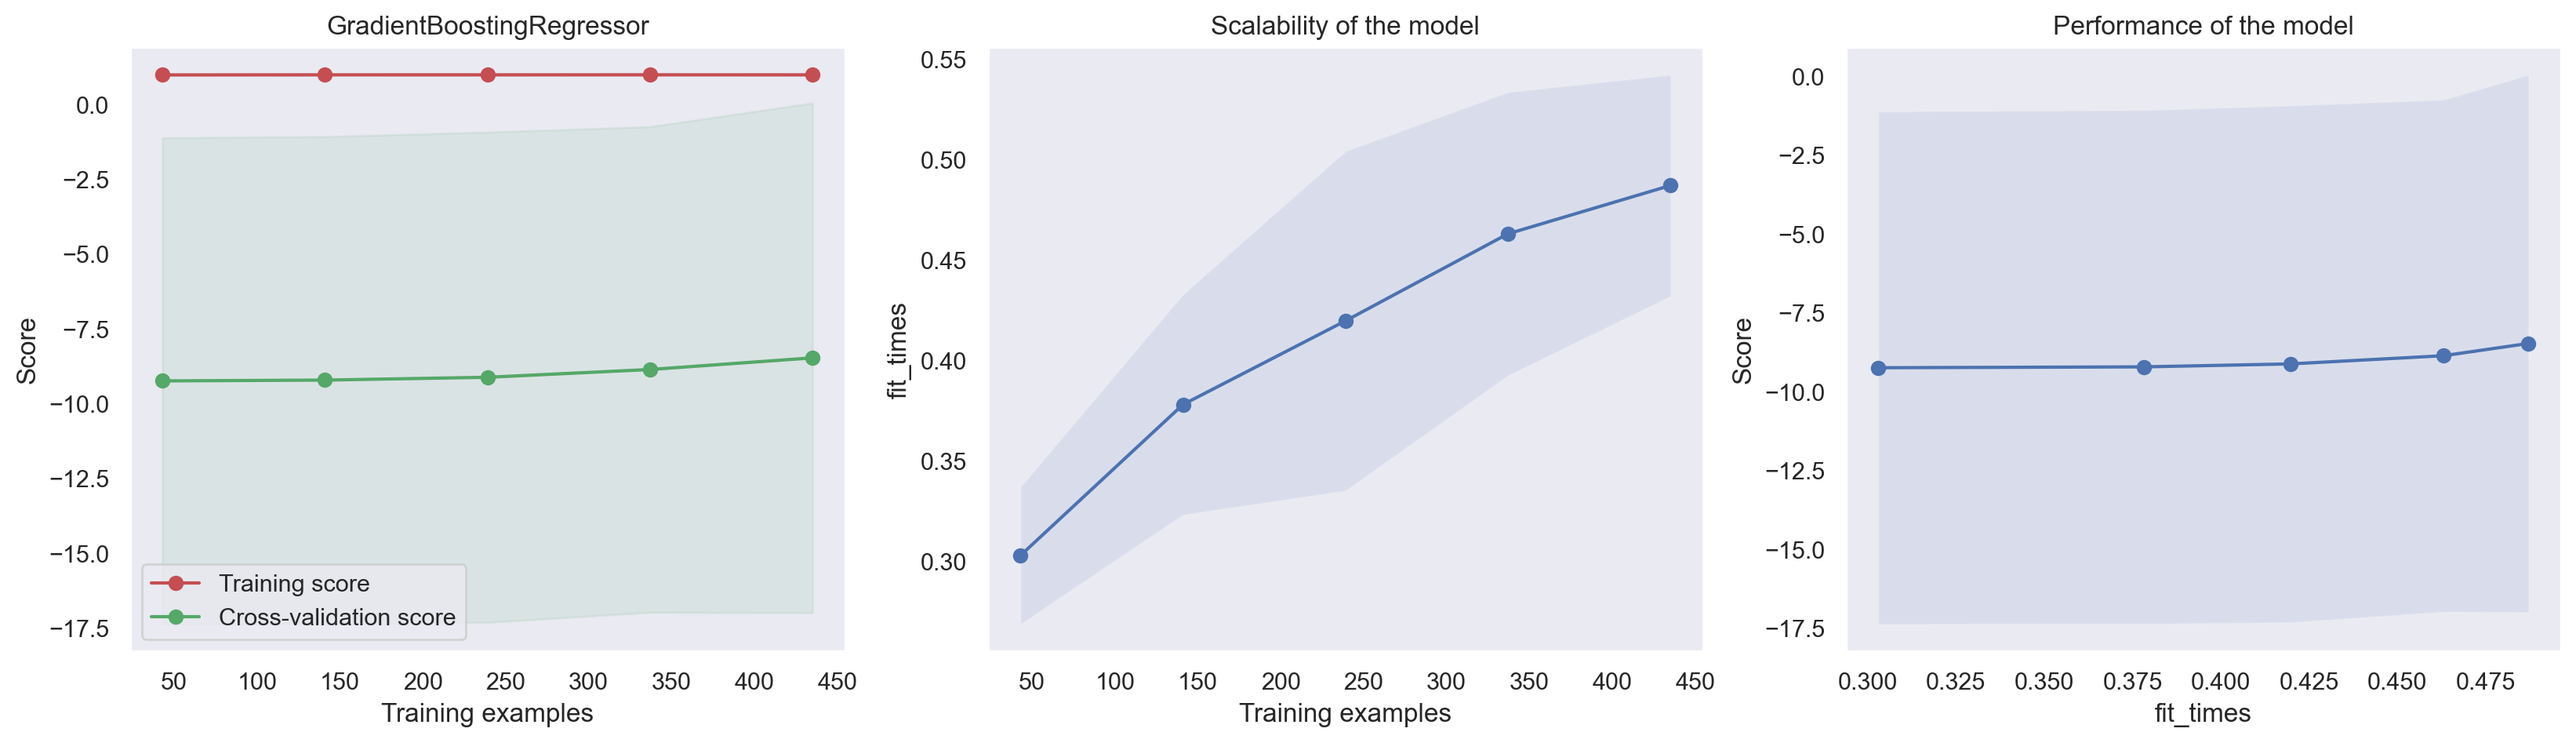

MLPRegressor: NEG_MAPE=-19.926366 (STD=45.284510) (R2=-0.177465)


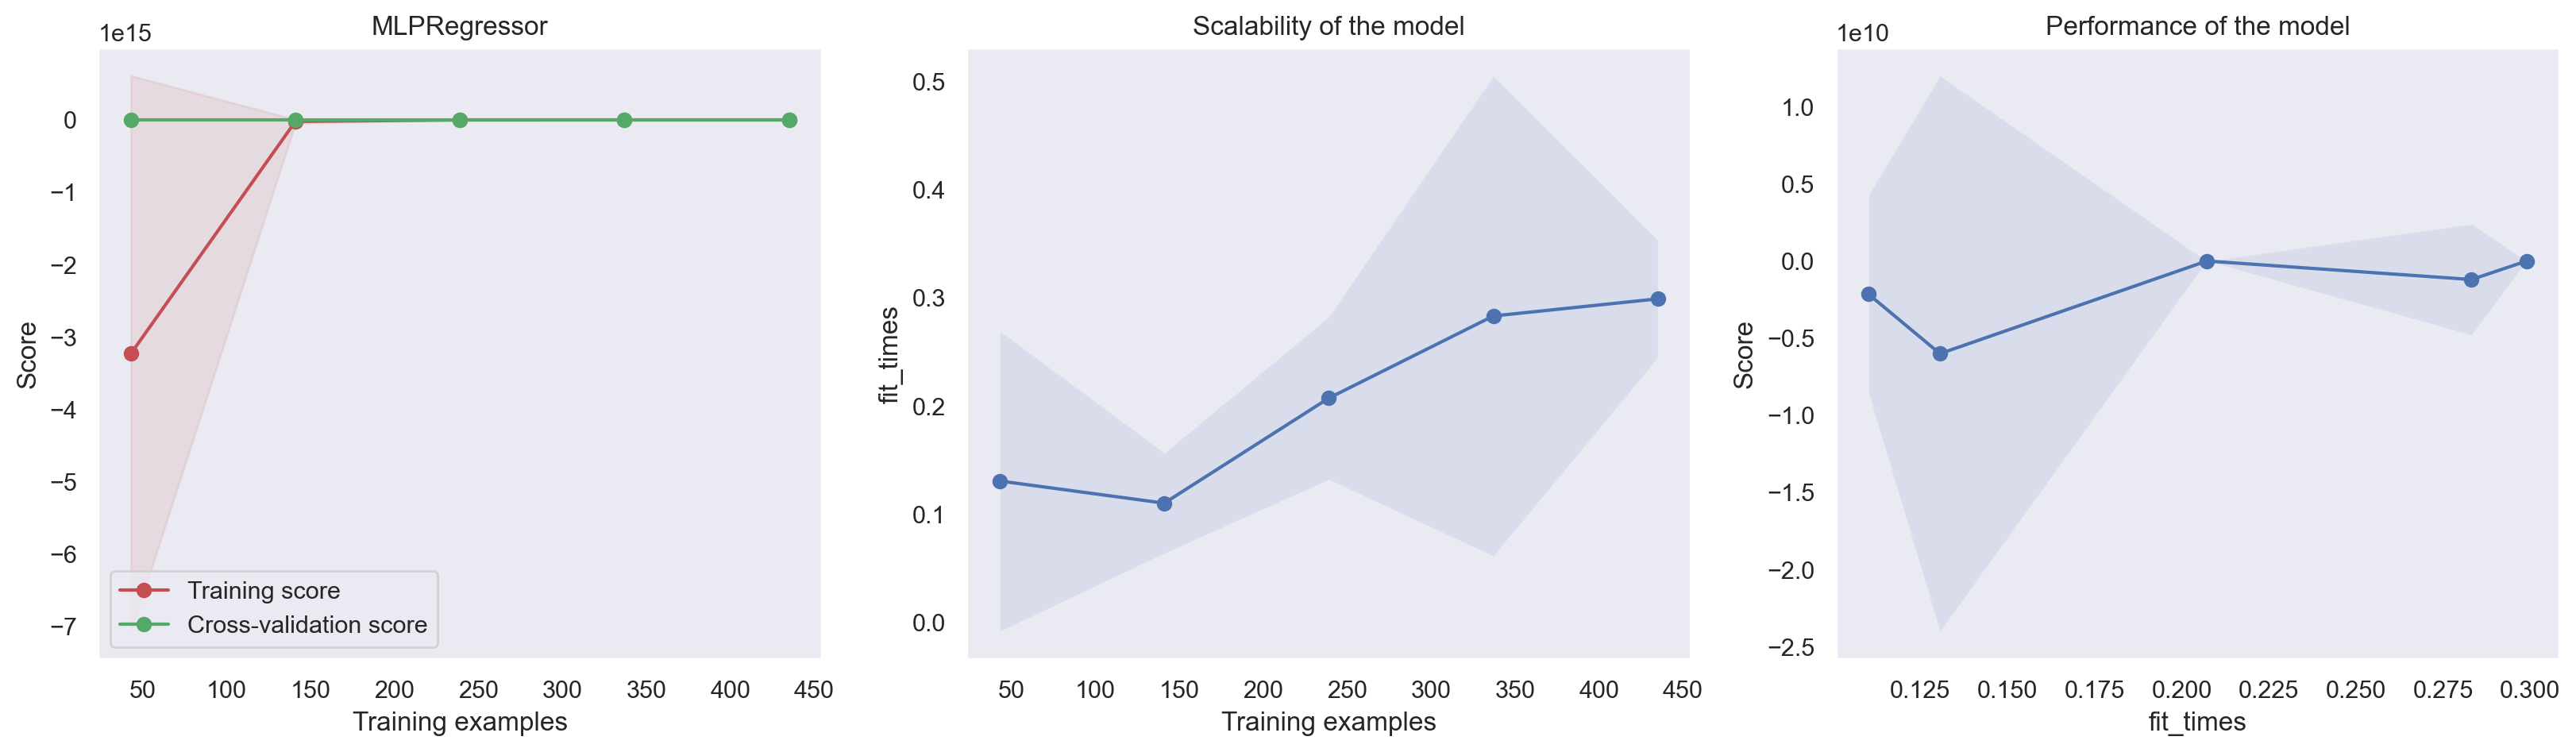

KNeighborsRegressor: NEG_MAPE=-8.579675 (STD=18.644777) (R2=0.996878)


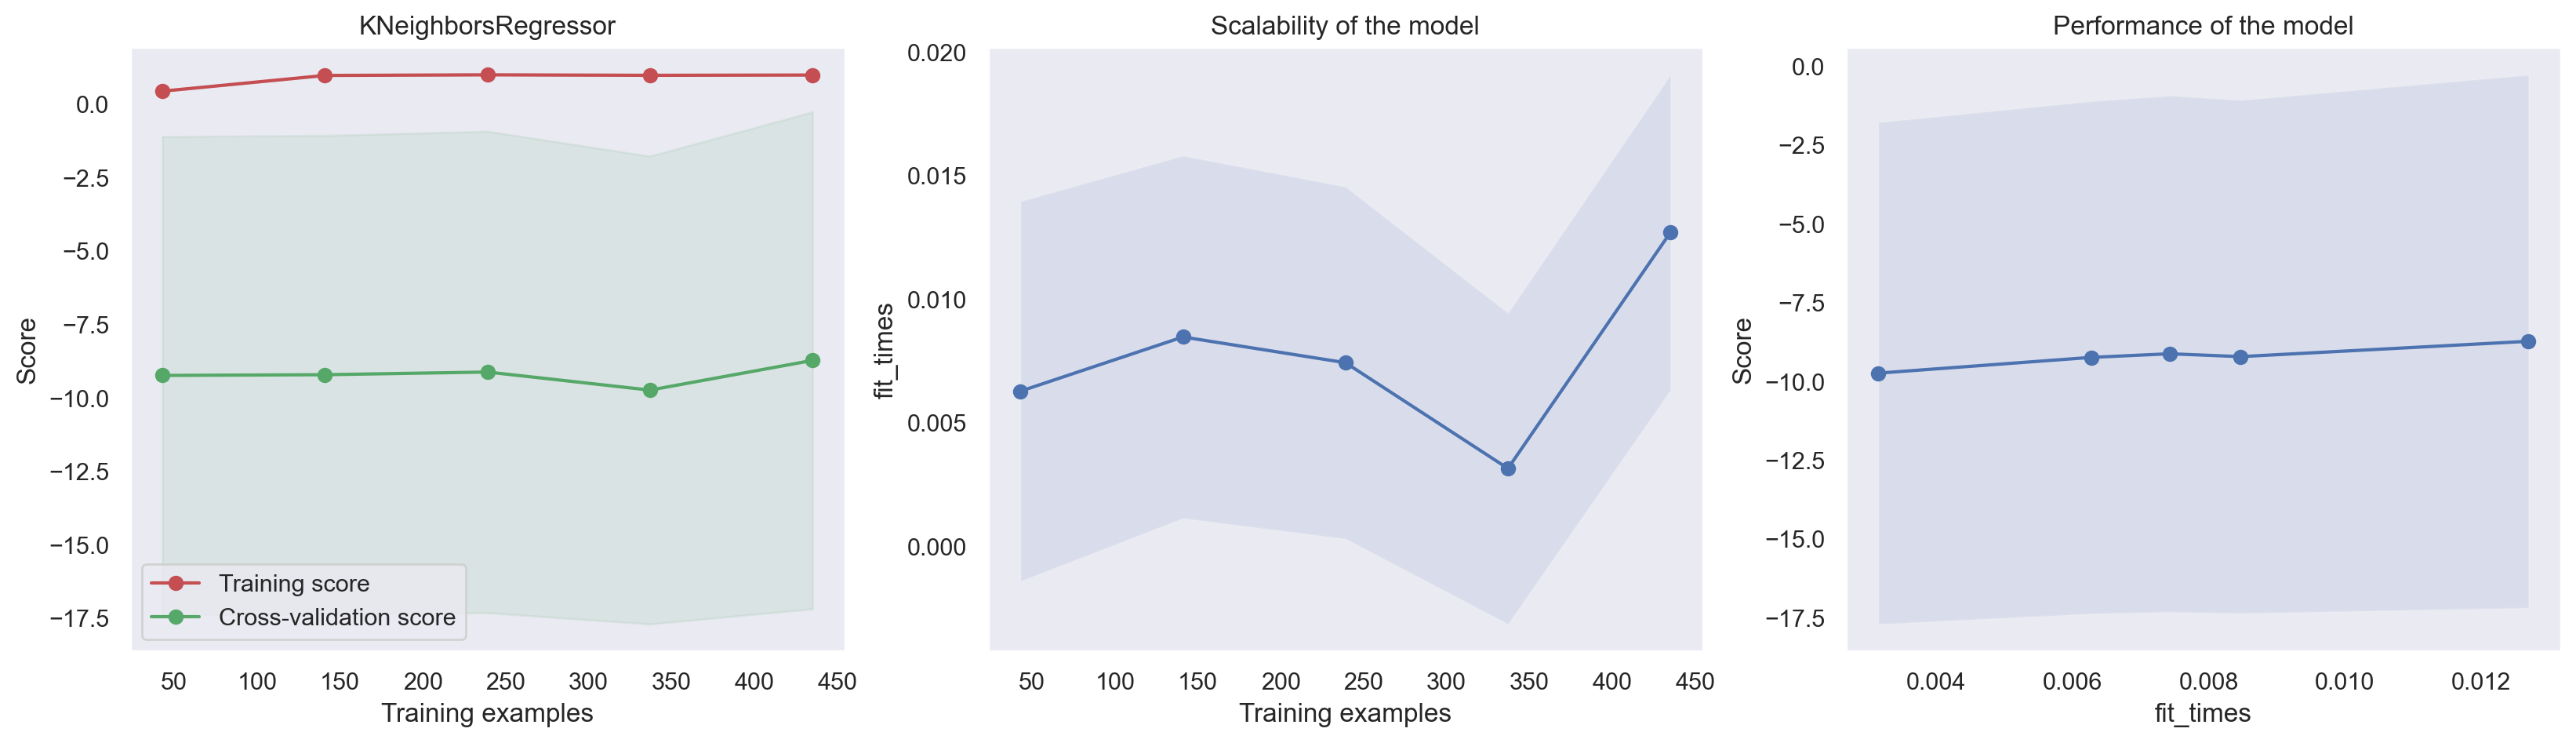

RandomForestRegressor: NEG_MAPE=-1.704358 (STD=3.922147) (R2=0.999727)


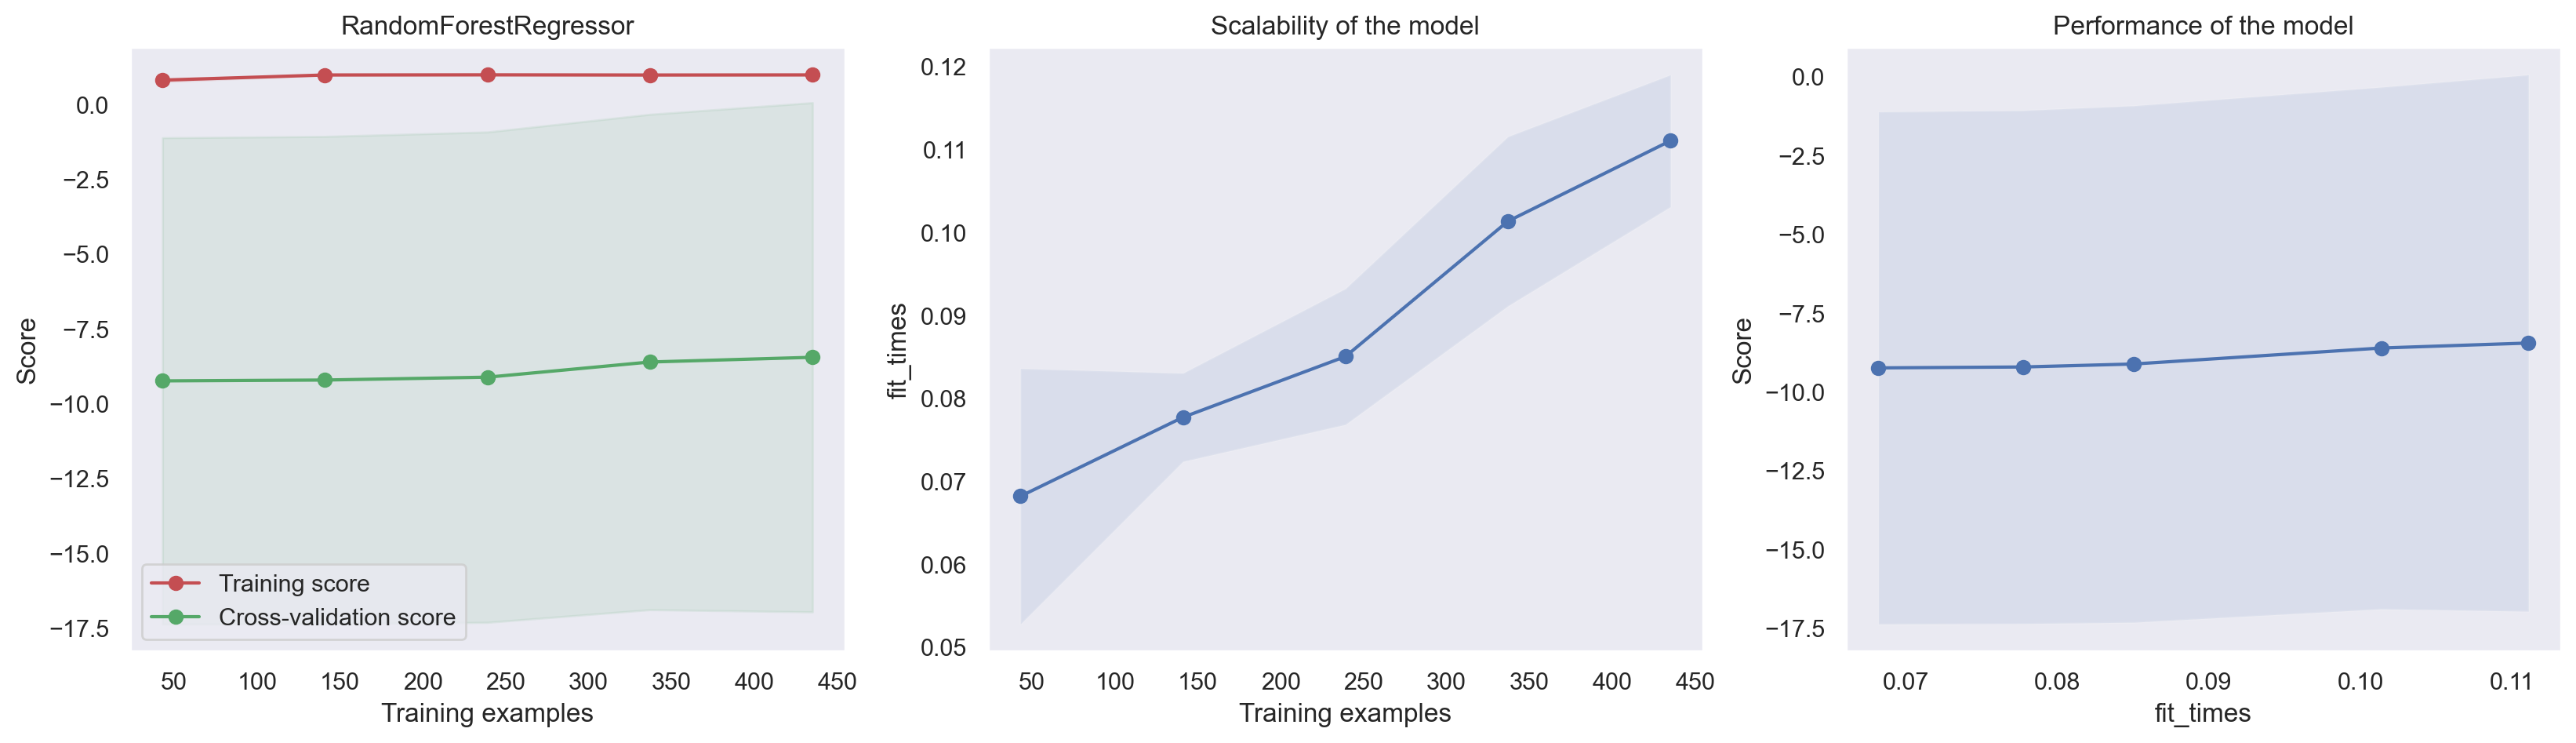

SVR: NEG_MAPE=-3.172583 (STD=5.528213) (R2=0.994622)


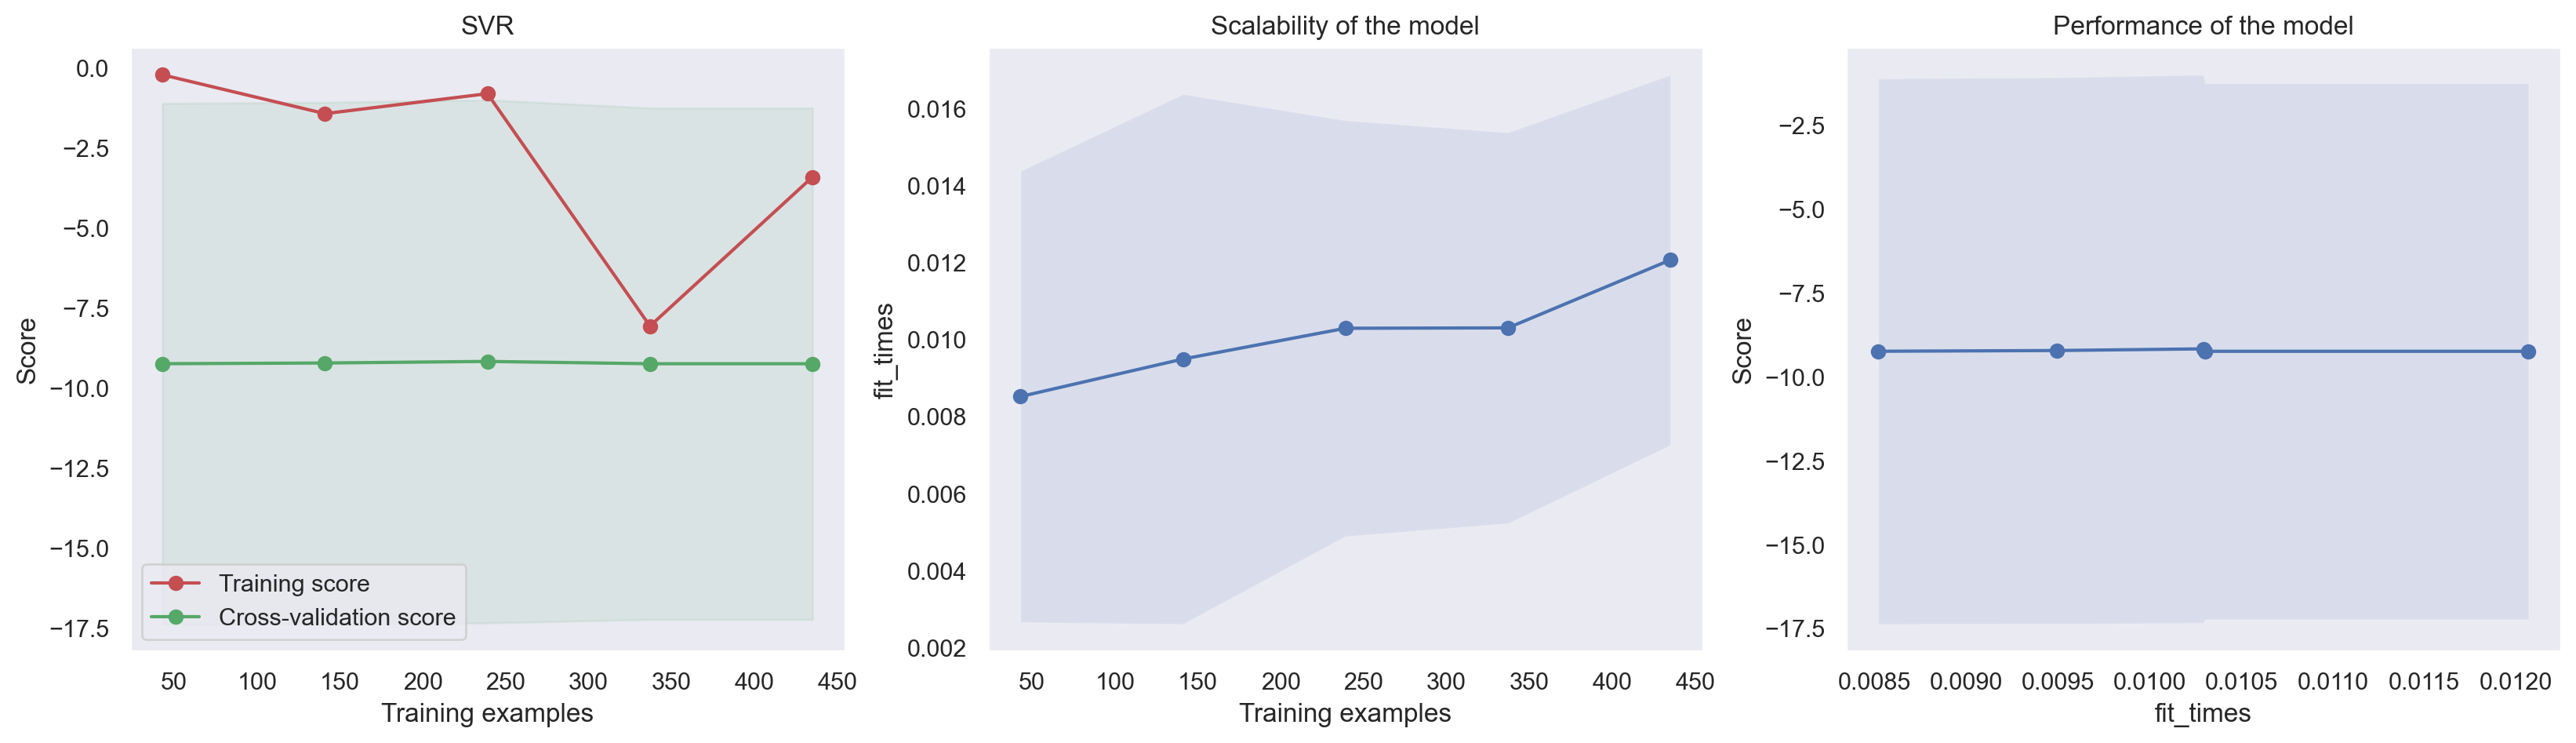

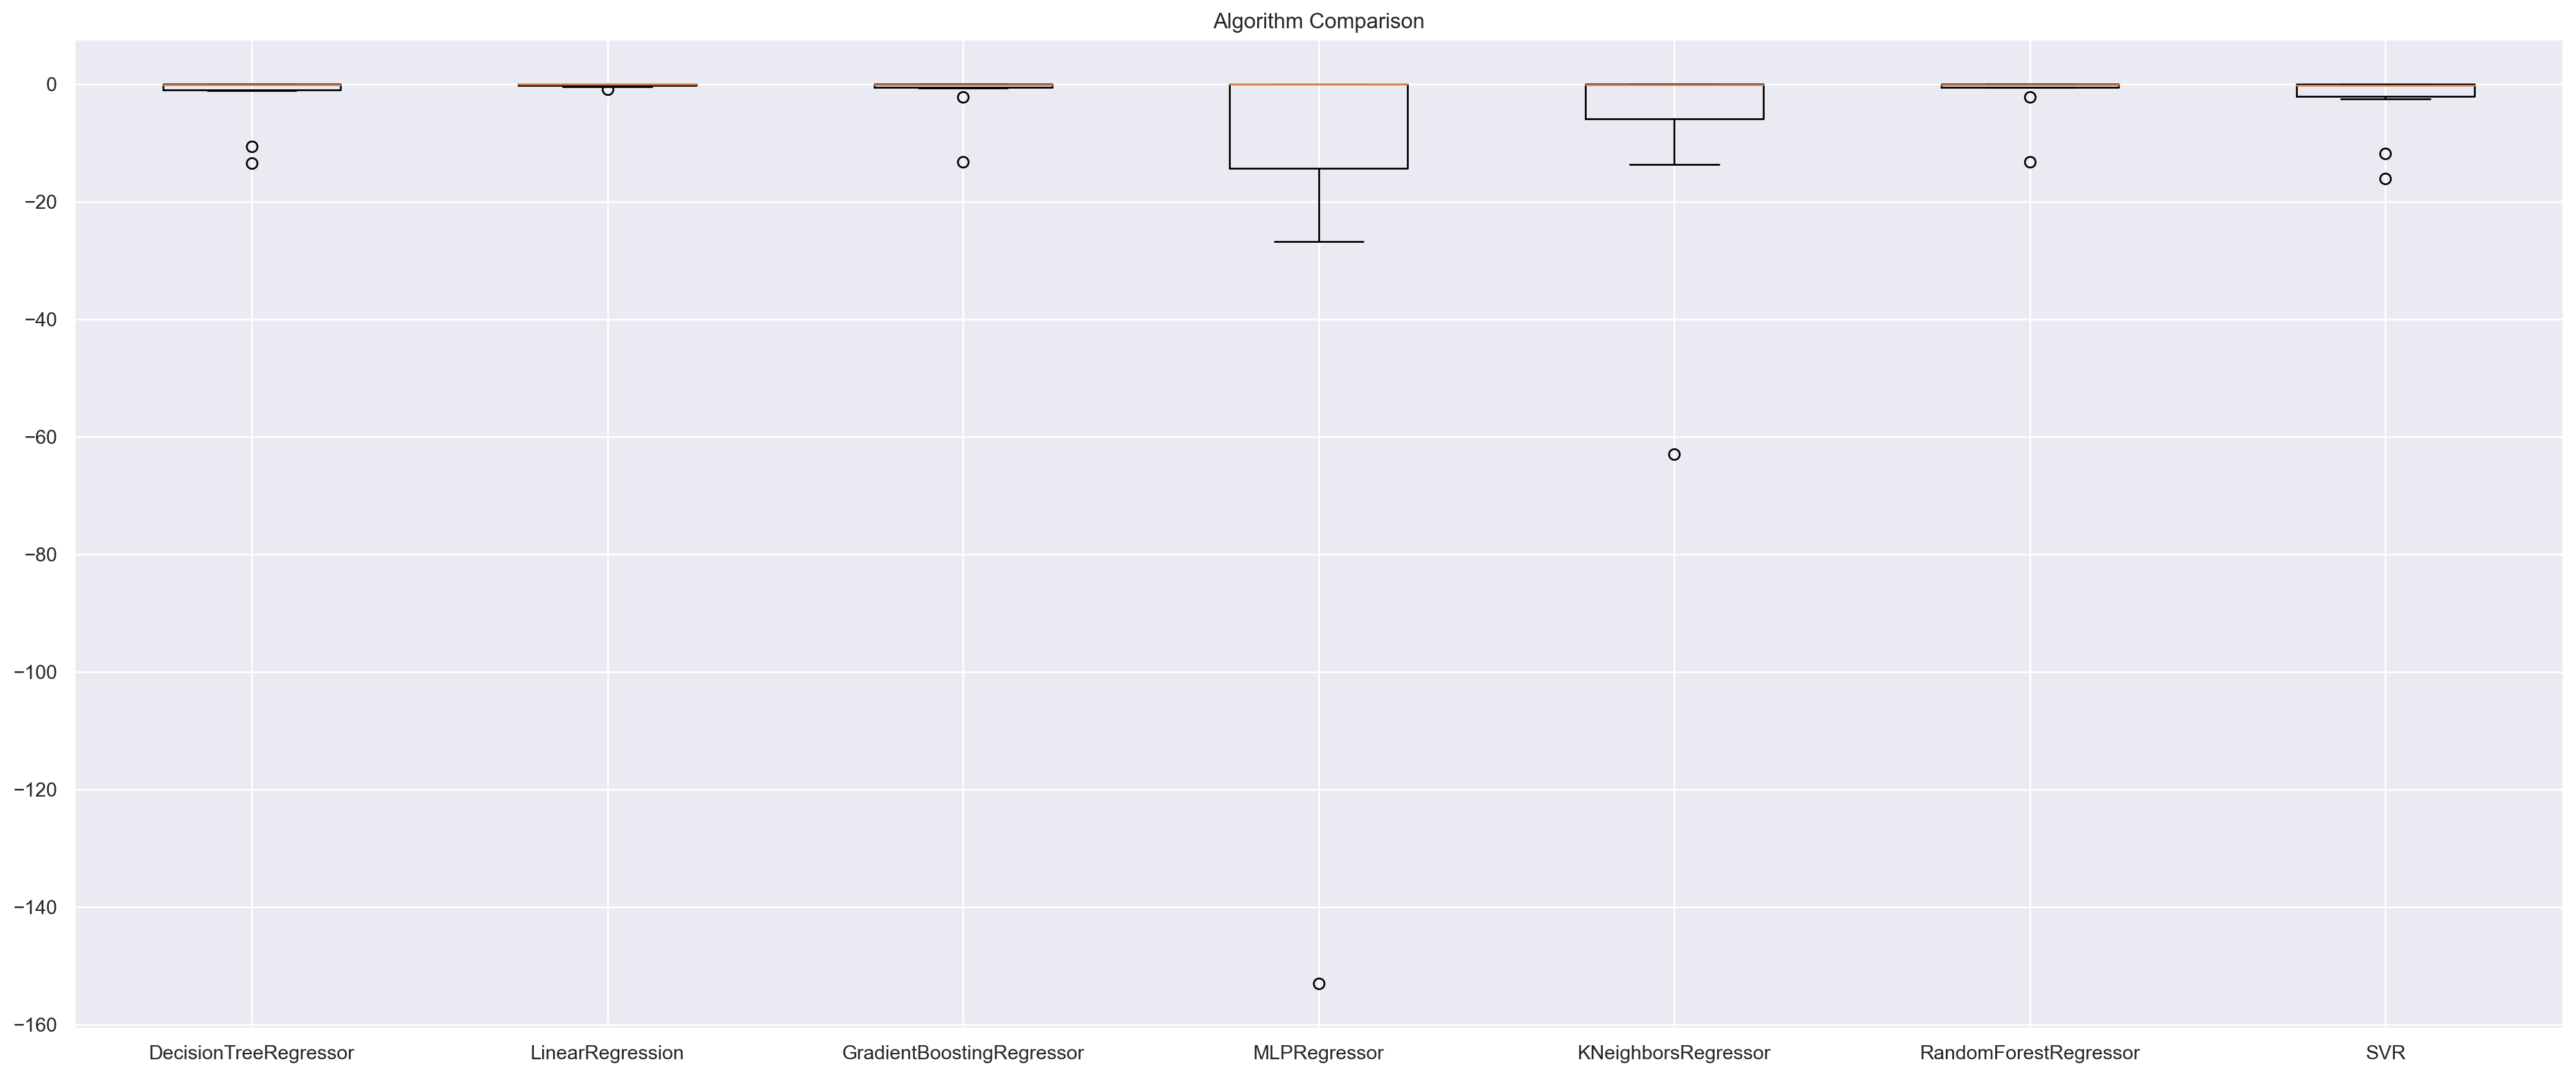

In [20]:
_models_score(df_formatted)

#

# 4) Resampling

Price   Date_float
673  25952.690000  2023.438356
672  26676.015714  2023.419178
671  27329.025000  2023.400000
670  26774.315000  2023.380822
669  26987.928571  2023.361644
..            ...          ...
4        0.066857  2010.616438
3        0.066057  2010.597260
2        0.061329  2010.578082
1        0.058929  2010.558904
0        0.069086  2010.539726

[674 rows x 2 columns]

DecisionTreeRegressor: NEG_MAPE=-4.879436 (STD=8.095607) (R2=1.000000)


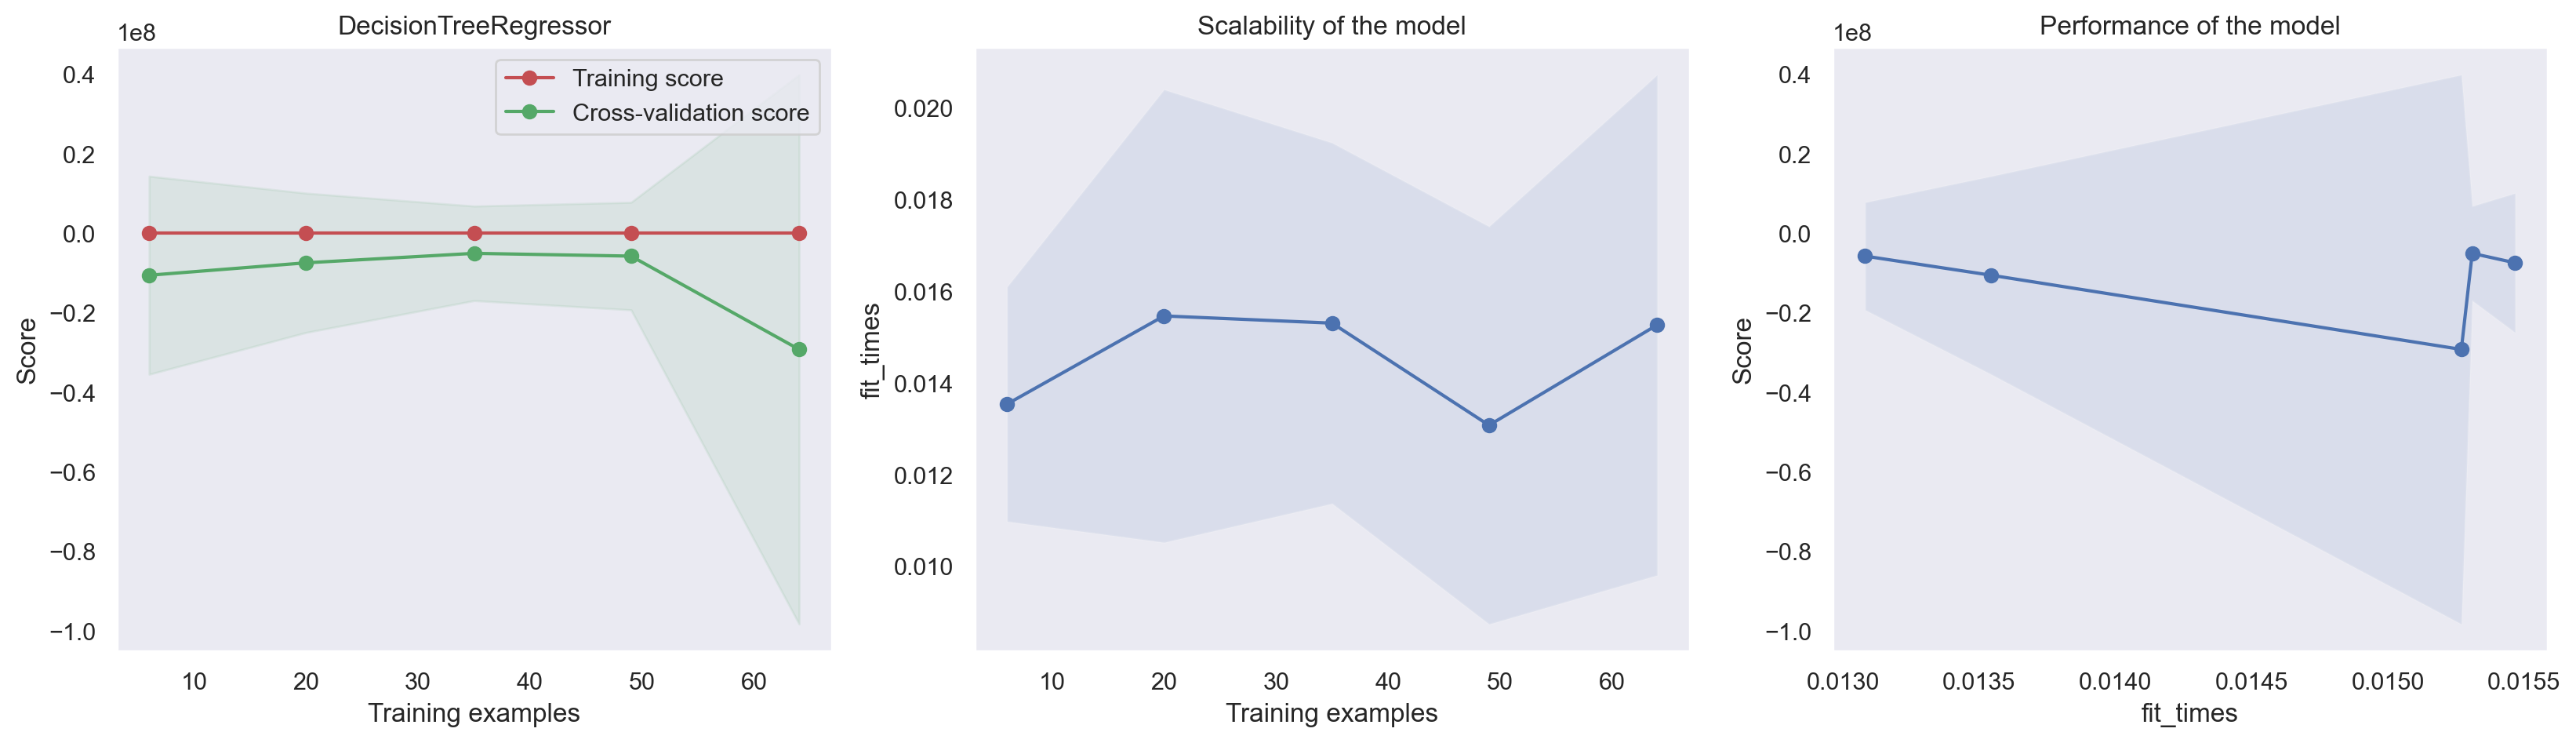

LinearRegression: NEG_MAPE=-5781.087157 (STD=16549.920395) (R2=0.525664)


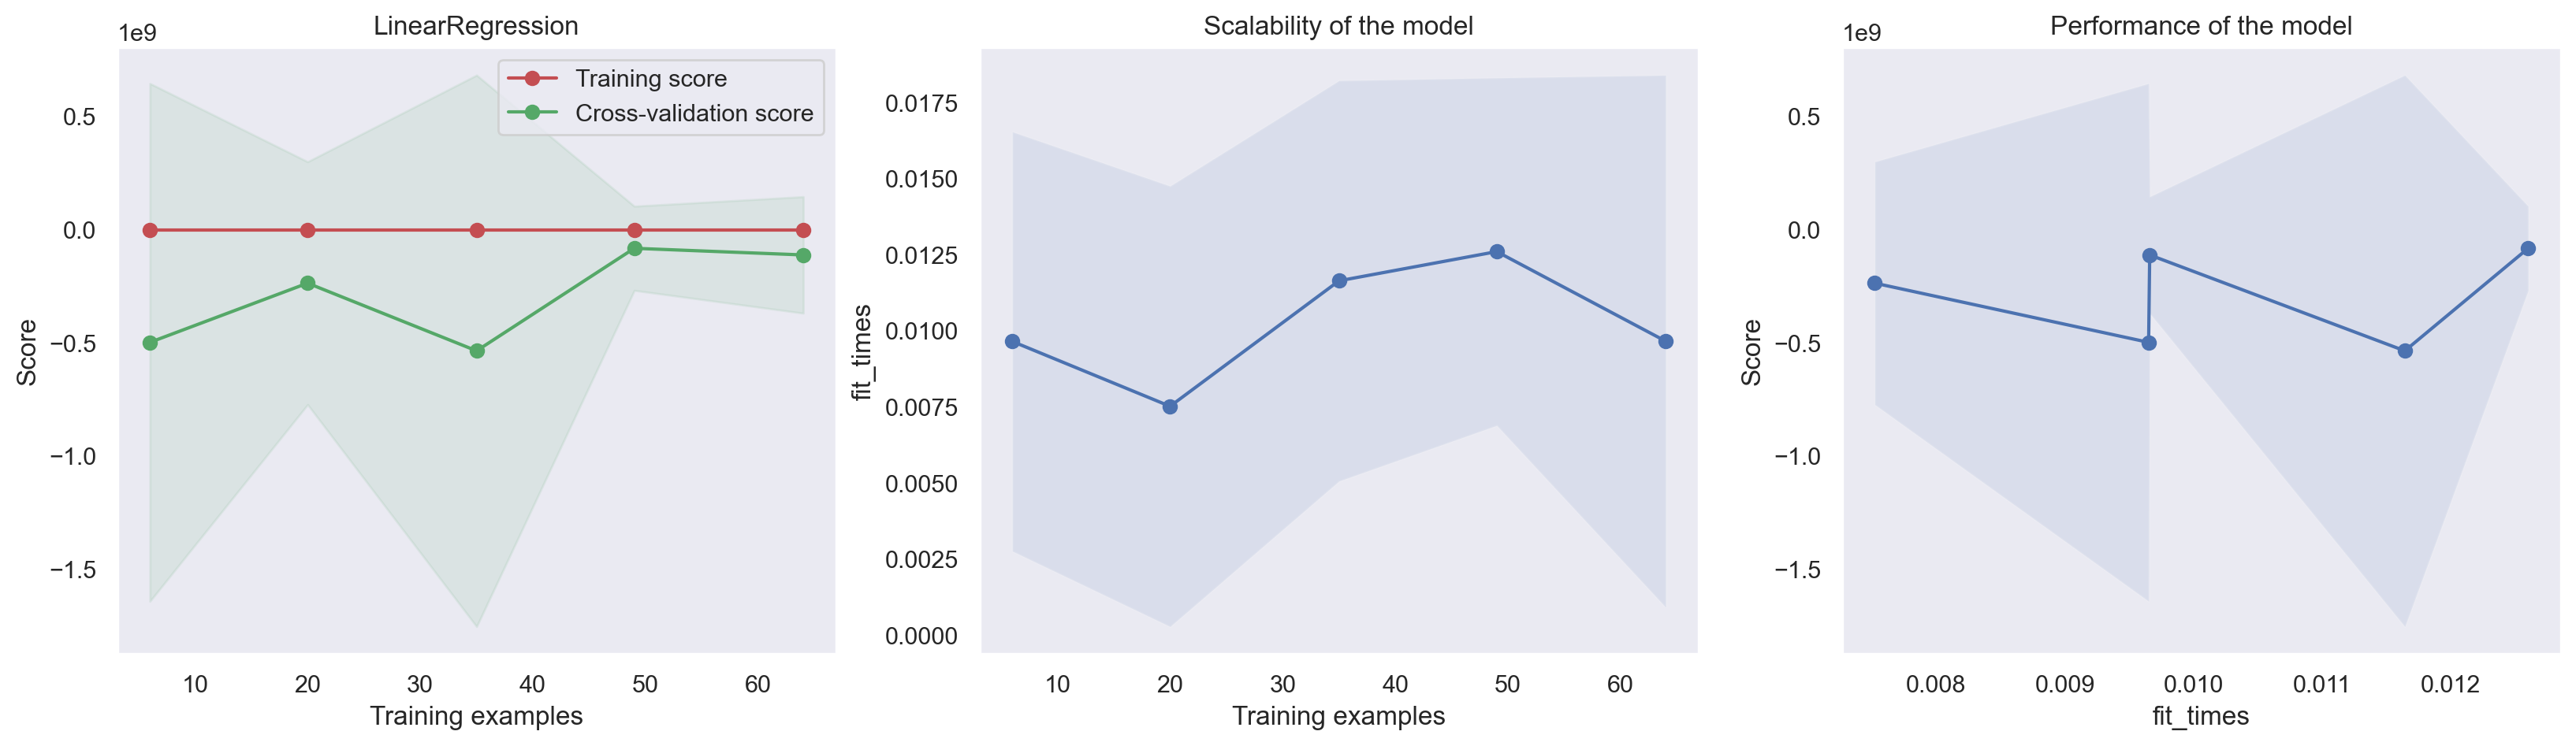

GradientBoostingRegressor: NEG_MAPE=-36.694646 (STD=94.494186) (R2=0.998350)


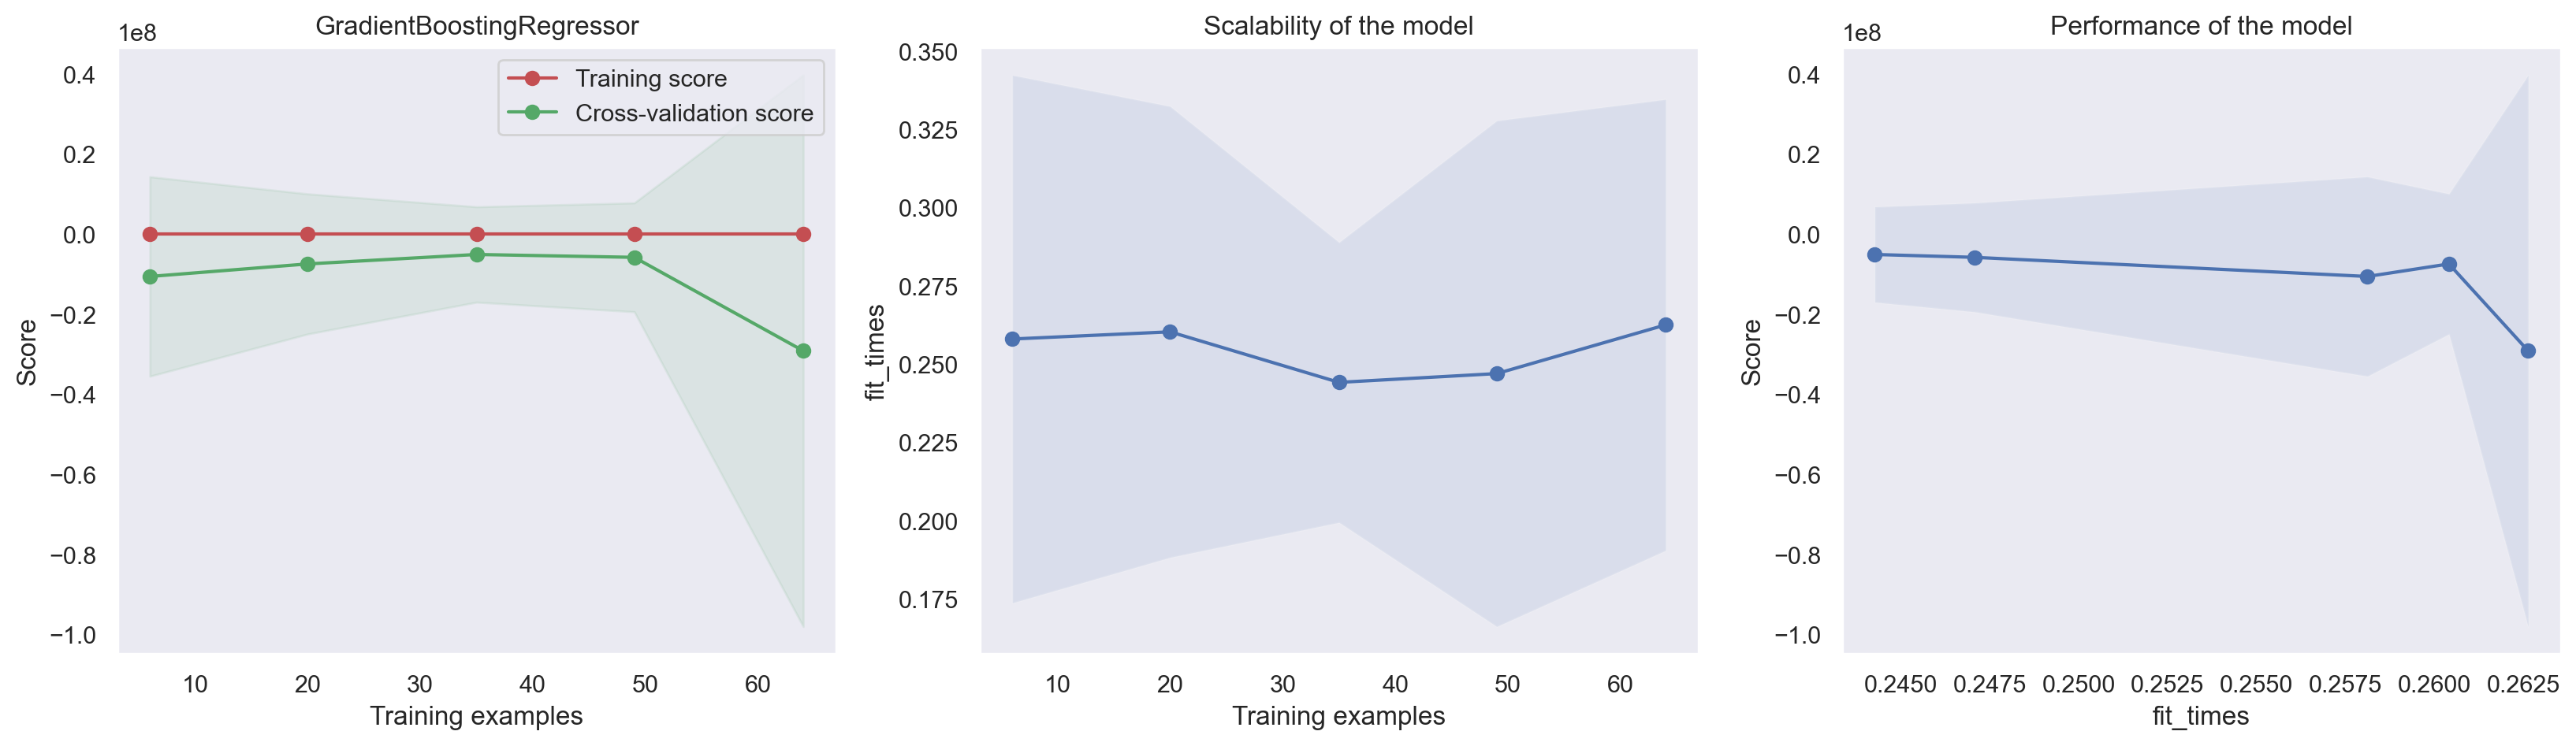

MLPRegressor: NEG_MAPE=-4938.028175 (STD=14001.565629) (R2=0.001665)


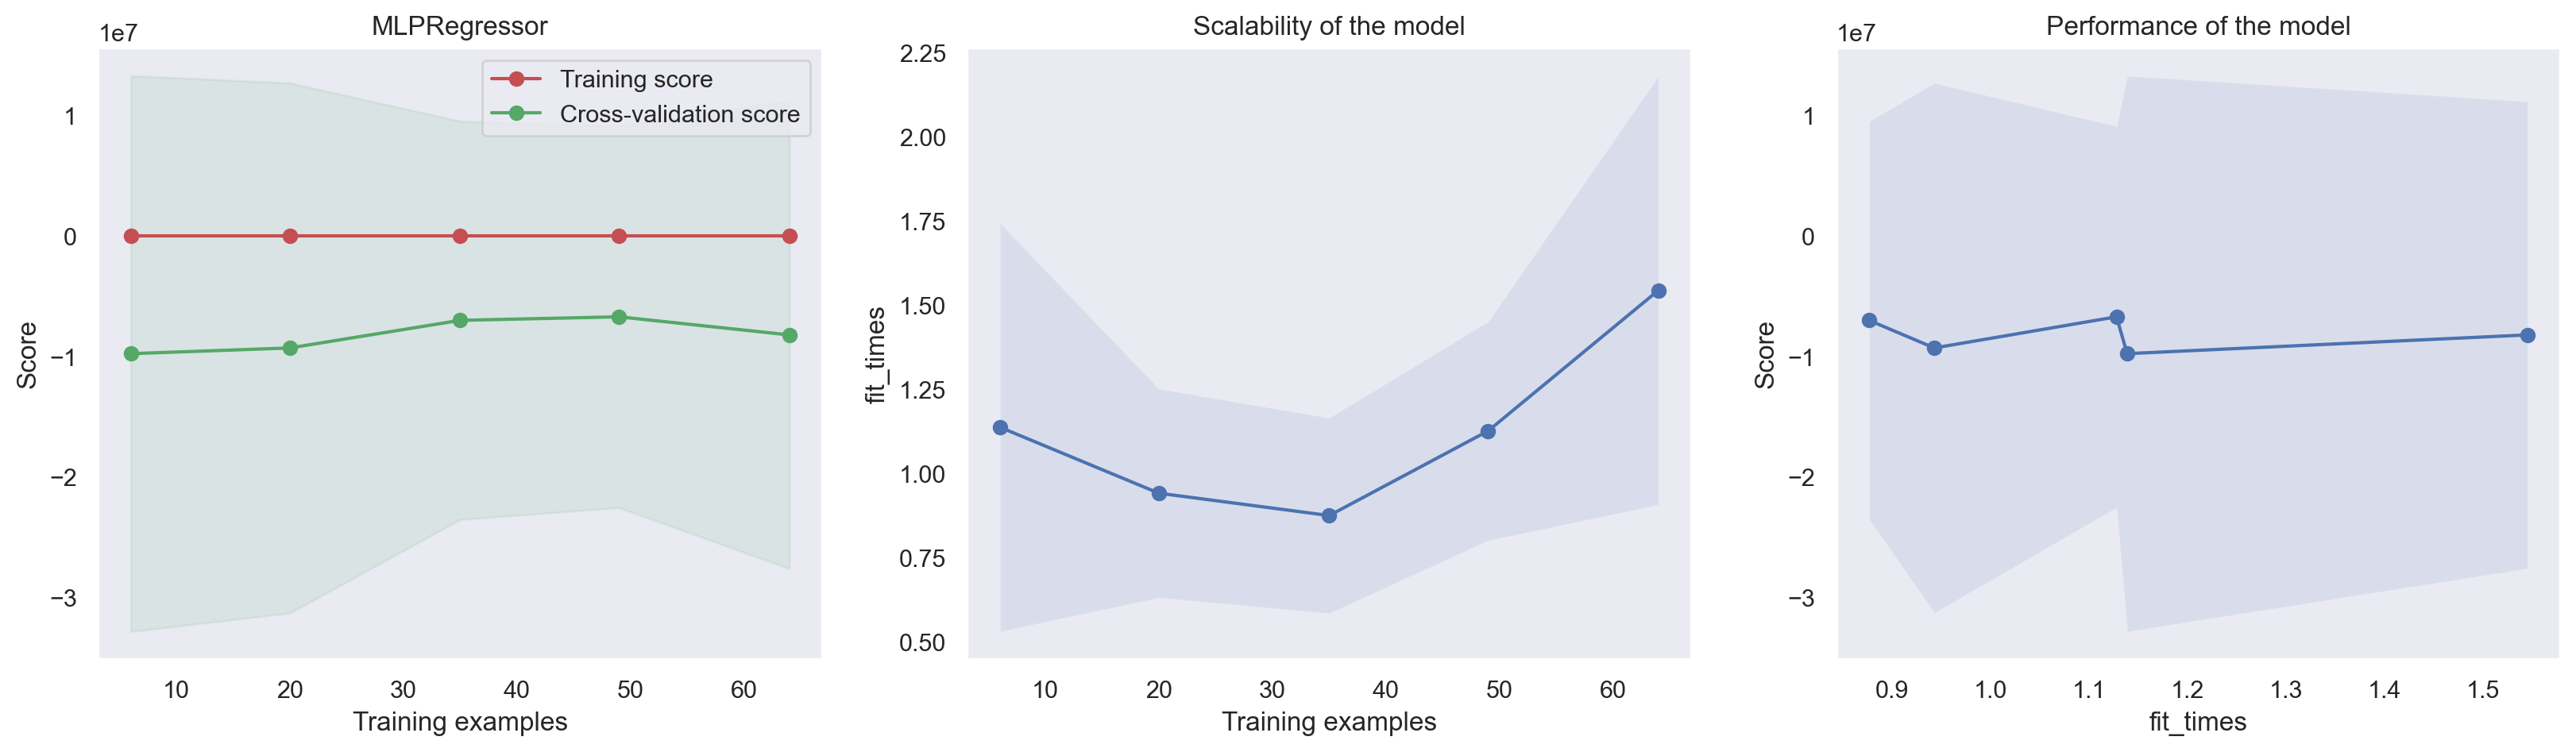

KNeighborsRegressor: NEG_MAPE=-4.469014 (STD=6.623487) (R2=0.996266)


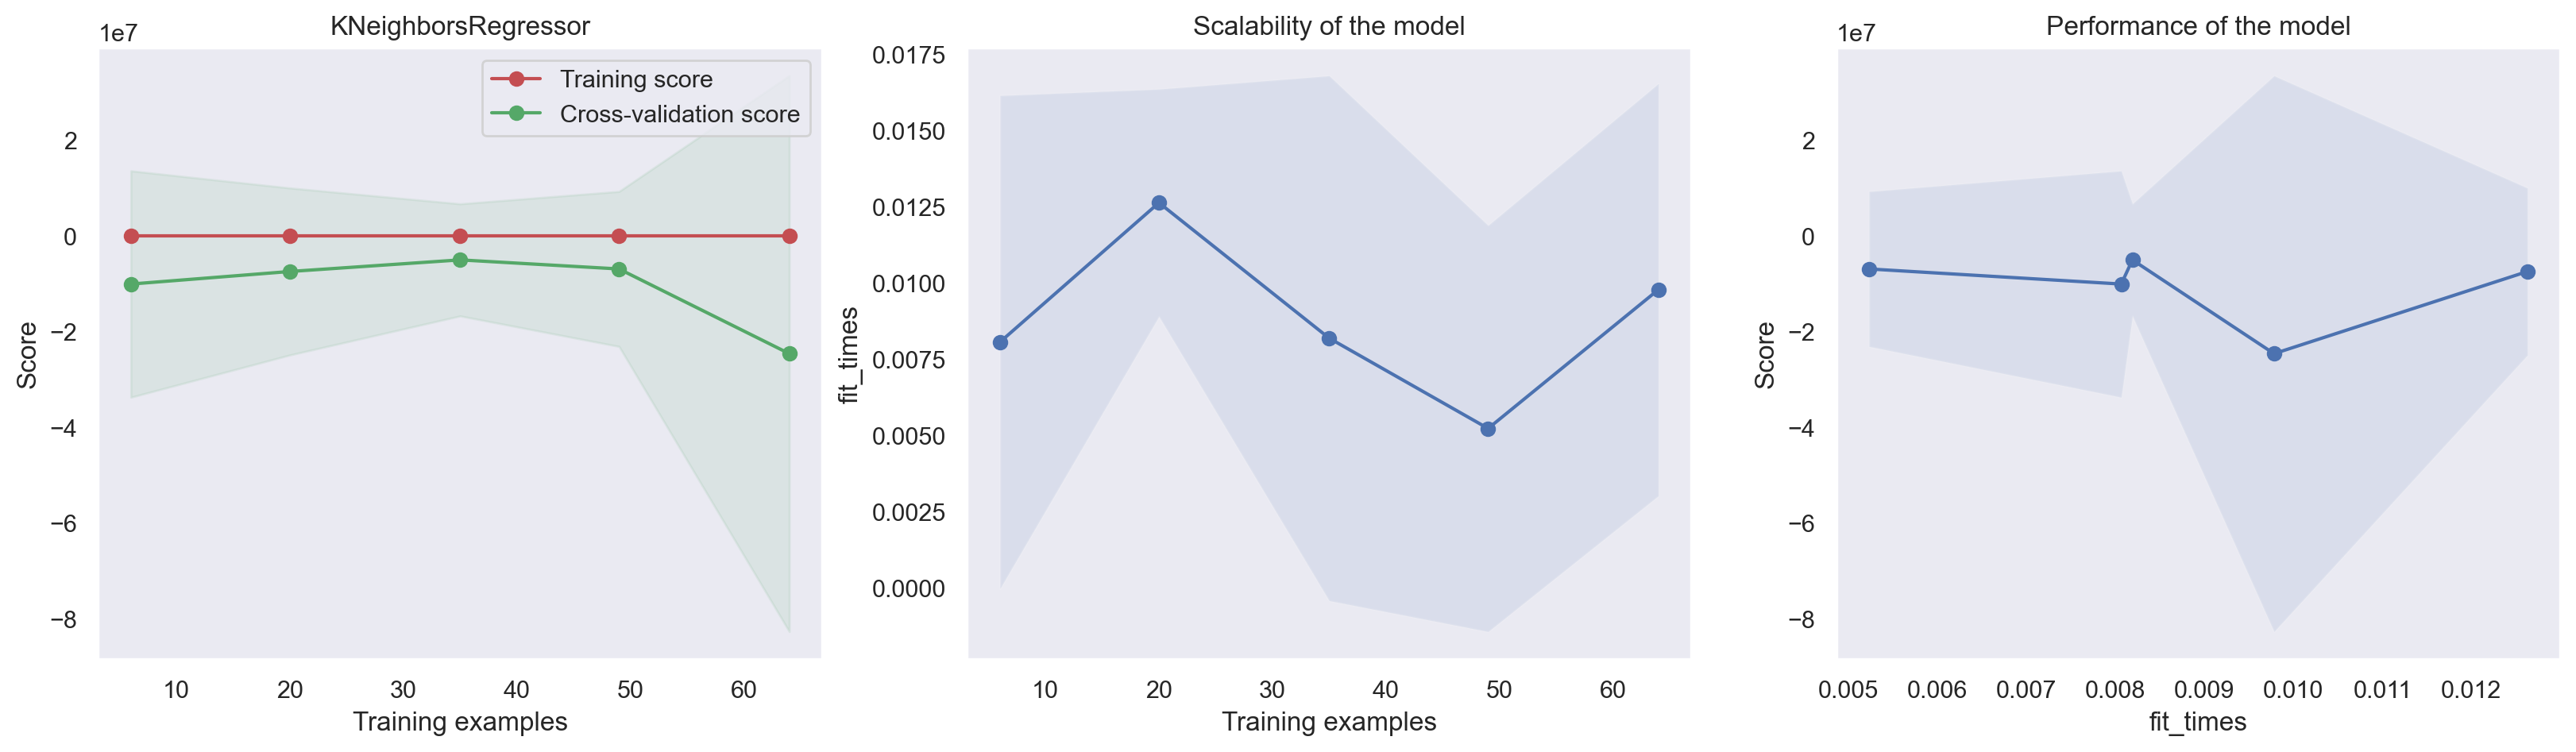

RandomForestRegressor: NEG_MAPE=-4.850735 (STD=7.931018) (R2=0.999065)


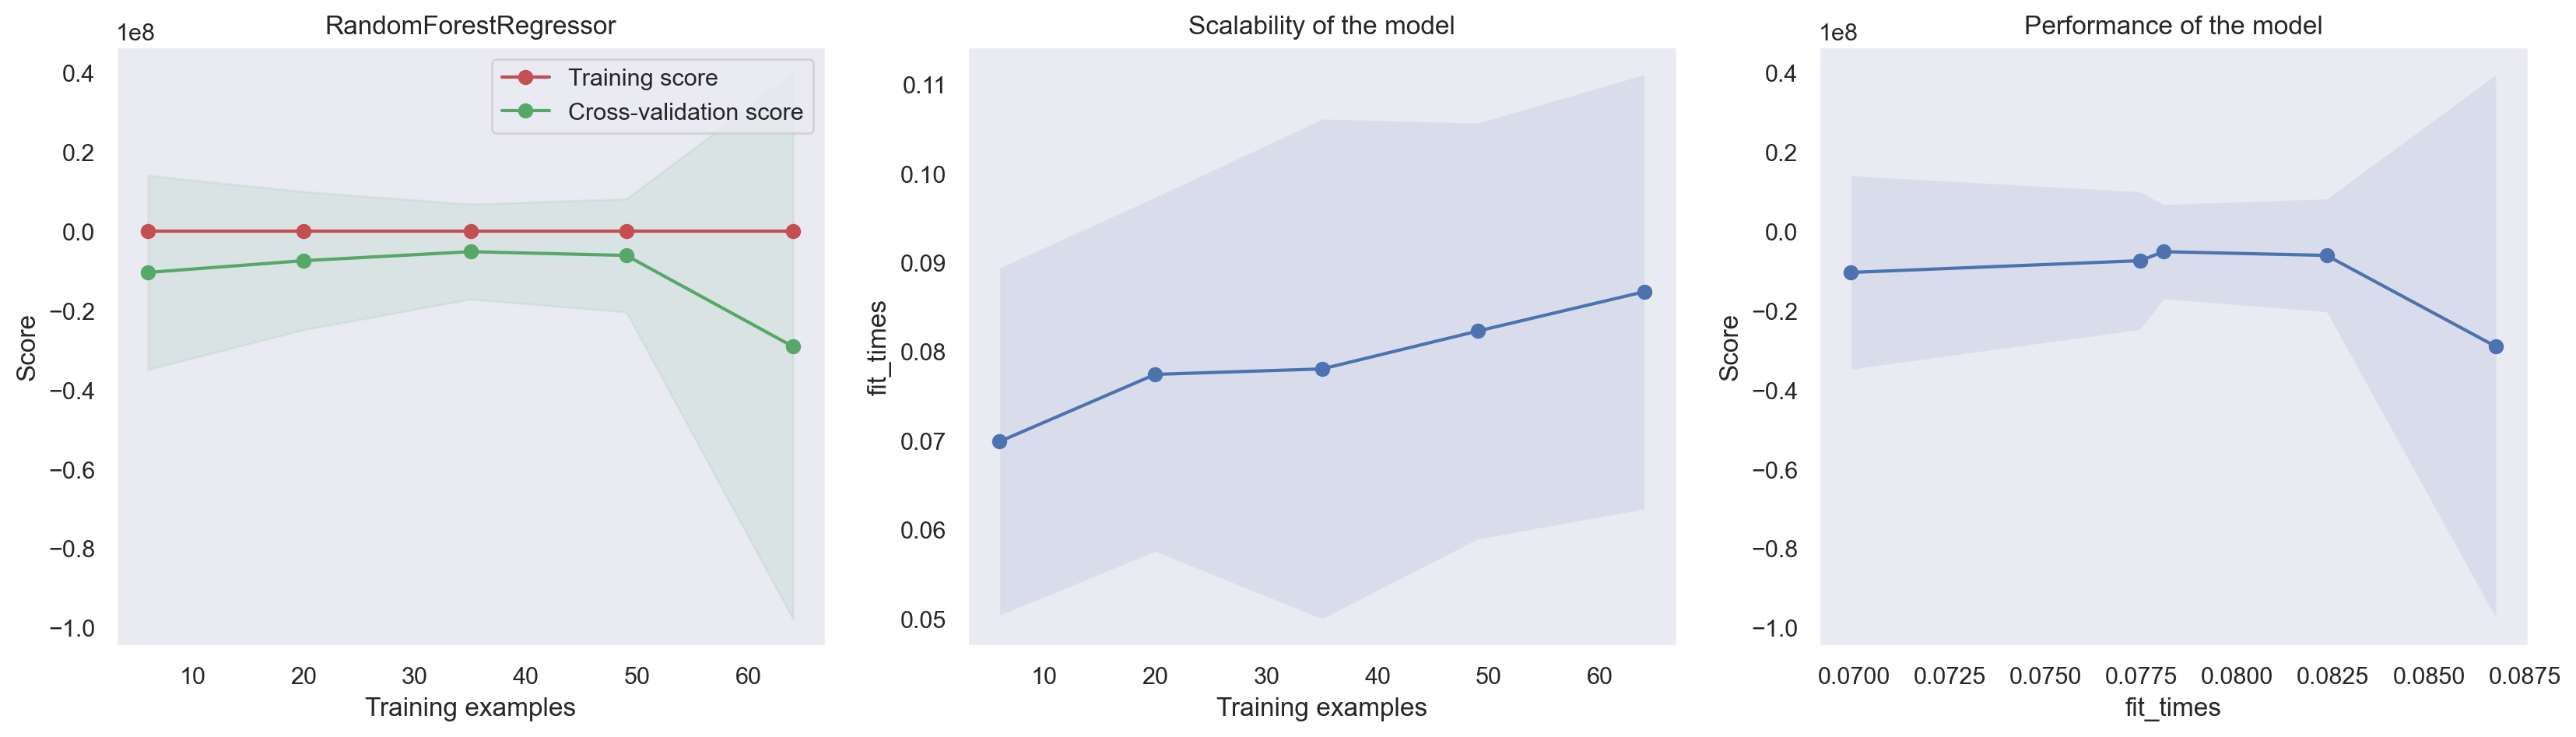

SVR: NEG_MAPE=-1379.335638 (STD=3765.586850) (R2=-0.313118)


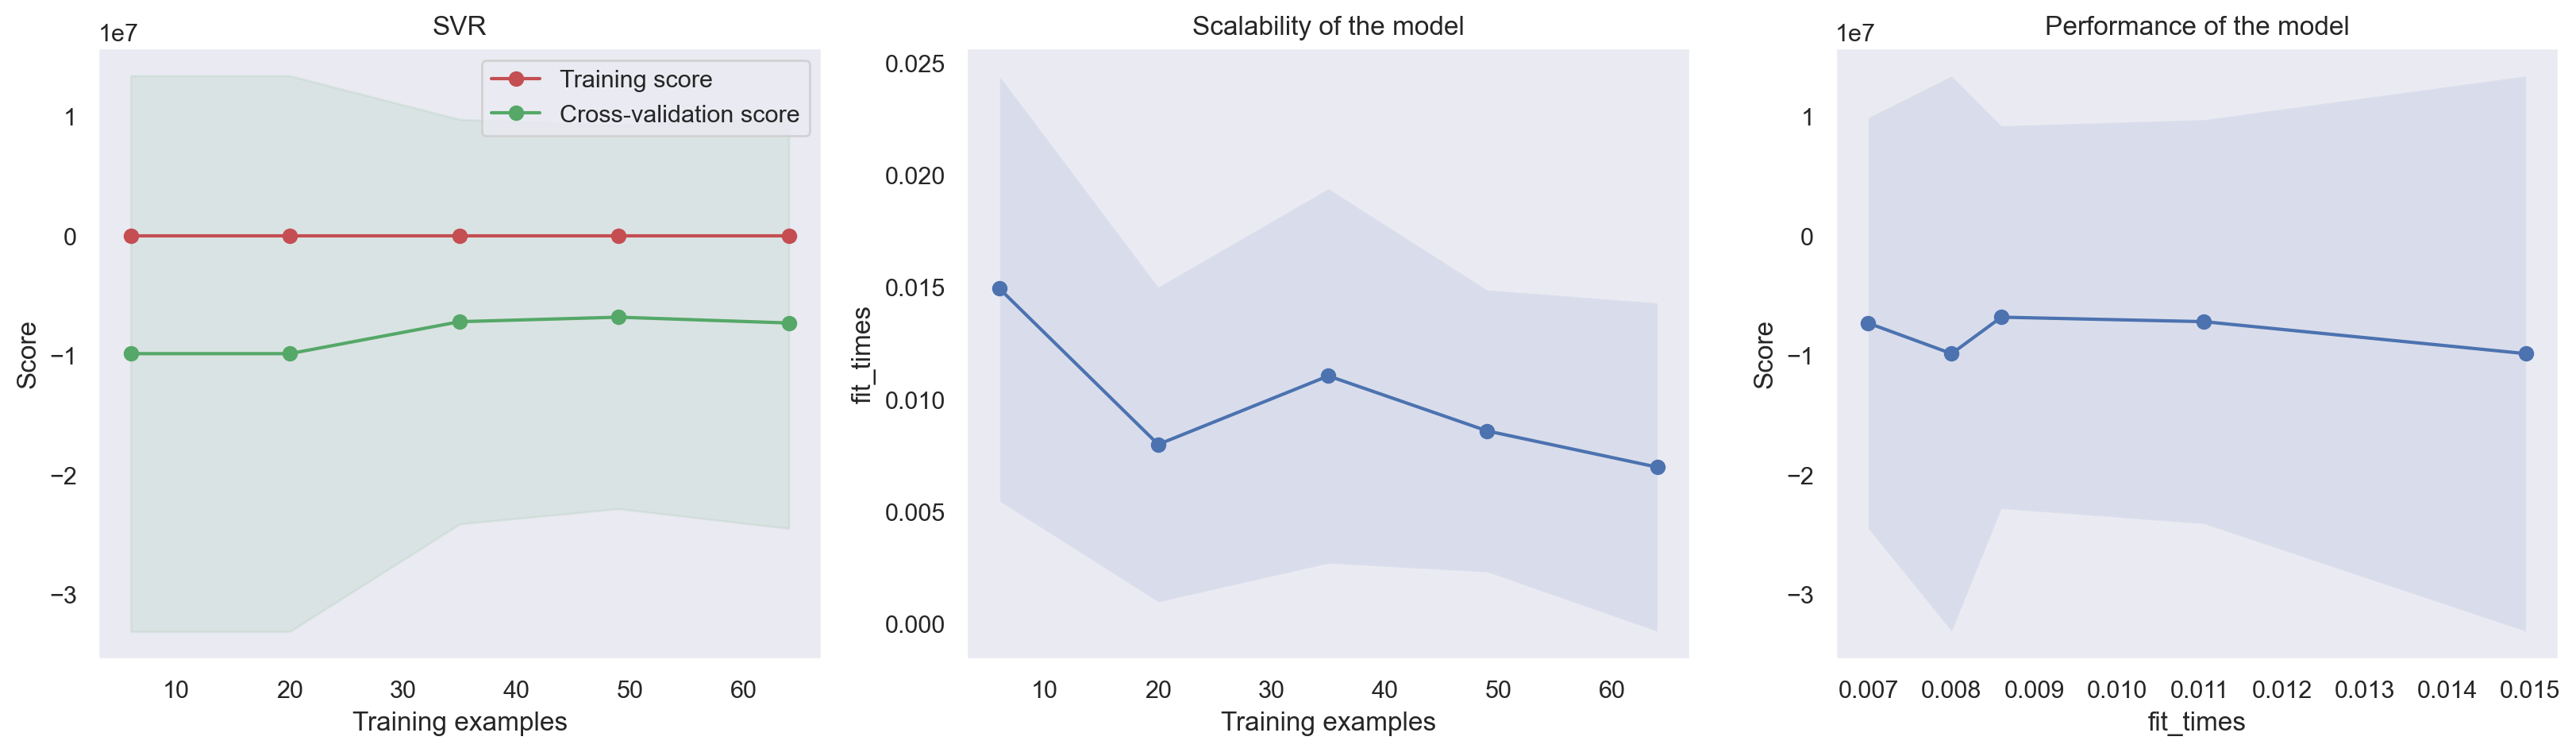

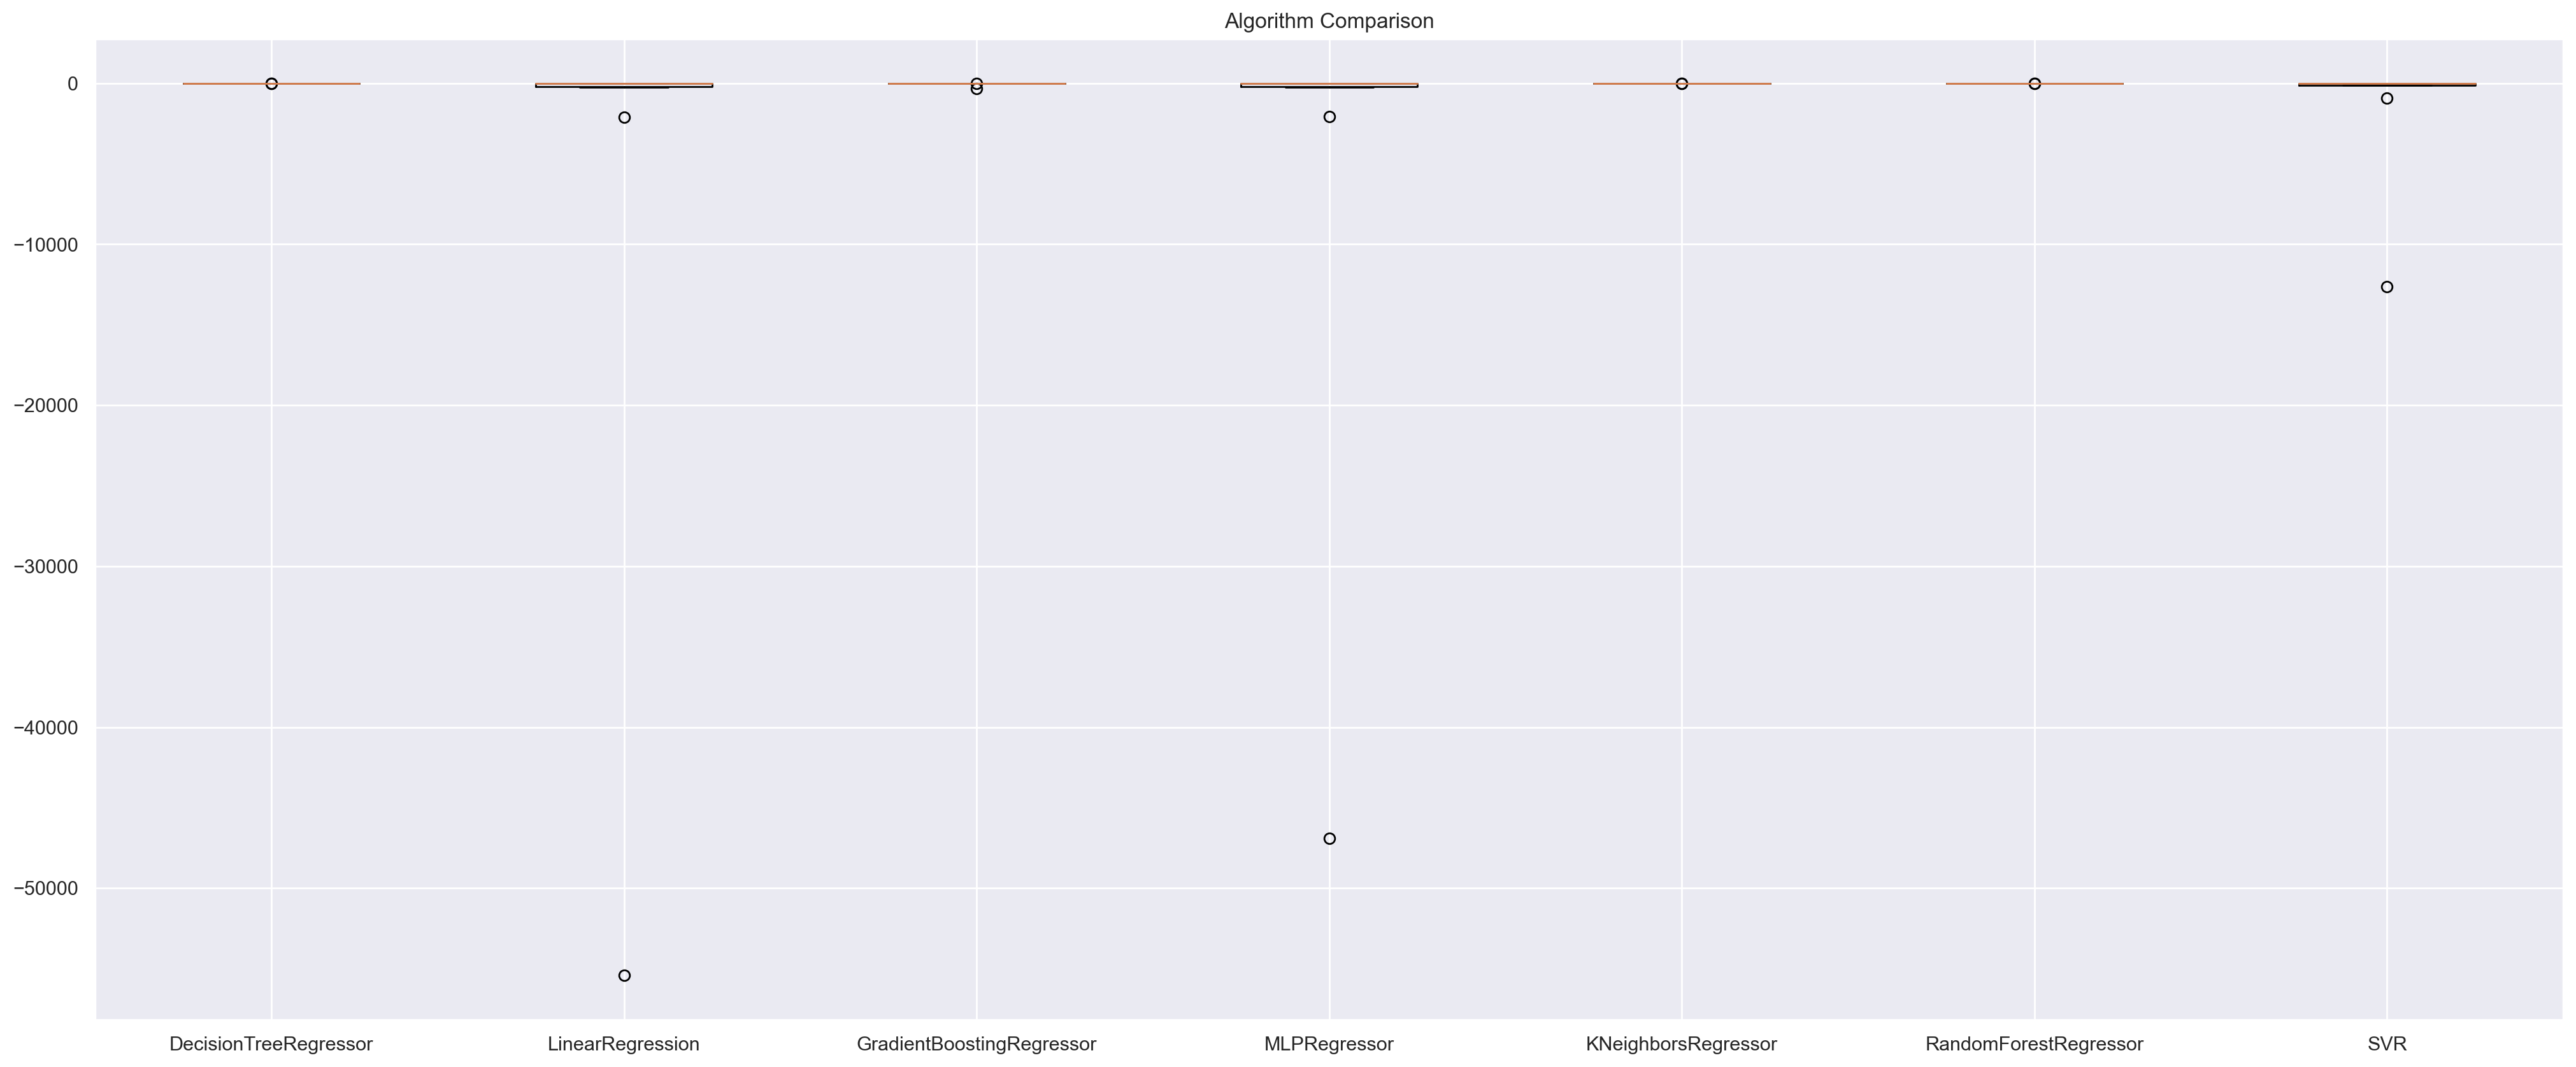

In [21]:
df_formatted = df_train['Price'].resample('7D').mean()
df_formatted = _make_formatted_dataset(df_formatted, ['Date'])
_models_score(df_formatted)

# 

# _______________________________________________________________

###  It's the moment to work with index Date to perform a better training operation using the models that perfomed better.
### Final model choosed after more tests combining resampling, scaling, shifting, and trying different regressors: 
    - MLPRegressor perform better
    - Resample skipped due to bad performances 
    - Scaling features skipped due to bad performances

### Your input features should be calculated from latest records and it should look like:

    Date	       Yesterday_Price	   Yesterday_Diff
    2023-06-14	   26030.0600	       157.78
    ...	           ...                 ... 

In [287]:
# RESAMPLE SKIPPED
# Resampling have a bad impact on MLPRgressor, and a better for RandomForestRegressor.
#df_formatted = pd.DataFrame(df_train['Price'])
#df_formatted = pd.DataFrame(df_train['Price'].resample('7D').mean()) 

df_train = pd.read_csv('dataset.csv', parse_dates=True, index_col='Date')
df_train = df_train.sort_index()

df_train['Price'] = (df_train['High'] + df_train['Low']) / 2

df_formatted = pd.DataFrame(df_train['Price'])

# SHIFTING FEATURE 'Price'
df_formatted = _get_shifted_dataset(df_formatted)

# SCALING SKIPPED
# Scaling prices features have a bad impact and will be ignored
#df_formatted = _get_scaled_dataset(df_formatted)

df_formatted.info()

Price  Yesterday_Price  Yesterday_Diff
Date                                                   
2010-07-17      0.0500           0.0000          0.0000
2010-07-18      0.0858           0.0500          0.0000
2010-07-19      0.0808           0.0858          0.0358
2010-07-20      0.0747           0.0808         -0.0050
2010-07-21      0.0792           0.0747         -0.0061
...                ...              ...             ...
2023-06-09  26546.0950       26498.9450       -229.9850
2023-06-10  25996.2050       26546.0950         47.1500
2023-06-11  25912.2150       25996.2050       -549.8900
2023-06-12  25872.2800       25912.2150        -83.9900
2023-06-13  26030.0600       25872.2800        -39.9350

[4715 rows x 3 columns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4715 entries, 2010-07-17 to 2023-06-13
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            4715 non-null   float64
 1   Yesterday_Price  4715 non-null   float64
 2   Yesterday_Diff   4715 non-null   float64
dtypes: float64(3)
memory usage: 147.3 KB


In [288]:
X = df_formatted.drop('Price', axis=1)
y = df_formatted.Price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Best Model GridSearchCV: Pipeline(steps=[('mlpmodel',
                 MLPRegressor(hidden_layer_sizes=(32, 8), max_iter=2000))])
Train score RandomForestRegressor GridSearchCV model 0.9980651469898991
Train NEGATIVE MAPE best score -0.027968496006394596
Train NEGATIVE MAE: -62.48970200534792
Train NEGATIVE MAPE: -0.02883325603789778


<module 'matplotlib.pyplot' from 'C:\\Users\\User\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

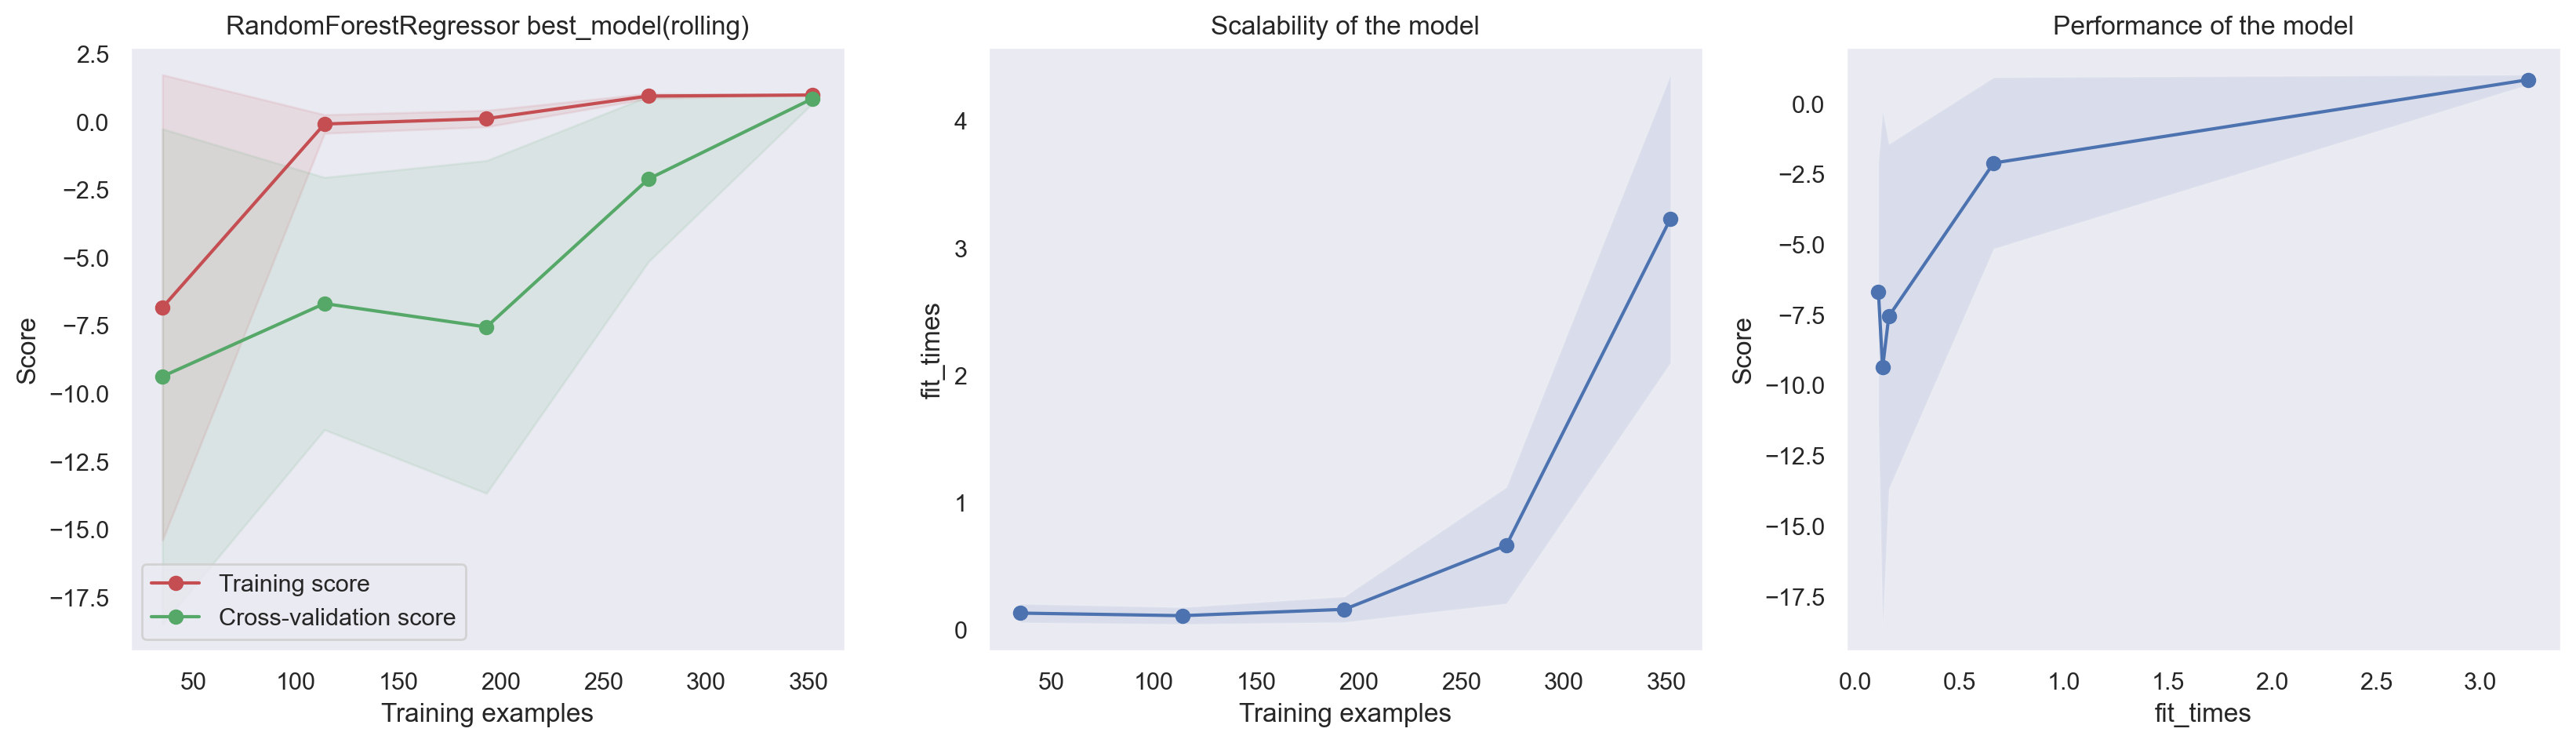

In [289]:
model_pipe = Pipeline([
    
    ('mlpmodel', MLPRegressor(hidden_layer_sizes=(32, 8), solver = 'adam', max_iter=2000))
])

param_search = {}

tscv = TimeSeriesSplit(n_splits=10)

gsearch = GridSearchCV(model_pipe, param_grid=param_search, cv=tscv, refit=True, scoring=neg_mape)

gsearch.fit(X_train, y_train)

best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
print("Best Model GridSearchCV:", best_model)
print("Train score RandomForestRegressor GridSearchCV model", best_model.score(X_train, y_train))
print("Train NEGATIVE MAPE best score", best_score)
print("Train NEGATIVE MAE:", -mean_absolute_error(y_train, best_model.predict(X_train)))
print("Train NEGATIVE MAPE:", -mean_absolute_percentage_error(y_train, best_model.predict(X_train)))

plot_learning_curve(best_model, "RandomForestRegressor best_model(rolling)", X_train, y_train, cv=tscv)

Test score RandomForestRegressor GridSearchCV model 0.9937766315671592
Test NEGATIVE MAPE: -0.020734210785381645
Test NEGATIVE MAE: -739.8065577310467


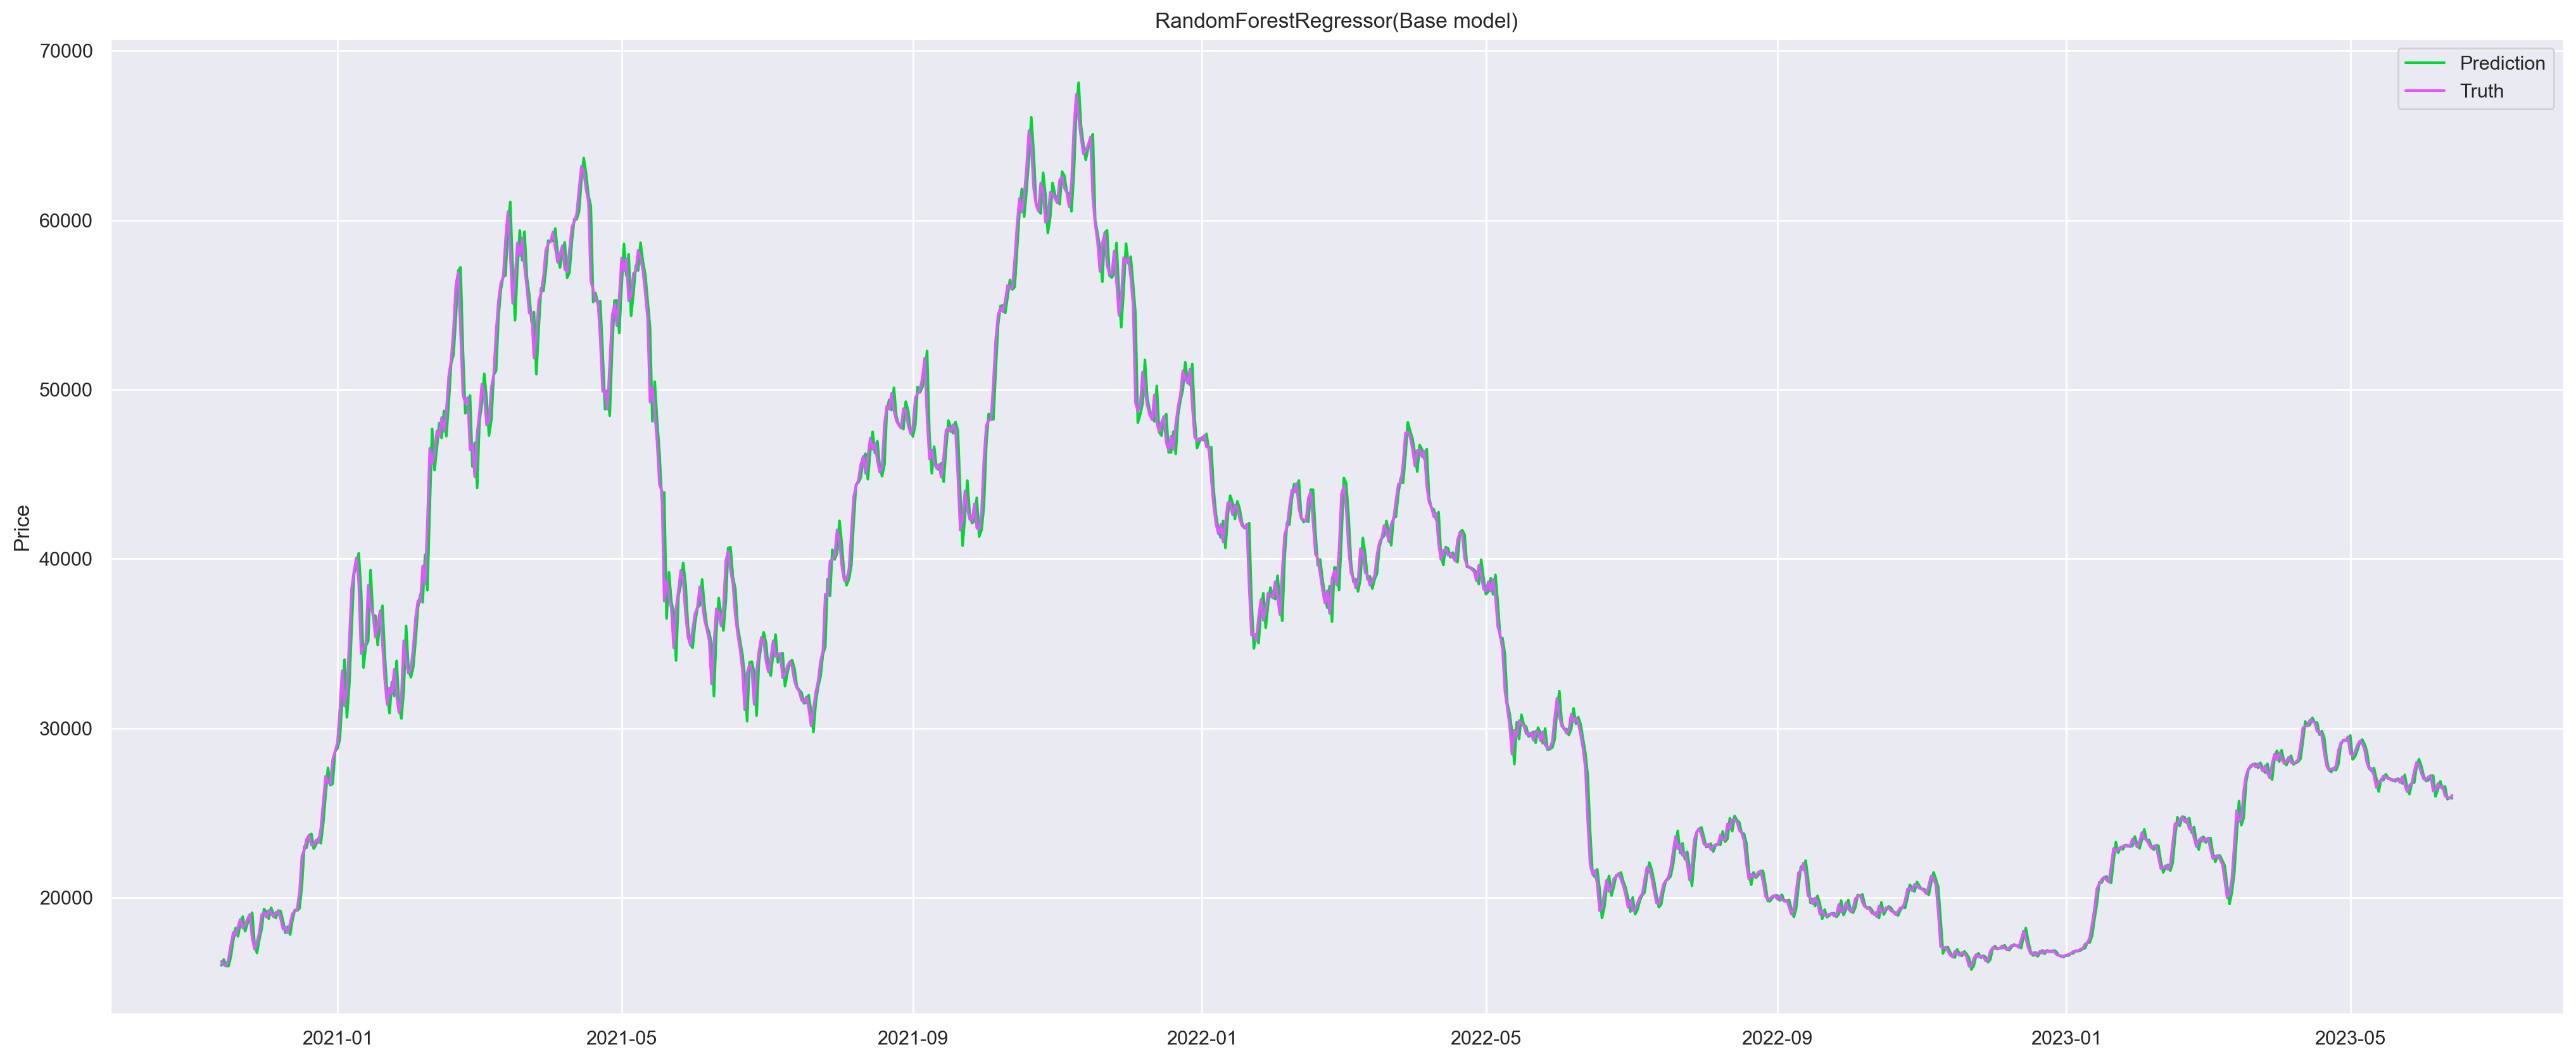

In [290]:
print("Test score RandomForestRegressor GridSearchCV model", best_model.score(X_test, y_test))
print("Test NEGATIVE MAPE:", -mean_absolute_percentage_error(y_test, best_model.predict(X_test)))
print("Test NEGATIVE MAE:", -mean_absolute_error(y_test, best_model.predict(X_test)))

df_test = pd.DataFrame(X_test)

df_test['predicted'] = best_model.predict(X_test)
df_test['truth'] = y_test
# Plot comparison results between predicted and real values
plt.plot(df_test.predicted,
         label='Prediction', color='#00D732')
plt.plot(df_test.truth,
         label='Truth', color='#DE57FF')
plt.title("RandomForestRegressor(Base model)")
plt.ylabel('Price')
plt.legend();
plt.show()

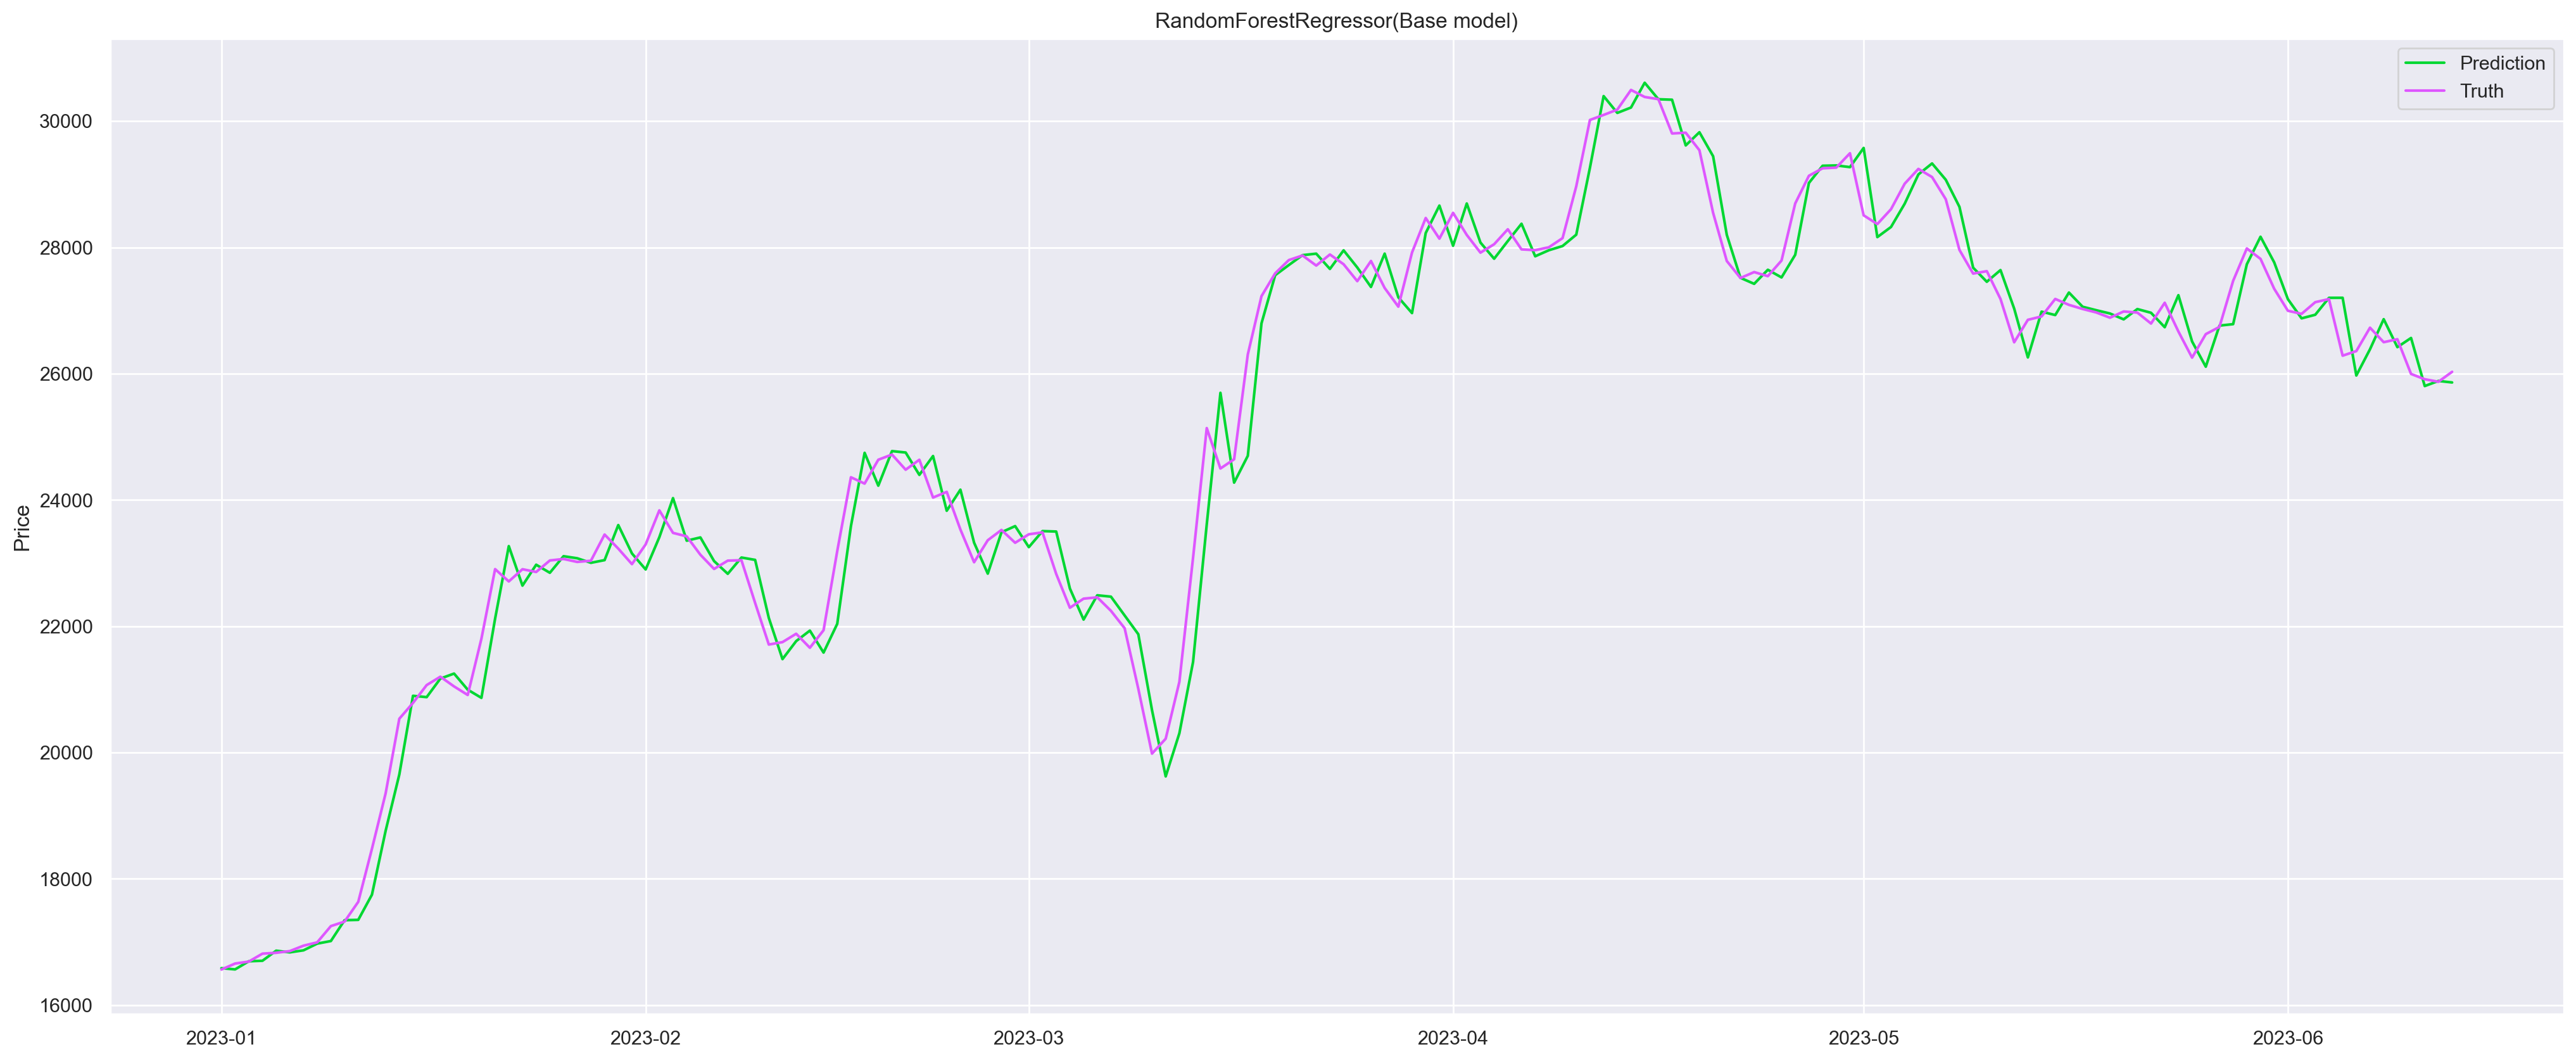

In [291]:
# Plot comparison results between predicted and real values
plt.plot(df_test['2023':].predicted,
         label='Prediction', color='#00D732')
plt.plot(df_test['2023':].truth,
         label='Truth', color='#DE57FF')
plt.title("RandomForestRegressor(Base model)")
plt.ylabel('Price')
plt.legend();
plt.show()